In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
#import cPickle
import sys
sys.path.insert(0, '..')
import tensorflow as tf

#from helper import plot_mats

X = np.load('./shiftsuniform_x.npy').astype('float32')
Y = np.load('./shiftsuniform_y.npy').astype('float32')

numvisX = X.shape[1]
numvisY = Y.shape[1]
ntrain = X.shape[0]

def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))

def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()

    
    

numpy_rng = np.random.RandomState(1)

numfac  = 100
nummap  = 25

#NORMALIZE DATA:
X -= X.mean(0)[None, :]
Y -= Y.mean(0)[None, :]
X /= X.std(0)[None, :] + X.std() * 0.1
Y /= Y.std(0)[None, :] + Y.std() * 0.1


inputsX = tf.placeholder(tf.float32, [None, numvisX])
inputsY = tf.placeholder(tf.float32, [None, numvisY])

wxf = tf.Variable(tf.random_normal(shape=(numvisX, numfac)) * 0.01)
wyf = tf.Variable(tf.random_normal(shape=(numvisY, numfac)) * 0.01)

whf = tf.Variable(np.exp(numpy_rng.uniform(low=-3.0, high=-2.0, size=(nummap, numfac)),dtype='float32'))
whf_in = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=(nummap, numfac)).astype('float32'))

bmap = tf.Variable(np.zeros(nummap, dtype='float32'), name='bmap')
bvisX = tf.Variable(np.zeros(numvisX, dtype='float32'), name='bvisX')
bvisY = tf.Variable(np.zeros(numvisY, dtype='float32'), name='bvisY')


CorruptedX = tf.multiply(random_binomial(tf.shape(inputsX),p=0.5),inputsX)
CorruptedY = tf.multiply(random_binomial(tf.shape(inputsY),p=0.5),inputsY)

fx = tf.matmul(CorruptedX , wxf)
fy = tf.matmul(CorruptedY , wyf)

mappings = tf.sigmoid(tf.matmul(tf.multiply(fx , fy), tf.transpose(whf_in))+ bmap)
fH = tf.matmul(mappings, whf)

outputx = tf.matmul(tf.multiply(fy , fH),tf.transpose(wxf)) + bvisX
outputy = tf.matmul(tf.multiply(fx , fH),tf.transpose(wyf)) + bvisY
#output = tf.matmul(fH,tf.transpose(wxf))

cost = tf.nn.l2_loss(outputx-inputsX) + tf.nn.l2_loss(outputy-inputsY)

#+tf.reduce_sum(wxf**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)




        

In [2]:
def normalizefilters(sess,_wxf,_wyf,center=True):
        def inplacemult(x, v):
            x[:, :] *= v
            return x
        def inplacesubtract(x, v):
            x[:, :] -= v
            return x
        wxf_ = _wxf.eval(sess)
        wyf_ = _wyf.eval(sess)
        nwxf = (wxf_.std(0)+SMALL)[np.newaxis, :]
        nwyf = (wyf_.std(0)+SMALL)[np.newaxis, :]
        meannxf = nwxf.mean()
        meannyf = nwyf.mean()

        # CENTER FILTERS 
        if center:
            _wxf.assign(inplacesubtract(wxf_, wxf_.mean(0)[np.newaxis,:])).eval()
            _wyf.assign(inplacesubtract(wyf_, wyf_.mean(0)[np.newaxis,:])).eval()
        # FIX STANDARD DEVIATION 
        _wxf.assign(inplacemult(wxf_, meannxf/nwxf)).eval()
        _wyf.assign(inplacemult(wyf_, meannyf/nwyf)).eval()

In [3]:
wxf_normalized = tf.nn.l2_normalize(wxf, [0,1], epsilon=1e-12, name=None)
wyf_normalized = tf.nn.l2_normalize(wyf, [0,1], epsilon=1e-12, name=None)

normalize_wxf = wxf.assign(wxf_normalized)
normalize_wyf = wxf.assign(wyf_normalized)

Epoch: 000/20000 cost: 139.657775000
Epoch: 001/20000 cost: 139.674975000
Epoch: 002/20000 cost: 139.685800000
Epoch: 003/20000 cost: 139.691375000
Epoch: 004/20000 cost: 139.687425000
Epoch: 005/20000 cost: 139.685225000
Epoch: 006/20000 cost: 139.675625000
Epoch: 007/20000 cost: 139.653812500
Epoch: 008/20000 cost: 139.642625000
Epoch: 009/20000 cost: 139.611587500
Epoch: 010/20000 cost: 139.584925000
Epoch: 011/20000 cost: 139.559225000
Epoch: 012/20000 cost: 139.525500000
Epoch: 013/20000 cost: 139.497362500
Epoch: 014/20000 cost: 139.465600000
Epoch: 015/20000 cost: 139.423700000
Epoch: 016/20000 cost: 139.397000000
Epoch: 017/20000 cost: 139.367975000
Epoch: 018/20000 cost: 139.334525000
Epoch: 019/20000 cost: 139.302875000
Epoch: 020/20000 cost: 139.279187500
Epoch: 021/20000 cost: 139.248300000
Epoch: 022/20000 cost: 139.227550000
Epoch: 023/20000 cost: 139.214800000
Epoch: 024/20000 cost: 139.187975000
Epoch: 025/20000 cost: 139.167300000
Epoch: 026/20000 cost: 139.151300000
E

Epoch: 224/20000 cost: 137.028275000
Epoch: 225/20000 cost: 136.980137500
Epoch: 226/20000 cost: 136.933000000
Epoch: 227/20000 cost: 136.889750000
Epoch: 228/20000 cost: 136.861850000
Epoch: 229/20000 cost: 136.788950000
Epoch: 230/20000 cost: 136.751075000
Epoch: 231/20000 cost: 136.712150000
Epoch: 232/20000 cost: 136.654075000
Epoch: 233/20000 cost: 136.639887500
Epoch: 234/20000 cost: 136.594925000
Epoch: 235/20000 cost: 136.549225000
Epoch: 236/20000 cost: 136.488650000
Epoch: 237/20000 cost: 136.439012500
Epoch: 238/20000 cost: 136.408762500
Epoch: 239/20000 cost: 136.370775000
Epoch: 240/20000 cost: 136.316000000
Epoch: 241/20000 cost: 136.283787500
Epoch: 242/20000 cost: 136.235637500
Epoch: 243/20000 cost: 136.208900000
Epoch: 244/20000 cost: 136.174300000
Epoch: 245/20000 cost: 136.126087500
Epoch: 246/20000 cost: 136.092987500
Epoch: 247/20000 cost: 136.054987500
Epoch: 248/20000 cost: 136.009850000
Epoch: 249/20000 cost: 135.962525000
Epoch: 250/20000 cost: 135.920150000
E

Epoch: 446/20000 cost: 131.947175000
Epoch: 447/20000 cost: 131.955100000
Epoch: 448/20000 cost: 131.956725000
Epoch: 449/20000 cost: 131.927825000
Epoch: 450/20000 cost: 131.907925000
Epoch: 451/20000 cost: 131.919612500
Epoch: 452/20000 cost: 131.907800000
Epoch: 453/20000 cost: 131.935350000
Epoch: 454/20000 cost: 131.932550000
Epoch: 455/20000 cost: 131.923775000
Epoch: 456/20000 cost: 131.895150000
Epoch: 457/20000 cost: 131.916800000
Epoch: 458/20000 cost: 131.871825000
Epoch: 459/20000 cost: 131.832012500
Epoch: 460/20000 cost: 131.806412500
Epoch: 461/20000 cost: 131.786050000
Epoch: 462/20000 cost: 131.805950000
Epoch: 463/20000 cost: 131.829225000
Epoch: 464/20000 cost: 131.835575000
Epoch: 465/20000 cost: 131.865175000
Epoch: 466/20000 cost: 131.853775000
Epoch: 467/20000 cost: 131.822200000
Epoch: 468/20000 cost: 131.779775000
Epoch: 469/20000 cost: 131.748987500
Epoch: 470/20000 cost: 131.740675000
Epoch: 471/20000 cost: 131.760600000
Epoch: 472/20000 cost: 131.699175000
E

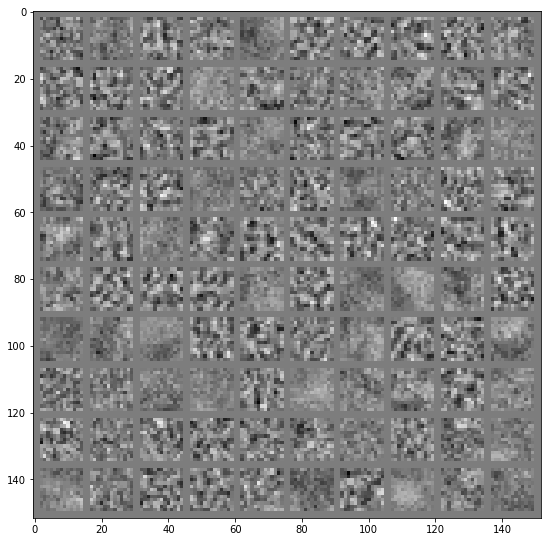

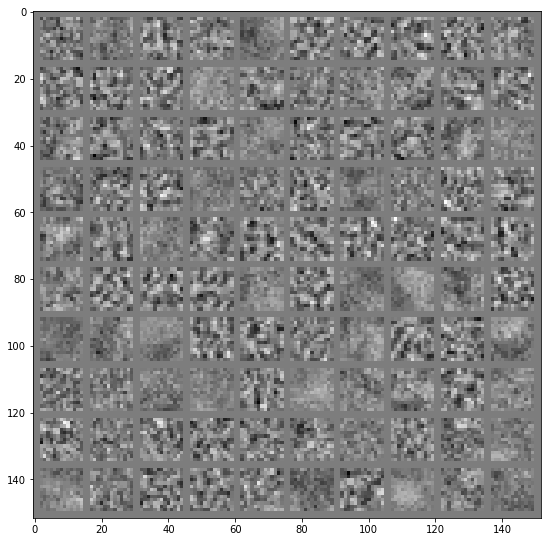

Epoch: 500/20000 cost: 131.458675000
Epoch: 501/20000 cost: 131.448725000
Epoch: 502/20000 cost: 131.452825000
Epoch: 503/20000 cost: 131.471162500
Epoch: 504/20000 cost: 131.485312500
Epoch: 505/20000 cost: 131.463250000
Epoch: 506/20000 cost: 131.423350000
Epoch: 507/20000 cost: 131.445400000
Epoch: 508/20000 cost: 131.406000000
Epoch: 509/20000 cost: 131.433975000
Epoch: 510/20000 cost: 131.422775000
Epoch: 511/20000 cost: 131.414500000
Epoch: 512/20000 cost: 131.409037500
Epoch: 513/20000 cost: 131.406400000
Epoch: 514/20000 cost: 131.411450000
Epoch: 515/20000 cost: 131.375025000
Epoch: 516/20000 cost: 131.413525000
Epoch: 517/20000 cost: 131.397750000
Epoch: 518/20000 cost: 131.388887500
Epoch: 519/20000 cost: 131.357500000
Epoch: 520/20000 cost: 131.361150000
Epoch: 521/20000 cost: 131.351575000
Epoch: 522/20000 cost: 131.290350000
Epoch: 523/20000 cost: 131.282250000
Epoch: 524/20000 cost: 131.294087500
Epoch: 525/20000 cost: 131.233225000
Epoch: 526/20000 cost: 131.306925000
E

Epoch: 724/20000 cost: 130.340450000
Epoch: 725/20000 cost: 130.377950000
Epoch: 726/20000 cost: 130.356725000
Epoch: 727/20000 cost: 130.319050000
Epoch: 728/20000 cost: 130.360000000
Epoch: 729/20000 cost: 130.352837500
Epoch: 730/20000 cost: 130.358150000
Epoch: 731/20000 cost: 130.358325000
Epoch: 732/20000 cost: 130.354475000
Epoch: 733/20000 cost: 130.364150000
Epoch: 734/20000 cost: 130.298350000
Epoch: 735/20000 cost: 130.317387500
Epoch: 736/20000 cost: 130.339050000
Epoch: 737/20000 cost: 130.329675000
Epoch: 738/20000 cost: 130.319950000
Epoch: 739/20000 cost: 130.308837500
Epoch: 740/20000 cost: 130.281162500
Epoch: 741/20000 cost: 130.298362500
Epoch: 742/20000 cost: 130.261475000
Epoch: 743/20000 cost: 130.268262500
Epoch: 744/20000 cost: 130.270775000
Epoch: 745/20000 cost: 130.277825000
Epoch: 746/20000 cost: 130.275125000
Epoch: 747/20000 cost: 130.253262500
Epoch: 748/20000 cost: 130.262000000
Epoch: 749/20000 cost: 130.258337500
Epoch: 750/20000 cost: 130.279387500
E

Epoch: 946/20000 cost: 129.755037500
Epoch: 947/20000 cost: 129.736562500
Epoch: 948/20000 cost: 129.720512500
Epoch: 949/20000 cost: 129.733350000
Epoch: 950/20000 cost: 129.751575000
Epoch: 951/20000 cost: 129.672700000
Epoch: 952/20000 cost: 129.695150000
Epoch: 953/20000 cost: 129.716050000
Epoch: 954/20000 cost: 129.696362500
Epoch: 955/20000 cost: 129.715400000
Epoch: 956/20000 cost: 129.696025000
Epoch: 957/20000 cost: 129.723300000
Epoch: 958/20000 cost: 129.708500000
Epoch: 959/20000 cost: 129.677637500
Epoch: 960/20000 cost: 129.647100000
Epoch: 961/20000 cost: 129.733800000
Epoch: 962/20000 cost: 129.668625000
Epoch: 963/20000 cost: 129.646075000
Epoch: 964/20000 cost: 129.701600000
Epoch: 965/20000 cost: 129.675750000
Epoch: 966/20000 cost: 129.667550000
Epoch: 967/20000 cost: 129.666812500
Epoch: 968/20000 cost: 129.669875000
Epoch: 969/20000 cost: 129.654725000
Epoch: 970/20000 cost: 129.652650000
Epoch: 971/20000 cost: 129.677950000
Epoch: 972/20000 cost: 129.680487500
E

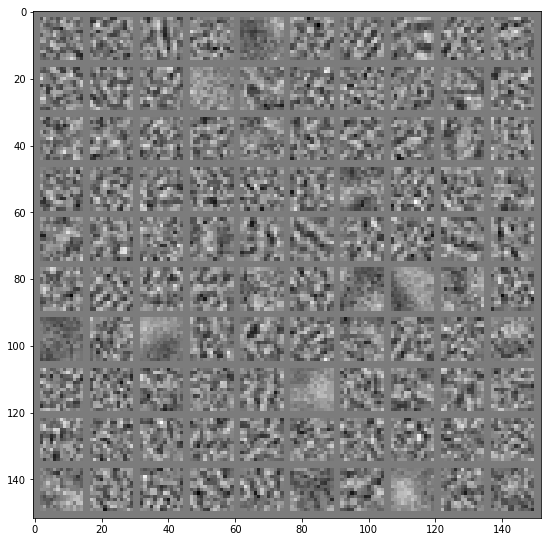

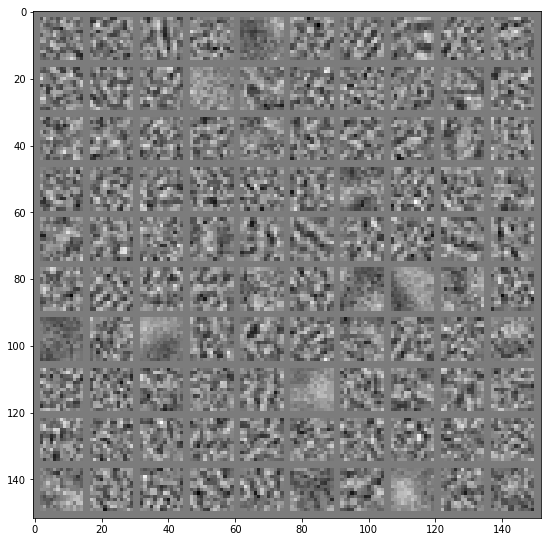

Epoch: 1000/20000 cost: 129.575000000
Epoch: 1001/20000 cost: 129.566100000
Epoch: 1002/20000 cost: 129.514887500
Epoch: 1003/20000 cost: 129.592937500
Epoch: 1004/20000 cost: 129.567437500
Epoch: 1005/20000 cost: 129.586650000
Epoch: 1006/20000 cost: 129.604500000
Epoch: 1007/20000 cost: 129.605162500
Epoch: 1008/20000 cost: 129.592825000
Epoch: 1009/20000 cost: 129.602575000
Epoch: 1010/20000 cost: 129.582275000
Epoch: 1011/20000 cost: 129.604275000
Epoch: 1012/20000 cost: 129.613150000
Epoch: 1013/20000 cost: 129.581850000
Epoch: 1014/20000 cost: 129.608200000
Epoch: 1015/20000 cost: 129.593700000
Epoch: 1016/20000 cost: 129.546525000
Epoch: 1017/20000 cost: 129.563350000
Epoch: 1018/20000 cost: 129.559962500
Epoch: 1019/20000 cost: 129.583075000
Epoch: 1020/20000 cost: 129.534050000
Epoch: 1021/20000 cost: 129.553737500
Epoch: 1022/20000 cost: 129.546250000
Epoch: 1023/20000 cost: 129.525175000
Epoch: 1024/20000 cost: 129.535275000
Epoch: 1025/20000 cost: 129.505062500
Epoch: 1026/

Epoch: 1218/20000 cost: 129.278600000
Epoch: 1219/20000 cost: 129.290050000
Epoch: 1220/20000 cost: 129.260462500
Epoch: 1221/20000 cost: 129.201825000
Epoch: 1222/20000 cost: 129.247287500
Epoch: 1223/20000 cost: 129.237600000
Epoch: 1224/20000 cost: 129.207175000
Epoch: 1225/20000 cost: 129.221300000
Epoch: 1226/20000 cost: 129.228050000
Epoch: 1227/20000 cost: 129.256575000
Epoch: 1228/20000 cost: 129.203275000
Epoch: 1229/20000 cost: 129.257162500
Epoch: 1230/20000 cost: 129.212550000
Epoch: 1231/20000 cost: 129.276575000
Epoch: 1232/20000 cost: 129.273125000
Epoch: 1233/20000 cost: 129.234562500
Epoch: 1234/20000 cost: 129.246887500
Epoch: 1235/20000 cost: 129.243950000
Epoch: 1236/20000 cost: 129.215950000
Epoch: 1237/20000 cost: 129.172650000
Epoch: 1238/20000 cost: 129.184425000
Epoch: 1239/20000 cost: 129.232650000
Epoch: 1240/20000 cost: 129.269425000
Epoch: 1241/20000 cost: 129.245950000
Epoch: 1242/20000 cost: 129.235700000
Epoch: 1243/20000 cost: 129.260662500
Epoch: 1244/

Epoch: 1436/20000 cost: 129.061675000
Epoch: 1437/20000 cost: 128.983300000
Epoch: 1438/20000 cost: 128.990887500
Epoch: 1439/20000 cost: 128.991275000
Epoch: 1440/20000 cost: 129.050950000
Epoch: 1441/20000 cost: 129.045200000
Epoch: 1442/20000 cost: 129.056000000
Epoch: 1443/20000 cost: 129.053075000
Epoch: 1444/20000 cost: 129.020800000
Epoch: 1445/20000 cost: 129.071125000
Epoch: 1446/20000 cost: 129.083050000
Epoch: 1447/20000 cost: 129.000250000
Epoch: 1448/20000 cost: 129.074825000
Epoch: 1449/20000 cost: 129.039200000
Epoch: 1450/20000 cost: 129.032162500
Epoch: 1451/20000 cost: 129.001775000
Epoch: 1452/20000 cost: 129.058200000
Epoch: 1453/20000 cost: 129.019200000
Epoch: 1454/20000 cost: 129.059200000
Epoch: 1455/20000 cost: 129.009800000
Epoch: 1456/20000 cost: 129.032150000
Epoch: 1457/20000 cost: 129.024025000
Epoch: 1458/20000 cost: 129.002762500
Epoch: 1459/20000 cost: 128.986700000
Epoch: 1460/20000 cost: 128.976325000
Epoch: 1461/20000 cost: 128.968975000
Epoch: 1462/

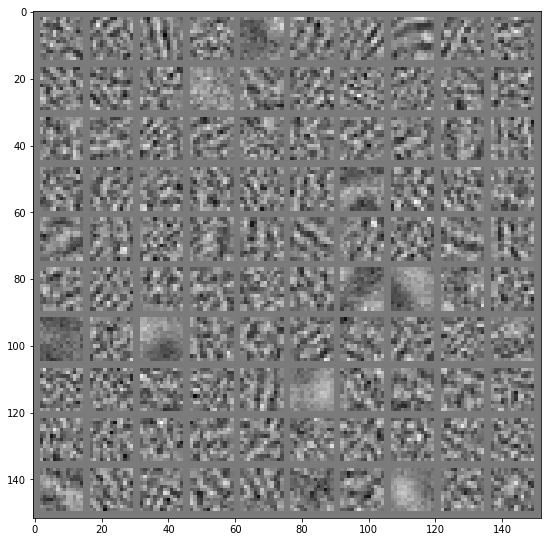

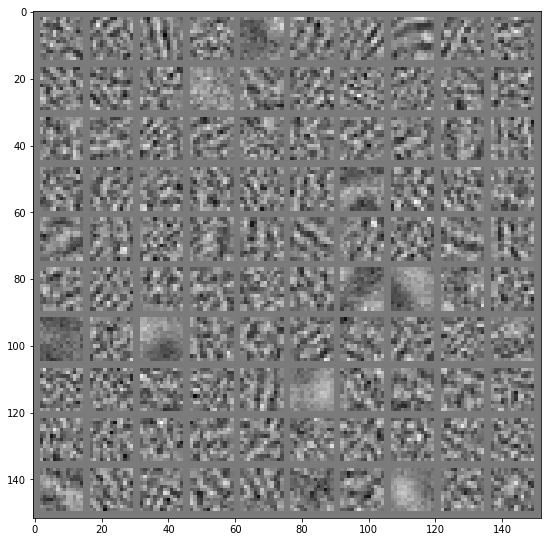

Epoch: 1500/20000 cost: 128.929287500
Epoch: 1501/20000 cost: 128.901837500
Epoch: 1502/20000 cost: 128.908900000
Epoch: 1503/20000 cost: 128.910462500
Epoch: 1504/20000 cost: 128.934025000
Epoch: 1505/20000 cost: 128.930775000
Epoch: 1506/20000 cost: 128.961200000
Epoch: 1507/20000 cost: 128.986375000
Epoch: 1508/20000 cost: 128.973937500
Epoch: 1509/20000 cost: 128.940912500
Epoch: 1510/20000 cost: 128.909062500
Epoch: 1511/20000 cost: 128.908375000
Epoch: 1512/20000 cost: 128.912575000
Epoch: 1513/20000 cost: 128.882500000
Epoch: 1514/20000 cost: 128.891725000
Epoch: 1515/20000 cost: 128.923750000
Epoch: 1516/20000 cost: 128.973275000
Epoch: 1517/20000 cost: 128.929087500
Epoch: 1518/20000 cost: 128.872400000
Epoch: 1519/20000 cost: 128.894800000
Epoch: 1520/20000 cost: 128.870000000
Epoch: 1521/20000 cost: 128.887875000
Epoch: 1522/20000 cost: 128.906150000
Epoch: 1523/20000 cost: 128.911337500
Epoch: 1524/20000 cost: 128.894987500
Epoch: 1525/20000 cost: 128.939075000
Epoch: 1526/

Epoch: 1717/20000 cost: 128.709475000
Epoch: 1718/20000 cost: 128.710500000
Epoch: 1719/20000 cost: 128.712062500
Epoch: 1720/20000 cost: 128.686250000
Epoch: 1721/20000 cost: 128.656150000
Epoch: 1722/20000 cost: 128.670750000
Epoch: 1723/20000 cost: 128.654375000
Epoch: 1724/20000 cost: 128.670400000
Epoch: 1725/20000 cost: 128.606200000
Epoch: 1726/20000 cost: 128.666675000
Epoch: 1727/20000 cost: 128.638112500
Epoch: 1728/20000 cost: 128.618800000
Epoch: 1729/20000 cost: 128.633975000
Epoch: 1730/20000 cost: 128.648425000
Epoch: 1731/20000 cost: 128.686250000
Epoch: 1732/20000 cost: 128.688150000
Epoch: 1733/20000 cost: 128.663925000
Epoch: 1734/20000 cost: 128.700662500
Epoch: 1735/20000 cost: 128.698562500
Epoch: 1736/20000 cost: 128.686100000
Epoch: 1737/20000 cost: 128.659562500
Epoch: 1738/20000 cost: 128.674450000
Epoch: 1739/20000 cost: 128.670400000
Epoch: 1740/20000 cost: 128.625637500
Epoch: 1741/20000 cost: 128.638925000
Epoch: 1742/20000 cost: 128.612000000
Epoch: 1743/

Epoch: 1935/20000 cost: 128.471512500
Epoch: 1936/20000 cost: 128.465425000
Epoch: 1937/20000 cost: 128.514950000
Epoch: 1938/20000 cost: 128.511225000
Epoch: 1939/20000 cost: 128.503275000
Epoch: 1940/20000 cost: 128.496900000
Epoch: 1941/20000 cost: 128.538375000
Epoch: 1942/20000 cost: 128.477850000
Epoch: 1943/20000 cost: 128.487450000
Epoch: 1944/20000 cost: 128.447125000
Epoch: 1945/20000 cost: 128.440062500
Epoch: 1946/20000 cost: 128.435737500
Epoch: 1947/20000 cost: 128.425162500
Epoch: 1948/20000 cost: 128.469700000
Epoch: 1949/20000 cost: 128.459475000
Epoch: 1950/20000 cost: 128.458712500
Epoch: 1951/20000 cost: 128.391875000
Epoch: 1952/20000 cost: 128.440375000
Epoch: 1953/20000 cost: 128.445887500
Epoch: 1954/20000 cost: 128.444562500
Epoch: 1955/20000 cost: 128.444912500
Epoch: 1956/20000 cost: 128.404050000
Epoch: 1957/20000 cost: 128.489350000
Epoch: 1958/20000 cost: 128.446450000
Epoch: 1959/20000 cost: 128.471200000
Epoch: 1960/20000 cost: 128.454662500
Epoch: 1961/

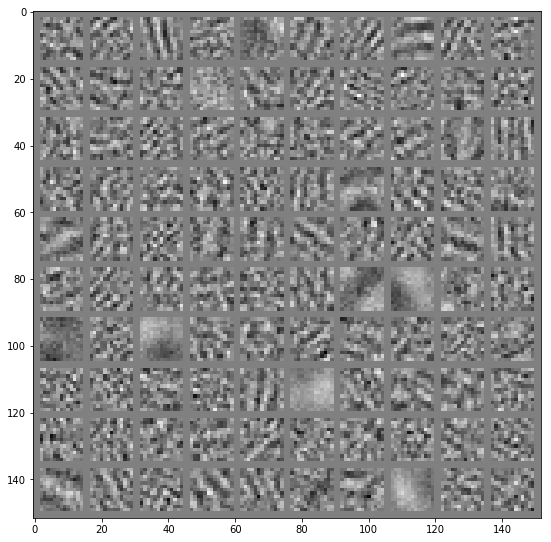

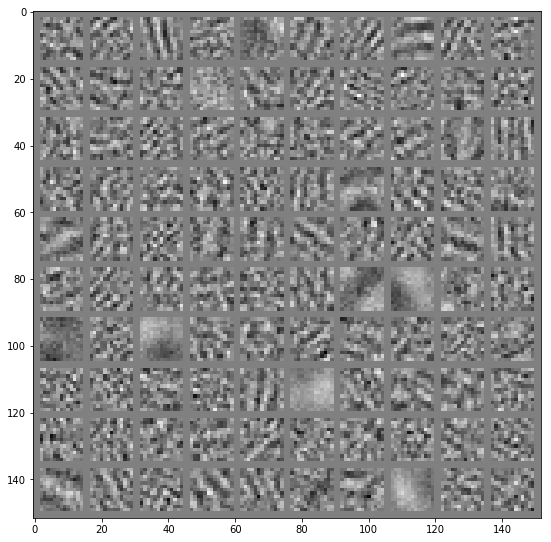

Epoch: 2000/20000 cost: 128.430300000
Epoch: 2001/20000 cost: 128.396937500
Epoch: 2002/20000 cost: 128.392575000
Epoch: 2003/20000 cost: 128.374000000
Epoch: 2004/20000 cost: 128.393950000
Epoch: 2005/20000 cost: 128.410987500
Epoch: 2006/20000 cost: 128.386400000
Epoch: 2007/20000 cost: 128.411312500
Epoch: 2008/20000 cost: 128.329537500
Epoch: 2009/20000 cost: 128.377250000
Epoch: 2010/20000 cost: 128.327800000
Epoch: 2011/20000 cost: 128.354975000
Epoch: 2012/20000 cost: 128.341512500
Epoch: 2013/20000 cost: 128.385050000
Epoch: 2014/20000 cost: 128.394225000
Epoch: 2015/20000 cost: 128.389825000
Epoch: 2016/20000 cost: 128.369025000
Epoch: 2017/20000 cost: 128.367975000
Epoch: 2018/20000 cost: 128.379212500
Epoch: 2019/20000 cost: 128.411425000
Epoch: 2020/20000 cost: 128.369400000
Epoch: 2021/20000 cost: 128.377050000
Epoch: 2022/20000 cost: 128.366175000
Epoch: 2023/20000 cost: 128.368100000
Epoch: 2024/20000 cost: 128.388650000
Epoch: 2025/20000 cost: 128.347725000
Epoch: 2026/

Epoch: 2217/20000 cost: 128.227137500
Epoch: 2218/20000 cost: 128.183600000
Epoch: 2219/20000 cost: 128.195612500
Epoch: 2220/20000 cost: 128.218237500
Epoch: 2221/20000 cost: 128.219575000
Epoch: 2222/20000 cost: 128.225025000
Epoch: 2223/20000 cost: 128.203075000
Epoch: 2224/20000 cost: 128.193200000
Epoch: 2225/20000 cost: 128.238637500
Epoch: 2226/20000 cost: 128.144050000
Epoch: 2227/20000 cost: 128.180375000
Epoch: 2228/20000 cost: 128.209362500
Epoch: 2229/20000 cost: 128.208525000
Epoch: 2230/20000 cost: 128.151650000
Epoch: 2231/20000 cost: 128.185362500
Epoch: 2232/20000 cost: 128.177600000
Epoch: 2233/20000 cost: 128.211037500
Epoch: 2234/20000 cost: 128.125550000
Epoch: 2235/20000 cost: 128.137075000
Epoch: 2236/20000 cost: 128.147825000
Epoch: 2237/20000 cost: 128.161325000
Epoch: 2238/20000 cost: 128.176250000
Epoch: 2239/20000 cost: 128.198775000
Epoch: 2240/20000 cost: 128.221525000
Epoch: 2241/20000 cost: 128.198450000
Epoch: 2242/20000 cost: 128.170387500
Epoch: 2243/

Epoch: 2435/20000 cost: 127.958212500
Epoch: 2436/20000 cost: 127.969425000
Epoch: 2437/20000 cost: 127.949937500
Epoch: 2438/20000 cost: 127.960200000
Epoch: 2439/20000 cost: 127.961550000
Epoch: 2440/20000 cost: 127.973250000
Epoch: 2441/20000 cost: 127.941775000
Epoch: 2442/20000 cost: 127.971825000
Epoch: 2443/20000 cost: 127.939025000
Epoch: 2444/20000 cost: 127.914800000
Epoch: 2445/20000 cost: 127.935100000
Epoch: 2446/20000 cost: 127.909375000
Epoch: 2447/20000 cost: 127.948750000
Epoch: 2448/20000 cost: 127.972112500
Epoch: 2449/20000 cost: 127.940400000
Epoch: 2450/20000 cost: 128.007525000
Epoch: 2451/20000 cost: 127.986750000
Epoch: 2452/20000 cost: 127.980350000
Epoch: 2453/20000 cost: 128.020162500
Epoch: 2454/20000 cost: 127.974287500
Epoch: 2455/20000 cost: 127.969650000
Epoch: 2456/20000 cost: 127.958950000
Epoch: 2457/20000 cost: 127.977875000
Epoch: 2458/20000 cost: 127.929825000
Epoch: 2459/20000 cost: 127.985850000
Epoch: 2460/20000 cost: 127.949075000
Epoch: 2461/

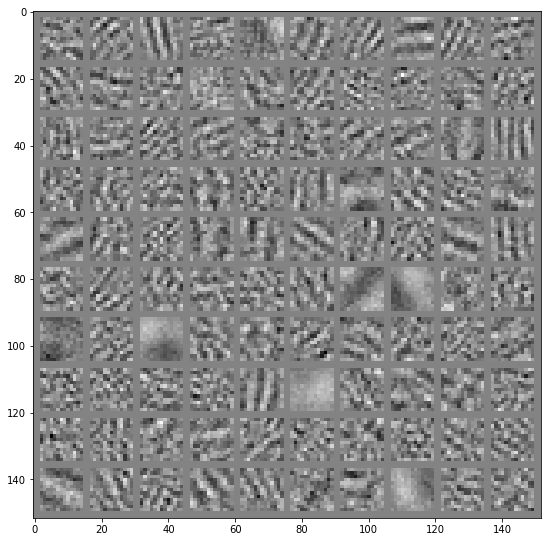

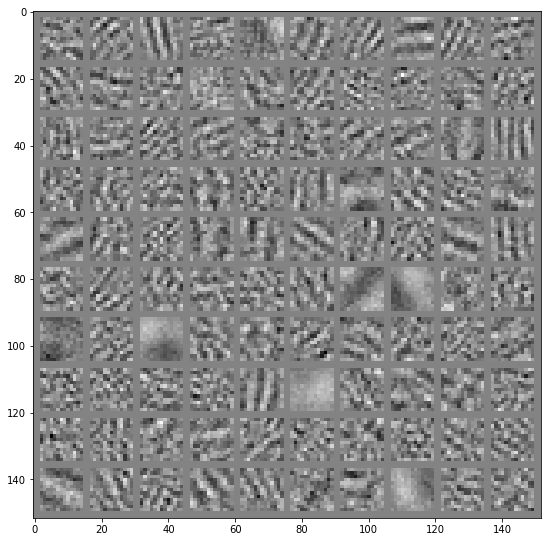

Epoch: 2500/20000 cost: 127.987112500
Epoch: 2501/20000 cost: 127.880575000
Epoch: 2502/20000 cost: 127.895587500
Epoch: 2503/20000 cost: 127.928525000
Epoch: 2504/20000 cost: 127.896012500
Epoch: 2505/20000 cost: 127.865387500
Epoch: 2506/20000 cost: 127.858287500
Epoch: 2507/20000 cost: 127.854375000
Epoch: 2508/20000 cost: 127.869162500
Epoch: 2509/20000 cost: 127.866600000
Epoch: 2510/20000 cost: 127.885400000
Epoch: 2511/20000 cost: 127.893675000
Epoch: 2512/20000 cost: 127.884250000
Epoch: 2513/20000 cost: 127.953987500
Epoch: 2514/20000 cost: 127.971412500
Epoch: 2515/20000 cost: 127.904850000
Epoch: 2516/20000 cost: 127.911162500
Epoch: 2517/20000 cost: 127.921000000
Epoch: 2518/20000 cost: 127.922700000
Epoch: 2519/20000 cost: 127.923875000
Epoch: 2520/20000 cost: 127.903250000
Epoch: 2521/20000 cost: 127.929875000
Epoch: 2522/20000 cost: 127.923100000
Epoch: 2523/20000 cost: 127.894300000
Epoch: 2524/20000 cost: 127.938475000
Epoch: 2525/20000 cost: 127.961175000
Epoch: 2526/

Epoch: 2716/20000 cost: 127.707200000
Epoch: 2717/20000 cost: 127.715487500
Epoch: 2718/20000 cost: 127.701375000
Epoch: 2719/20000 cost: 127.740650000
Epoch: 2720/20000 cost: 127.718037500
Epoch: 2721/20000 cost: 127.726500000
Epoch: 2722/20000 cost: 127.706475000
Epoch: 2723/20000 cost: 127.721275000
Epoch: 2724/20000 cost: 127.718225000
Epoch: 2725/20000 cost: 127.699175000
Epoch: 2726/20000 cost: 127.723275000
Epoch: 2727/20000 cost: 127.703425000
Epoch: 2728/20000 cost: 127.682950000
Epoch: 2729/20000 cost: 127.686050000
Epoch: 2730/20000 cost: 127.713050000
Epoch: 2731/20000 cost: 127.688800000
Epoch: 2732/20000 cost: 127.719500000
Epoch: 2733/20000 cost: 127.737275000
Epoch: 2734/20000 cost: 127.702275000
Epoch: 2735/20000 cost: 127.680875000
Epoch: 2736/20000 cost: 127.688912500
Epoch: 2737/20000 cost: 127.697225000
Epoch: 2738/20000 cost: 127.738237500
Epoch: 2739/20000 cost: 127.730100000
Epoch: 2740/20000 cost: 127.743200000
Epoch: 2741/20000 cost: 127.700787500
Epoch: 2742/

Epoch: 2932/20000 cost: 127.542650000
Epoch: 2933/20000 cost: 127.561462500
Epoch: 2934/20000 cost: 127.519575000
Epoch: 2935/20000 cost: 127.538837500
Epoch: 2936/20000 cost: 127.550650000
Epoch: 2937/20000 cost: 127.510825000
Epoch: 2938/20000 cost: 127.549425000
Epoch: 2939/20000 cost: 127.545900000
Epoch: 2940/20000 cost: 127.578325000
Epoch: 2941/20000 cost: 127.592087500
Epoch: 2942/20000 cost: 127.539275000
Epoch: 2943/20000 cost: 127.547612500
Epoch: 2944/20000 cost: 127.596575000
Epoch: 2945/20000 cost: 127.544075000
Epoch: 2946/20000 cost: 127.564762500
Epoch: 2947/20000 cost: 127.567850000
Epoch: 2948/20000 cost: 127.588250000
Epoch: 2949/20000 cost: 127.548462500
Epoch: 2950/20000 cost: 127.627637500
Epoch: 2951/20000 cost: 127.591387500
Epoch: 2952/20000 cost: 127.586775000
Epoch: 2953/20000 cost: 127.567825000
Epoch: 2954/20000 cost: 127.579025000
Epoch: 2955/20000 cost: 127.602800000
Epoch: 2956/20000 cost: 127.567450000
Epoch: 2957/20000 cost: 127.585350000
Epoch: 2958/

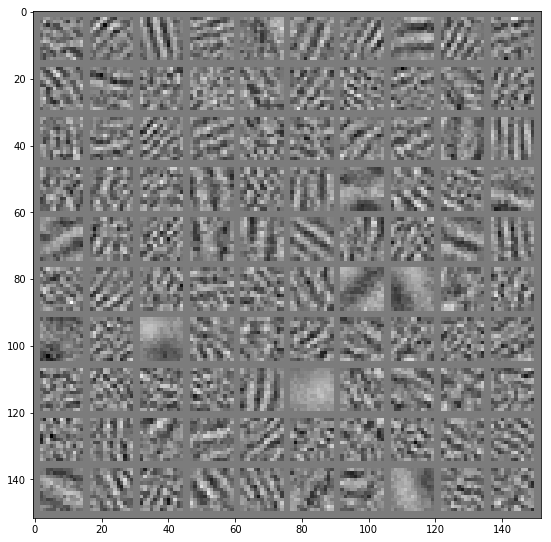

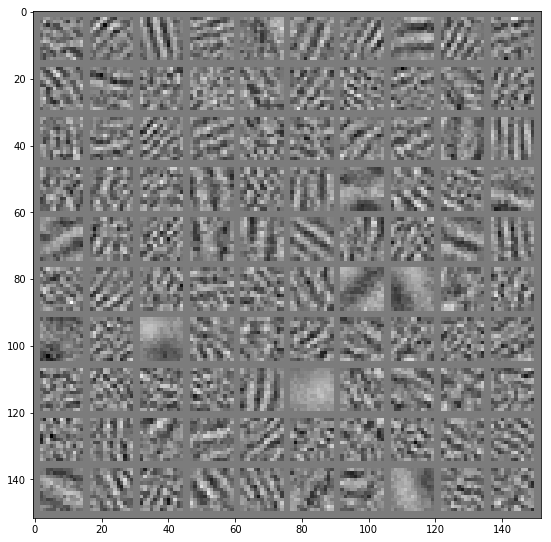

Epoch: 3000/20000 cost: 127.511800000
Epoch: 3001/20000 cost: 127.454825000
Epoch: 3002/20000 cost: 127.482950000
Epoch: 3003/20000 cost: 127.491125000
Epoch: 3004/20000 cost: 127.520925000
Epoch: 3005/20000 cost: 127.533350000
Epoch: 3006/20000 cost: 127.558925000
Epoch: 3007/20000 cost: 127.550425000
Epoch: 3008/20000 cost: 127.517275000
Epoch: 3009/20000 cost: 127.490625000
Epoch: 3010/20000 cost: 127.457375000
Epoch: 3011/20000 cost: 127.470362500
Epoch: 3012/20000 cost: 127.456225000
Epoch: 3013/20000 cost: 127.427950000
Epoch: 3014/20000 cost: 127.462250000
Epoch: 3015/20000 cost: 127.424700000
Epoch: 3016/20000 cost: 127.437050000
Epoch: 3017/20000 cost: 127.471850000
Epoch: 3018/20000 cost: 127.464375000
Epoch: 3019/20000 cost: 127.496250000
Epoch: 3020/20000 cost: 127.449300000
Epoch: 3021/20000 cost: 127.436975000
Epoch: 3022/20000 cost: 127.423150000
Epoch: 3023/20000 cost: 127.440750000
Epoch: 3024/20000 cost: 127.421000000
Epoch: 3025/20000 cost: 127.431537500
Epoch: 3026/

Epoch: 3216/20000 cost: 127.340850000
Epoch: 3217/20000 cost: 127.328075000
Epoch: 3218/20000 cost: 127.323962500
Epoch: 3219/20000 cost: 127.282012500
Epoch: 3220/20000 cost: 127.279450000
Epoch: 3221/20000 cost: 127.270250000
Epoch: 3222/20000 cost: 127.233125000
Epoch: 3223/20000 cost: 127.252975000
Epoch: 3224/20000 cost: 127.267750000
Epoch: 3225/20000 cost: 127.257562500
Epoch: 3226/20000 cost: 127.274700000
Epoch: 3227/20000 cost: 127.301312500
Epoch: 3228/20000 cost: 127.341587500
Epoch: 3229/20000 cost: 127.299600000
Epoch: 3230/20000 cost: 127.284975000
Epoch: 3231/20000 cost: 127.318775000
Epoch: 3232/20000 cost: 127.343050000
Epoch: 3233/20000 cost: 127.315787500
Epoch: 3234/20000 cost: 127.320012500
Epoch: 3235/20000 cost: 127.356850000
Epoch: 3236/20000 cost: 127.359637500
Epoch: 3237/20000 cost: 127.278100000
Epoch: 3238/20000 cost: 127.309825000
Epoch: 3239/20000 cost: 127.285800000
Epoch: 3240/20000 cost: 127.305575000
Epoch: 3241/20000 cost: 127.268787500
Epoch: 3242/

Epoch: 3432/20000 cost: 127.136400000
Epoch: 3433/20000 cost: 127.113400000
Epoch: 3434/20000 cost: 127.096400000
Epoch: 3435/20000 cost: 127.112200000
Epoch: 3436/20000 cost: 127.125050000
Epoch: 3437/20000 cost: 127.107025000
Epoch: 3438/20000 cost: 127.022925000
Epoch: 3439/20000 cost: 127.130212500
Epoch: 3440/20000 cost: 127.143437500
Epoch: 3441/20000 cost: 127.127387500
Epoch: 3442/20000 cost: 127.089975000
Epoch: 3443/20000 cost: 127.135675000
Epoch: 3444/20000 cost: 127.100950000
Epoch: 3445/20000 cost: 127.099062500
Epoch: 3446/20000 cost: 127.110875000
Epoch: 3447/20000 cost: 127.131362500
Epoch: 3448/20000 cost: 127.090587500
Epoch: 3449/20000 cost: 127.069525000
Epoch: 3450/20000 cost: 127.076950000
Epoch: 3451/20000 cost: 127.085675000
Epoch: 3452/20000 cost: 127.079312500
Epoch: 3453/20000 cost: 127.063750000
Epoch: 3454/20000 cost: 127.089912500
Epoch: 3455/20000 cost: 127.109625000
Epoch: 3456/20000 cost: 127.136175000
Epoch: 3457/20000 cost: 127.099025000
Epoch: 3458/

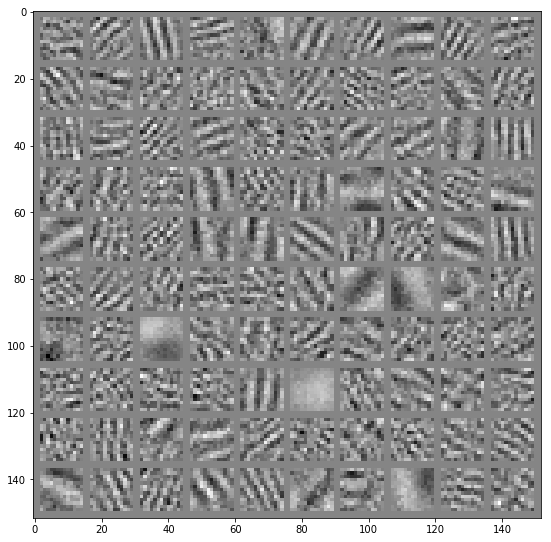

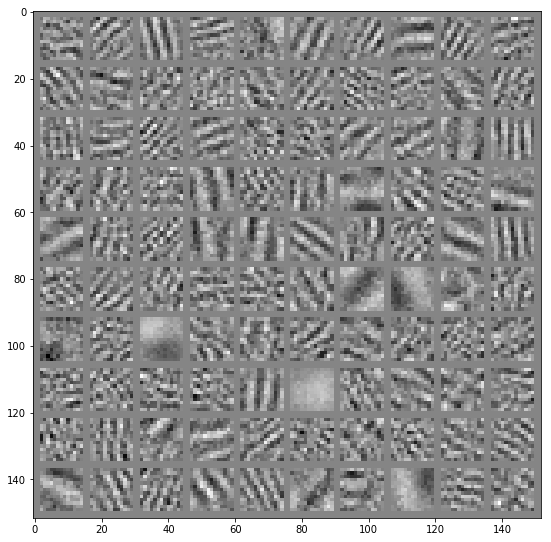

Epoch: 3500/20000 cost: 127.010575000
Epoch: 3501/20000 cost: 127.064800000
Epoch: 3502/20000 cost: 127.081412500
Epoch: 3503/20000 cost: 127.041725000
Epoch: 3504/20000 cost: 127.076600000
Epoch: 3505/20000 cost: 127.092450000
Epoch: 3506/20000 cost: 127.062937500
Epoch: 3507/20000 cost: 127.021100000
Epoch: 3508/20000 cost: 127.083075000
Epoch: 3509/20000 cost: 127.112350000
Epoch: 3510/20000 cost: 127.084800000
Epoch: 3511/20000 cost: 127.059225000
Epoch: 3512/20000 cost: 127.112875000
Epoch: 3513/20000 cost: 127.094212500
Epoch: 3514/20000 cost: 127.056950000
Epoch: 3515/20000 cost: 127.076350000
Epoch: 3516/20000 cost: 127.093775000
Epoch: 3517/20000 cost: 127.072987500
Epoch: 3518/20000 cost: 127.035400000
Epoch: 3519/20000 cost: 127.047662500
Epoch: 3520/20000 cost: 127.030262500
Epoch: 3521/20000 cost: 127.109425000
Epoch: 3522/20000 cost: 127.052975000
Epoch: 3523/20000 cost: 127.079000000
Epoch: 3524/20000 cost: 127.072137500
Epoch: 3525/20000 cost: 127.059525000
Epoch: 3526/

Epoch: 3716/20000 cost: 126.937225000
Epoch: 3717/20000 cost: 126.909375000
Epoch: 3718/20000 cost: 126.914750000
Epoch: 3719/20000 cost: 126.884650000
Epoch: 3720/20000 cost: 126.841287500
Epoch: 3721/20000 cost: 126.902525000
Epoch: 3722/20000 cost: 126.878962500
Epoch: 3723/20000 cost: 126.878375000
Epoch: 3724/20000 cost: 126.881575000
Epoch: 3725/20000 cost: 126.885925000
Epoch: 3726/20000 cost: 126.891150000
Epoch: 3727/20000 cost: 126.913925000
Epoch: 3728/20000 cost: 126.878550000
Epoch: 3729/20000 cost: 126.826475000
Epoch: 3730/20000 cost: 126.840225000
Epoch: 3731/20000 cost: 126.857437500
Epoch: 3732/20000 cost: 126.821625000
Epoch: 3733/20000 cost: 126.864575000
Epoch: 3734/20000 cost: 126.819450000
Epoch: 3735/20000 cost: 126.819725000
Epoch: 3736/20000 cost: 126.862562500
Epoch: 3737/20000 cost: 126.846775000
Epoch: 3738/20000 cost: 126.829050000
Epoch: 3739/20000 cost: 126.848550000
Epoch: 3740/20000 cost: 126.853850000
Epoch: 3741/20000 cost: 126.822425000
Epoch: 3742/

Epoch: 3934/20000 cost: 126.635300000
Epoch: 3935/20000 cost: 126.729825000
Epoch: 3936/20000 cost: 126.694925000
Epoch: 3937/20000 cost: 126.690075000
Epoch: 3938/20000 cost: 126.677325000
Epoch: 3939/20000 cost: 126.664950000
Epoch: 3940/20000 cost: 126.667000000
Epoch: 3941/20000 cost: 126.655837500
Epoch: 3942/20000 cost: 126.631887500
Epoch: 3943/20000 cost: 126.643850000
Epoch: 3944/20000 cost: 126.675175000
Epoch: 3945/20000 cost: 126.650600000
Epoch: 3946/20000 cost: 126.680937500
Epoch: 3947/20000 cost: 126.671500000
Epoch: 3948/20000 cost: 126.667650000
Epoch: 3949/20000 cost: 126.635712500
Epoch: 3950/20000 cost: 126.660775000
Epoch: 3951/20000 cost: 126.693275000
Epoch: 3952/20000 cost: 126.676625000
Epoch: 3953/20000 cost: 126.669400000
Epoch: 3954/20000 cost: 126.661375000
Epoch: 3955/20000 cost: 126.677700000
Epoch: 3956/20000 cost: 126.705087500
Epoch: 3957/20000 cost: 126.692000000
Epoch: 3958/20000 cost: 126.715075000
Epoch: 3959/20000 cost: 126.748450000
Epoch: 3960/

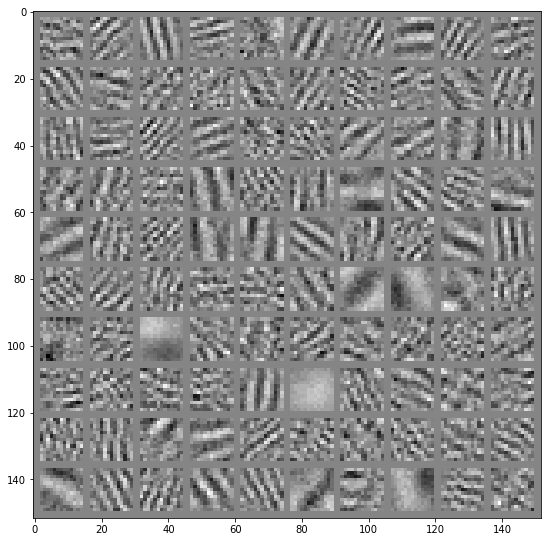

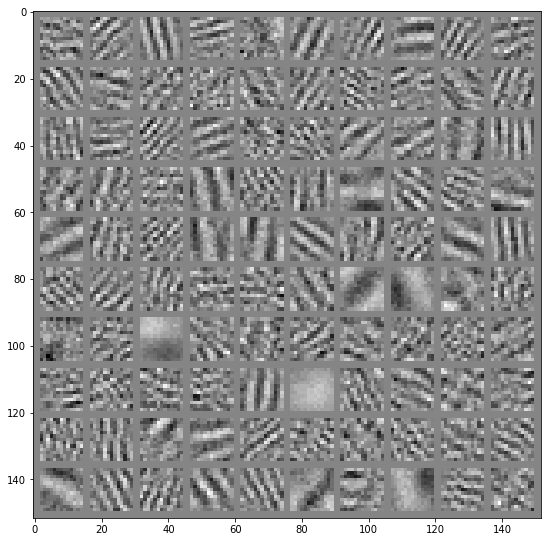

Epoch: 4000/20000 cost: 126.671875000
Epoch: 4001/20000 cost: 126.574975000
Epoch: 4002/20000 cost: 126.604612500
Epoch: 4003/20000 cost: 126.591975000
Epoch: 4004/20000 cost: 126.628200000
Epoch: 4005/20000 cost: 126.563775000
Epoch: 4006/20000 cost: 126.614987500
Epoch: 4007/20000 cost: 126.659425000
Epoch: 4008/20000 cost: 126.689425000
Epoch: 4009/20000 cost: 126.600050000
Epoch: 4010/20000 cost: 126.640075000
Epoch: 4011/20000 cost: 126.632150000
Epoch: 4012/20000 cost: 126.599150000
Epoch: 4013/20000 cost: 126.583600000
Epoch: 4014/20000 cost: 126.631525000
Epoch: 4015/20000 cost: 126.633625000
Epoch: 4016/20000 cost: 126.621762500
Epoch: 4017/20000 cost: 126.615437500
Epoch: 4018/20000 cost: 126.636012500
Epoch: 4019/20000 cost: 126.628687500
Epoch: 4020/20000 cost: 126.666800000
Epoch: 4021/20000 cost: 126.651512500
Epoch: 4022/20000 cost: 126.632050000
Epoch: 4023/20000 cost: 126.655825000
Epoch: 4024/20000 cost: 126.671600000
Epoch: 4025/20000 cost: 126.629775000
Epoch: 4026/

Epoch: 4216/20000 cost: 126.494262500
Epoch: 4217/20000 cost: 126.482900000
Epoch: 4218/20000 cost: 126.475125000
Epoch: 4219/20000 cost: 126.467975000
Epoch: 4220/20000 cost: 126.466750000
Epoch: 4221/20000 cost: 126.446775000
Epoch: 4222/20000 cost: 126.434587500
Epoch: 4223/20000 cost: 126.429525000
Epoch: 4224/20000 cost: 126.437487500
Epoch: 4225/20000 cost: 126.467975000
Epoch: 4226/20000 cost: 126.424500000
Epoch: 4227/20000 cost: 126.450625000
Epoch: 4228/20000 cost: 126.456150000
Epoch: 4229/20000 cost: 126.435950000
Epoch: 4230/20000 cost: 126.436175000
Epoch: 4231/20000 cost: 126.444800000
Epoch: 4232/20000 cost: 126.449425000
Epoch: 4233/20000 cost: 126.429887500
Epoch: 4234/20000 cost: 126.464462500
Epoch: 4235/20000 cost: 126.438925000
Epoch: 4236/20000 cost: 126.433075000
Epoch: 4237/20000 cost: 126.434075000
Epoch: 4238/20000 cost: 126.400650000
Epoch: 4239/20000 cost: 126.390025000
Epoch: 4240/20000 cost: 126.441300000
Epoch: 4241/20000 cost: 126.426412500
Epoch: 4242/

Epoch: 4434/20000 cost: 126.339125000
Epoch: 4435/20000 cost: 126.295087500
Epoch: 4436/20000 cost: 126.299575000
Epoch: 4437/20000 cost: 126.362625000
Epoch: 4438/20000 cost: 126.332675000
Epoch: 4439/20000 cost: 126.396825000
Epoch: 4440/20000 cost: 126.365275000
Epoch: 4441/20000 cost: 126.312425000
Epoch: 4442/20000 cost: 126.275725000
Epoch: 4443/20000 cost: 126.291137500
Epoch: 4444/20000 cost: 126.290925000
Epoch: 4445/20000 cost: 126.285825000
Epoch: 4446/20000 cost: 126.220875000
Epoch: 4447/20000 cost: 126.267487500
Epoch: 4448/20000 cost: 126.250287500
Epoch: 4449/20000 cost: 126.236925000
Epoch: 4450/20000 cost: 126.289000000
Epoch: 4451/20000 cost: 126.300175000
Epoch: 4452/20000 cost: 126.320200000
Epoch: 4453/20000 cost: 126.310625000
Epoch: 4454/20000 cost: 126.256000000
Epoch: 4455/20000 cost: 126.253975000
Epoch: 4456/20000 cost: 126.252450000
Epoch: 4457/20000 cost: 126.272937500
Epoch: 4458/20000 cost: 126.282775000
Epoch: 4459/20000 cost: 126.251650000
Epoch: 4460/

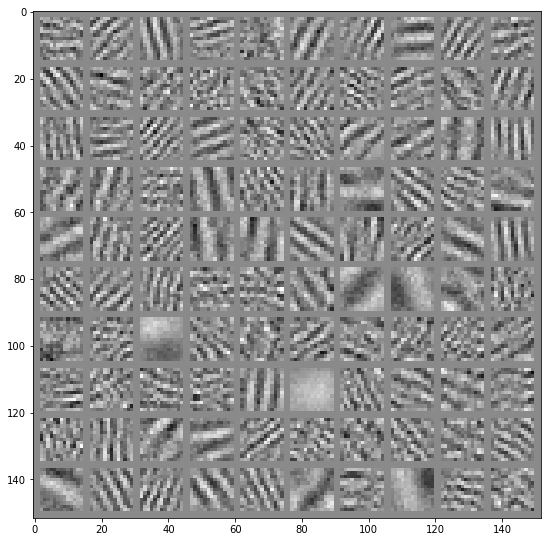

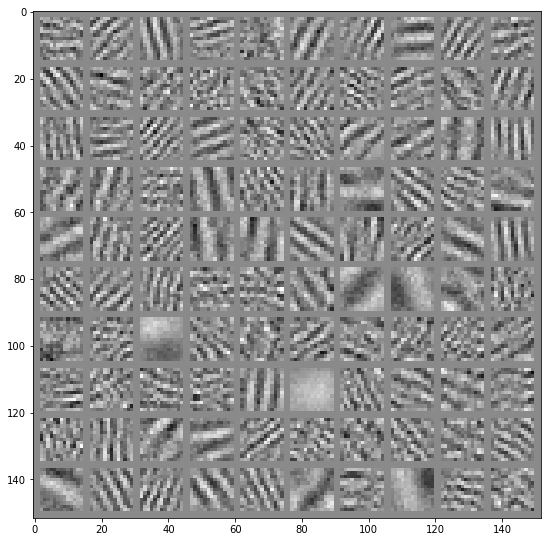

Epoch: 4500/20000 cost: 126.260087500
Epoch: 4501/20000 cost: 126.251675000
Epoch: 4502/20000 cost: 126.315100000
Epoch: 4503/20000 cost: 126.265525000
Epoch: 4504/20000 cost: 126.218712500
Epoch: 4505/20000 cost: 126.229650000
Epoch: 4506/20000 cost: 126.241175000
Epoch: 4507/20000 cost: 126.182087500
Epoch: 4508/20000 cost: 126.197700000
Epoch: 4509/20000 cost: 126.240200000
Epoch: 4510/20000 cost: 126.251575000
Epoch: 4511/20000 cost: 126.243937500
Epoch: 4512/20000 cost: 126.322300000
Epoch: 4513/20000 cost: 126.261550000
Epoch: 4514/20000 cost: 126.308600000
Epoch: 4515/20000 cost: 126.274525000
Epoch: 4516/20000 cost: 126.281062500
Epoch: 4517/20000 cost: 126.292700000
Epoch: 4518/20000 cost: 126.284175000
Epoch: 4519/20000 cost: 126.252275000
Epoch: 4520/20000 cost: 126.259862500
Epoch: 4521/20000 cost: 126.230600000
Epoch: 4522/20000 cost: 126.246975000
Epoch: 4523/20000 cost: 126.260550000
Epoch: 4524/20000 cost: 126.289100000
Epoch: 4525/20000 cost: 126.254700000
Epoch: 4526/

Epoch: 4716/20000 cost: 126.050712500
Epoch: 4717/20000 cost: 126.053025000
Epoch: 4718/20000 cost: 126.055300000
Epoch: 4719/20000 cost: 126.047650000
Epoch: 4720/20000 cost: 126.045000000
Epoch: 4721/20000 cost: 126.084150000
Epoch: 4722/20000 cost: 126.028200000
Epoch: 4723/20000 cost: 126.097975000
Epoch: 4724/20000 cost: 126.060387500
Epoch: 4725/20000 cost: 126.086075000
Epoch: 4726/20000 cost: 126.068637500
Epoch: 4727/20000 cost: 126.076200000
Epoch: 4728/20000 cost: 126.027725000
Epoch: 4729/20000 cost: 126.059012500
Epoch: 4730/20000 cost: 126.028125000
Epoch: 4731/20000 cost: 126.073375000
Epoch: 4732/20000 cost: 126.042187500
Epoch: 4733/20000 cost: 126.076975000
Epoch: 4734/20000 cost: 126.079937500
Epoch: 4735/20000 cost: 126.100025000
Epoch: 4736/20000 cost: 126.049975000
Epoch: 4737/20000 cost: 126.108075000
Epoch: 4738/20000 cost: 126.050737500
Epoch: 4739/20000 cost: 126.045600000
Epoch: 4740/20000 cost: 126.072900000
Epoch: 4741/20000 cost: 126.002200000
Epoch: 4742/

Epoch: 4933/20000 cost: 125.900650000
Epoch: 4934/20000 cost: 125.919837500
Epoch: 4935/20000 cost: 125.949800000
Epoch: 4936/20000 cost: 125.962700000
Epoch: 4937/20000 cost: 125.949150000
Epoch: 4938/20000 cost: 125.954500000
Epoch: 4939/20000 cost: 125.957462500
Epoch: 4940/20000 cost: 125.909200000
Epoch: 4941/20000 cost: 125.952587500
Epoch: 4942/20000 cost: 125.939250000
Epoch: 4943/20000 cost: 125.953950000
Epoch: 4944/20000 cost: 125.911125000
Epoch: 4945/20000 cost: 125.959700000
Epoch: 4946/20000 cost: 125.943487500
Epoch: 4947/20000 cost: 125.921325000
Epoch: 4948/20000 cost: 125.892775000
Epoch: 4949/20000 cost: 125.896100000
Epoch: 4950/20000 cost: 125.920850000
Epoch: 4951/20000 cost: 125.919625000
Epoch: 4952/20000 cost: 125.887575000
Epoch: 4953/20000 cost: 125.885850000
Epoch: 4954/20000 cost: 125.937812500
Epoch: 4955/20000 cost: 125.948587500
Epoch: 4956/20000 cost: 125.868625000
Epoch: 4957/20000 cost: 125.835425000
Epoch: 4958/20000 cost: 125.854475000
Epoch: 4959/

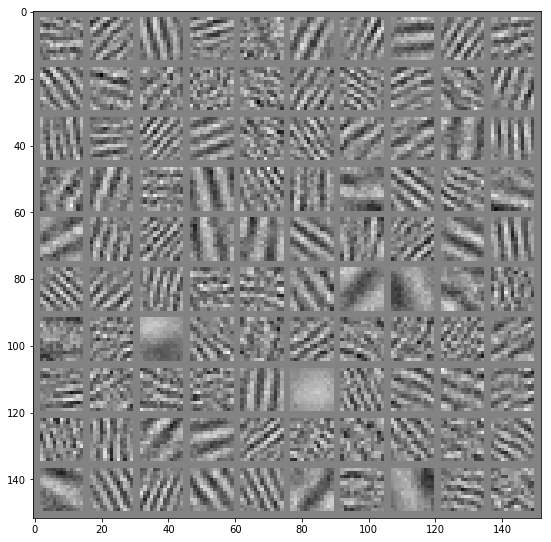

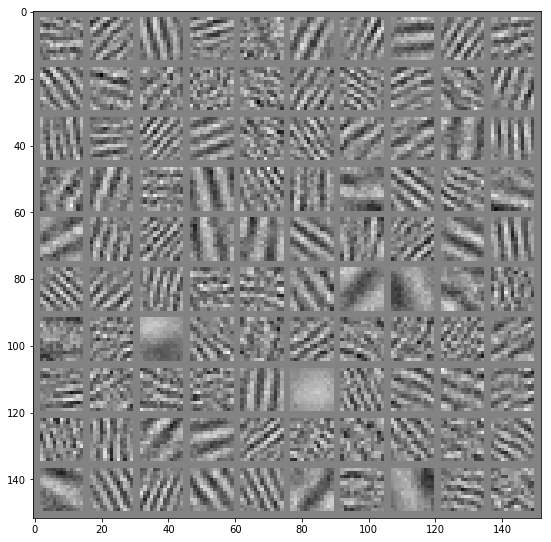

Epoch: 5000/20000 cost: 125.918525000
Epoch: 5001/20000 cost: 125.860400000
Epoch: 5002/20000 cost: 125.873325000
Epoch: 5003/20000 cost: 125.867175000
Epoch: 5004/20000 cost: 125.854750000
Epoch: 5005/20000 cost: 125.848700000
Epoch: 5006/20000 cost: 125.831275000
Epoch: 5007/20000 cost: 125.860650000
Epoch: 5008/20000 cost: 125.837525000
Epoch: 5009/20000 cost: 125.849362500
Epoch: 5010/20000 cost: 125.773300000
Epoch: 5011/20000 cost: 125.803975000
Epoch: 5012/20000 cost: 125.792475000
Epoch: 5013/20000 cost: 125.835325000
Epoch: 5014/20000 cost: 125.842825000
Epoch: 5015/20000 cost: 125.862762500
Epoch: 5016/20000 cost: 125.858575000
Epoch: 5017/20000 cost: 125.829387500
Epoch: 5018/20000 cost: 125.839775000
Epoch: 5019/20000 cost: 125.861725000
Epoch: 5020/20000 cost: 125.832925000
Epoch: 5021/20000 cost: 125.856675000
Epoch: 5022/20000 cost: 125.843300000
Epoch: 5023/20000 cost: 125.868400000
Epoch: 5024/20000 cost: 125.837375000
Epoch: 5025/20000 cost: 125.760062500
Epoch: 5026/

Epoch: 5218/20000 cost: 125.744087500
Epoch: 5219/20000 cost: 125.716700000
Epoch: 5220/20000 cost: 125.711787500
Epoch: 5221/20000 cost: 125.716925000
Epoch: 5222/20000 cost: 125.713350000
Epoch: 5223/20000 cost: 125.702350000
Epoch: 5224/20000 cost: 125.710387500
Epoch: 5225/20000 cost: 125.725250000
Epoch: 5226/20000 cost: 125.734062500
Epoch: 5227/20000 cost: 125.721750000
Epoch: 5228/20000 cost: 125.714025000
Epoch: 5229/20000 cost: 125.716150000
Epoch: 5230/20000 cost: 125.734050000
Epoch: 5231/20000 cost: 125.741700000
Epoch: 5232/20000 cost: 125.686012500
Epoch: 5233/20000 cost: 125.747662500
Epoch: 5234/20000 cost: 125.705700000
Epoch: 5235/20000 cost: 125.679775000
Epoch: 5236/20000 cost: 125.747650000
Epoch: 5237/20000 cost: 125.707300000
Epoch: 5238/20000 cost: 125.698100000
Epoch: 5239/20000 cost: 125.689862500
Epoch: 5240/20000 cost: 125.722875000
Epoch: 5241/20000 cost: 125.617275000
Epoch: 5242/20000 cost: 125.672325000
Epoch: 5243/20000 cost: 125.706487500
Epoch: 5244/

Epoch: 5434/20000 cost: 125.554825000
Epoch: 5435/20000 cost: 125.491050000
Epoch: 5436/20000 cost: 125.537487500
Epoch: 5437/20000 cost: 125.548637500
Epoch: 5438/20000 cost: 125.577087500
Epoch: 5439/20000 cost: 125.549087500
Epoch: 5440/20000 cost: 125.532300000
Epoch: 5441/20000 cost: 125.534987500
Epoch: 5442/20000 cost: 125.546450000
Epoch: 5443/20000 cost: 125.558387500
Epoch: 5444/20000 cost: 125.569700000
Epoch: 5445/20000 cost: 125.550150000
Epoch: 5446/20000 cost: 125.602125000
Epoch: 5447/20000 cost: 125.571850000
Epoch: 5448/20000 cost: 125.628725000
Epoch: 5449/20000 cost: 125.558725000
Epoch: 5450/20000 cost: 125.564750000
Epoch: 5451/20000 cost: 125.536450000
Epoch: 5452/20000 cost: 125.531087500
Epoch: 5453/20000 cost: 125.584450000
Epoch: 5454/20000 cost: 125.537537500
Epoch: 5455/20000 cost: 125.531100000
Epoch: 5456/20000 cost: 125.573525000
Epoch: 5457/20000 cost: 125.583750000
Epoch: 5458/20000 cost: 125.635600000
Epoch: 5459/20000 cost: 125.639862500
Epoch: 5460/

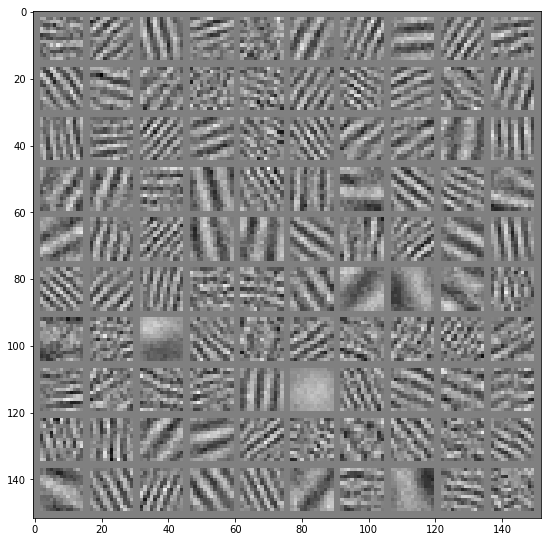

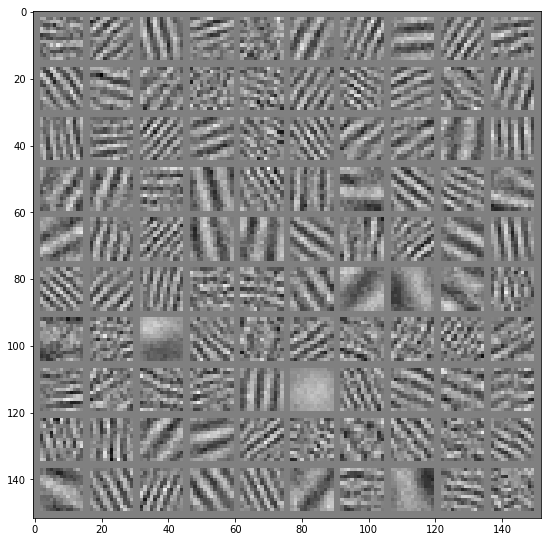

Epoch: 5500/20000 cost: 125.523512500
Epoch: 5501/20000 cost: 125.501475000
Epoch: 5502/20000 cost: 125.553937500
Epoch: 5503/20000 cost: 125.591812500
Epoch: 5504/20000 cost: 125.539925000
Epoch: 5505/20000 cost: 125.570387500
Epoch: 5506/20000 cost: 125.499800000
Epoch: 5507/20000 cost: 125.553862500
Epoch: 5508/20000 cost: 125.565650000
Epoch: 5509/20000 cost: 125.540287500
Epoch: 5510/20000 cost: 125.626100000
Epoch: 5511/20000 cost: 125.578937500
Epoch: 5512/20000 cost: 125.622687500
Epoch: 5513/20000 cost: 125.508150000
Epoch: 5514/20000 cost: 125.536512500
Epoch: 5515/20000 cost: 125.488162500
Epoch: 5516/20000 cost: 125.494362500
Epoch: 5517/20000 cost: 125.544287500
Epoch: 5518/20000 cost: 125.514887500
Epoch: 5519/20000 cost: 125.488000000
Epoch: 5520/20000 cost: 125.525975000
Epoch: 5521/20000 cost: 125.483925000
Epoch: 5522/20000 cost: 125.530212500
Epoch: 5523/20000 cost: 125.510700000
Epoch: 5524/20000 cost: 125.517200000
Epoch: 5525/20000 cost: 125.502550000
Epoch: 5526/

Epoch: 5716/20000 cost: 125.392650000
Epoch: 5717/20000 cost: 125.465837500
Epoch: 5718/20000 cost: 125.382387500
Epoch: 5719/20000 cost: 125.458850000
Epoch: 5720/20000 cost: 125.430362500
Epoch: 5721/20000 cost: 125.370725000
Epoch: 5722/20000 cost: 125.377900000
Epoch: 5723/20000 cost: 125.393787500
Epoch: 5724/20000 cost: 125.406400000
Epoch: 5725/20000 cost: 125.370475000
Epoch: 5726/20000 cost: 125.394975000
Epoch: 5727/20000 cost: 125.378600000
Epoch: 5728/20000 cost: 125.399775000
Epoch: 5729/20000 cost: 125.369837500
Epoch: 5730/20000 cost: 125.422300000
Epoch: 5731/20000 cost: 125.425925000
Epoch: 5732/20000 cost: 125.404912500
Epoch: 5733/20000 cost: 125.403712500
Epoch: 5734/20000 cost: 125.422125000
Epoch: 5735/20000 cost: 125.435375000
Epoch: 5736/20000 cost: 125.415012500
Epoch: 5737/20000 cost: 125.387425000
Epoch: 5738/20000 cost: 125.353350000
Epoch: 5739/20000 cost: 125.375475000
Epoch: 5740/20000 cost: 125.375087500
Epoch: 5741/20000 cost: 125.368475000
Epoch: 5742/

Epoch: 5934/20000 cost: 125.226000000
Epoch: 5935/20000 cost: 125.237112500
Epoch: 5936/20000 cost: 125.212087500
Epoch: 5937/20000 cost: 125.229900000
Epoch: 5938/20000 cost: 125.256450000
Epoch: 5939/20000 cost: 125.288050000
Epoch: 5940/20000 cost: 125.302225000
Epoch: 5941/20000 cost: 125.322350000
Epoch: 5942/20000 cost: 125.253987500
Epoch: 5943/20000 cost: 125.316937500
Epoch: 5944/20000 cost: 125.281750000
Epoch: 5945/20000 cost: 125.300700000
Epoch: 5946/20000 cost: 125.256775000
Epoch: 5947/20000 cost: 125.220075000
Epoch: 5948/20000 cost: 125.303275000
Epoch: 5949/20000 cost: 125.246062500
Epoch: 5950/20000 cost: 125.210175000
Epoch: 5951/20000 cost: 125.245150000
Epoch: 5952/20000 cost: 125.219462500
Epoch: 5953/20000 cost: 125.256625000
Epoch: 5954/20000 cost: 125.219312500
Epoch: 5955/20000 cost: 125.214225000
Epoch: 5956/20000 cost: 125.269475000
Epoch: 5957/20000 cost: 125.253762500
Epoch: 5958/20000 cost: 125.237950000
Epoch: 5959/20000 cost: 125.279575000
Epoch: 5960/

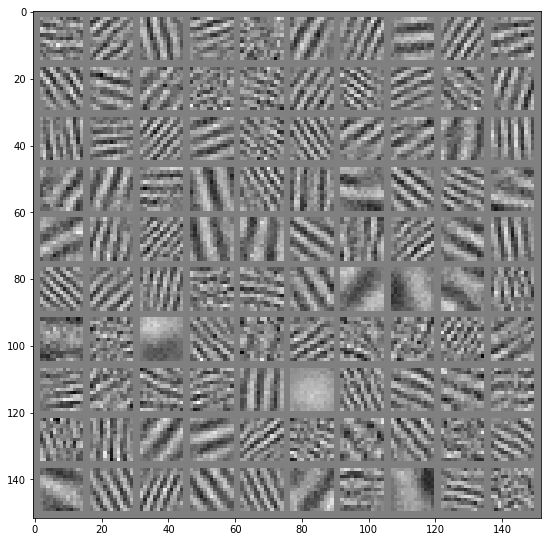

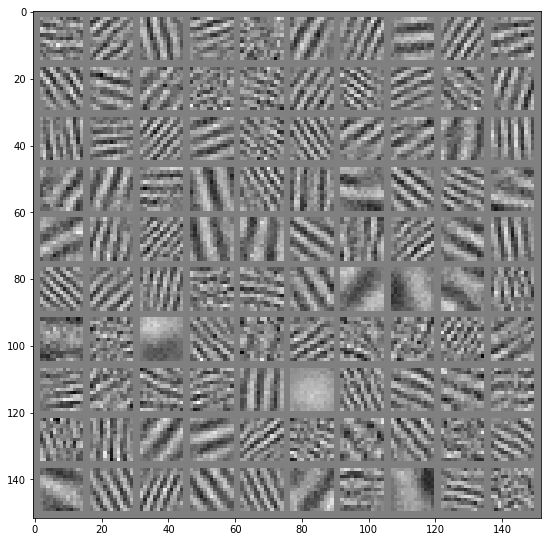

Epoch: 6000/20000 cost: 125.240250000
Epoch: 6001/20000 cost: 125.183625000
Epoch: 6002/20000 cost: 125.188475000
Epoch: 6003/20000 cost: 125.208300000
Epoch: 6004/20000 cost: 125.241750000
Epoch: 6005/20000 cost: 125.223825000
Epoch: 6006/20000 cost: 125.238537500
Epoch: 6007/20000 cost: 125.153212500
Epoch: 6008/20000 cost: 125.162112500
Epoch: 6009/20000 cost: 125.179937500
Epoch: 6010/20000 cost: 125.156662500
Epoch: 6011/20000 cost: 125.210800000
Epoch: 6012/20000 cost: 125.167625000
Epoch: 6013/20000 cost: 125.182350000
Epoch: 6014/20000 cost: 125.190875000
Epoch: 6015/20000 cost: 125.158650000
Epoch: 6016/20000 cost: 125.224400000
Epoch: 6017/20000 cost: 125.176362500
Epoch: 6018/20000 cost: 125.196412500
Epoch: 6019/20000 cost: 125.161275000
Epoch: 6020/20000 cost: 125.172575000
Epoch: 6021/20000 cost: 125.204925000
Epoch: 6022/20000 cost: 125.219387500
Epoch: 6023/20000 cost: 125.220725000
Epoch: 6024/20000 cost: 125.241325000
Epoch: 6025/20000 cost: 125.201387500
Epoch: 6026/

Epoch: 6216/20000 cost: 125.091875000
Epoch: 6217/20000 cost: 125.117150000
Epoch: 6218/20000 cost: 125.054250000
Epoch: 6219/20000 cost: 125.026675000
Epoch: 6220/20000 cost: 125.050275000
Epoch: 6221/20000 cost: 125.064975000
Epoch: 6222/20000 cost: 125.057025000
Epoch: 6223/20000 cost: 125.102312500
Epoch: 6224/20000 cost: 125.087625000
Epoch: 6225/20000 cost: 125.084775000
Epoch: 6226/20000 cost: 125.130087500
Epoch: 6227/20000 cost: 125.091400000
Epoch: 6228/20000 cost: 125.113150000
Epoch: 6229/20000 cost: 125.063625000
Epoch: 6230/20000 cost: 125.121450000
Epoch: 6231/20000 cost: 125.040537500
Epoch: 6232/20000 cost: 125.097175000
Epoch: 6233/20000 cost: 125.077375000
Epoch: 6234/20000 cost: 125.018400000
Epoch: 6235/20000 cost: 125.024912500
Epoch: 6236/20000 cost: 125.063125000
Epoch: 6237/20000 cost: 125.039825000
Epoch: 6238/20000 cost: 125.021450000
Epoch: 6239/20000 cost: 125.047475000
Epoch: 6240/20000 cost: 125.037925000
Epoch: 6241/20000 cost: 125.098475000
Epoch: 6242/

Epoch: 6433/20000 cost: 124.924350000
Epoch: 6434/20000 cost: 124.952625000
Epoch: 6435/20000 cost: 124.951875000
Epoch: 6436/20000 cost: 124.959937500
Epoch: 6437/20000 cost: 124.954775000
Epoch: 6438/20000 cost: 124.993275000
Epoch: 6439/20000 cost: 124.939500000
Epoch: 6440/20000 cost: 124.957525000
Epoch: 6441/20000 cost: 124.988075000
Epoch: 6442/20000 cost: 124.915075000
Epoch: 6443/20000 cost: 124.955237500
Epoch: 6444/20000 cost: 124.931700000
Epoch: 6445/20000 cost: 124.915012500
Epoch: 6446/20000 cost: 124.945600000
Epoch: 6447/20000 cost: 124.926175000
Epoch: 6448/20000 cost: 124.974600000
Epoch: 6449/20000 cost: 124.992925000
Epoch: 6450/20000 cost: 124.983375000
Epoch: 6451/20000 cost: 125.020050000
Epoch: 6452/20000 cost: 125.020237500
Epoch: 6453/20000 cost: 125.028125000
Epoch: 6454/20000 cost: 124.971825000
Epoch: 6455/20000 cost: 124.975825000
Epoch: 6456/20000 cost: 124.934512500
Epoch: 6457/20000 cost: 124.910775000
Epoch: 6458/20000 cost: 124.935987500
Epoch: 6459/

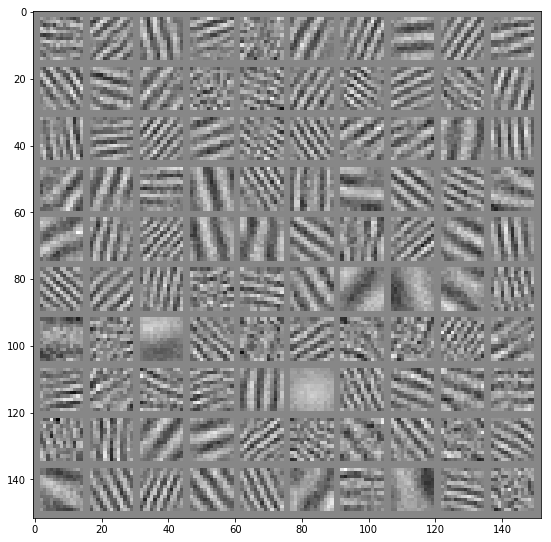

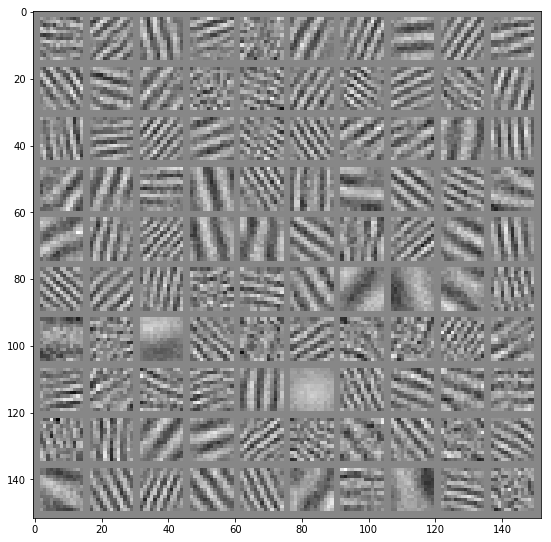

Epoch: 6500/20000 cost: 124.953775000
Epoch: 6501/20000 cost: 124.929025000
Epoch: 6502/20000 cost: 124.959725000
Epoch: 6503/20000 cost: 124.964600000
Epoch: 6504/20000 cost: 124.936662500
Epoch: 6505/20000 cost: 124.958300000
Epoch: 6506/20000 cost: 124.923725000
Epoch: 6507/20000 cost: 124.938975000
Epoch: 6508/20000 cost: 124.904200000
Epoch: 6509/20000 cost: 124.941237500
Epoch: 6510/20000 cost: 124.947350000
Epoch: 6511/20000 cost: 124.940275000
Epoch: 6512/20000 cost: 124.948925000
Epoch: 6513/20000 cost: 124.961150000
Epoch: 6514/20000 cost: 124.959750000
Epoch: 6515/20000 cost: 124.911000000
Epoch: 6516/20000 cost: 124.901500000
Epoch: 6517/20000 cost: 124.945837500
Epoch: 6518/20000 cost: 124.887962500
Epoch: 6519/20000 cost: 124.890700000
Epoch: 6520/20000 cost: 124.868650000
Epoch: 6521/20000 cost: 124.881350000
Epoch: 6522/20000 cost: 124.866412500
Epoch: 6523/20000 cost: 124.928950000
Epoch: 6524/20000 cost: 124.933112500
Epoch: 6525/20000 cost: 124.944200000
Epoch: 6526/

Epoch: 6718/20000 cost: 124.868487500
Epoch: 6719/20000 cost: 124.910675000
Epoch: 6720/20000 cost: 124.884700000
Epoch: 6721/20000 cost: 124.893200000
Epoch: 6722/20000 cost: 124.860975000
Epoch: 6723/20000 cost: 124.857962500
Epoch: 6724/20000 cost: 124.806825000
Epoch: 6725/20000 cost: 124.880375000
Epoch: 6726/20000 cost: 124.840825000
Epoch: 6727/20000 cost: 124.835675000
Epoch: 6728/20000 cost: 124.892187500
Epoch: 6729/20000 cost: 124.856687500
Epoch: 6730/20000 cost: 124.831787500
Epoch: 6731/20000 cost: 124.821550000
Epoch: 6732/20000 cost: 124.793825000
Epoch: 6733/20000 cost: 124.803325000
Epoch: 6734/20000 cost: 124.807575000
Epoch: 6735/20000 cost: 124.801662500
Epoch: 6736/20000 cost: 124.785200000
Epoch: 6737/20000 cost: 124.791212500
Epoch: 6738/20000 cost: 124.848275000
Epoch: 6739/20000 cost: 124.831600000
Epoch: 6740/20000 cost: 124.863725000
Epoch: 6741/20000 cost: 124.819250000
Epoch: 6742/20000 cost: 124.838937500
Epoch: 6743/20000 cost: 124.851350000
Epoch: 6744/

Epoch: 6934/20000 cost: 124.742625000
Epoch: 6935/20000 cost: 124.770912500
Epoch: 6936/20000 cost: 124.712525000
Epoch: 6937/20000 cost: 124.802062500
Epoch: 6938/20000 cost: 124.764450000
Epoch: 6939/20000 cost: 124.784462500
Epoch: 6940/20000 cost: 124.739950000
Epoch: 6941/20000 cost: 124.739387500
Epoch: 6942/20000 cost: 124.753212500
Epoch: 6943/20000 cost: 124.778537500
Epoch: 6944/20000 cost: 124.705137500
Epoch: 6945/20000 cost: 124.793587500
Epoch: 6946/20000 cost: 124.739250000
Epoch: 6947/20000 cost: 124.678525000
Epoch: 6948/20000 cost: 124.762875000
Epoch: 6949/20000 cost: 124.749400000
Epoch: 6950/20000 cost: 124.758775000
Epoch: 6951/20000 cost: 124.721987500
Epoch: 6952/20000 cost: 124.714737500
Epoch: 6953/20000 cost: 124.738250000
Epoch: 6954/20000 cost: 124.756612500
Epoch: 6955/20000 cost: 124.755837500
Epoch: 6956/20000 cost: 124.768137500
Epoch: 6957/20000 cost: 124.751287500
Epoch: 6958/20000 cost: 124.801050000
Epoch: 6959/20000 cost: 124.762300000
Epoch: 6960/

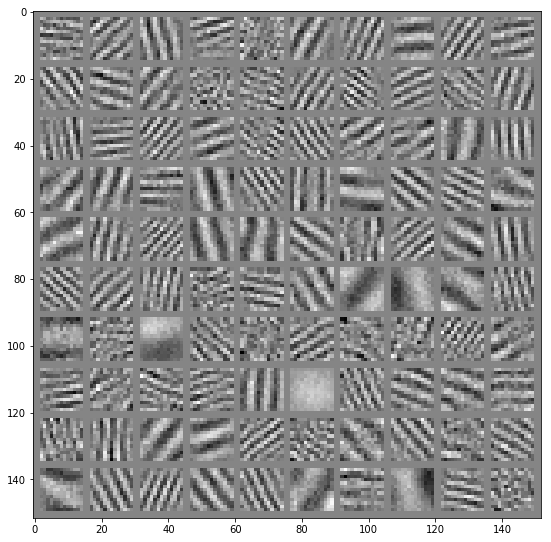

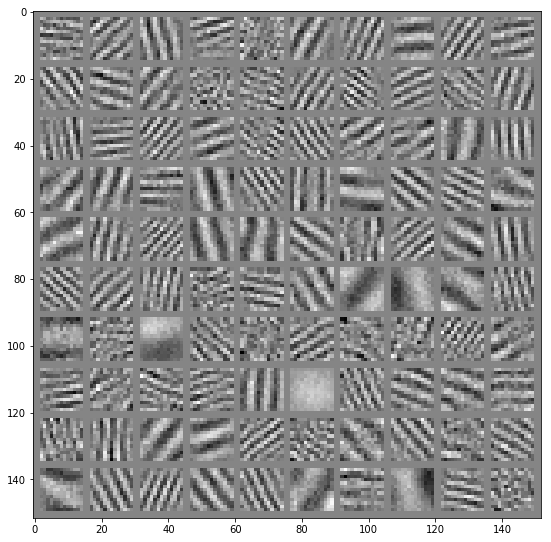

Epoch: 7000/20000 cost: 124.712150000
Epoch: 7001/20000 cost: 124.712437500
Epoch: 7002/20000 cost: 124.704600000
Epoch: 7003/20000 cost: 124.708000000
Epoch: 7004/20000 cost: 124.712650000
Epoch: 7005/20000 cost: 124.707412500
Epoch: 7006/20000 cost: 124.688500000
Epoch: 7007/20000 cost: 124.668475000
Epoch: 7008/20000 cost: 124.679425000
Epoch: 7009/20000 cost: 124.688362500
Epoch: 7010/20000 cost: 124.670825000
Epoch: 7011/20000 cost: 124.681250000
Epoch: 7012/20000 cost: 124.712562500
Epoch: 7013/20000 cost: 124.748137500
Epoch: 7014/20000 cost: 124.748275000
Epoch: 7015/20000 cost: 124.799537500
Epoch: 7016/20000 cost: 124.788600000
Epoch: 7017/20000 cost: 124.785075000
Epoch: 7018/20000 cost: 124.727175000
Epoch: 7019/20000 cost: 124.800337500
Epoch: 7020/20000 cost: 124.772675000
Epoch: 7021/20000 cost: 124.802275000
Epoch: 7022/20000 cost: 124.726500000
Epoch: 7023/20000 cost: 124.751525000
Epoch: 7024/20000 cost: 124.668550000
Epoch: 7025/20000 cost: 124.674450000
Epoch: 7026/

Epoch: 7218/20000 cost: 124.711975000
Epoch: 7219/20000 cost: 124.698875000
Epoch: 7220/20000 cost: 124.635425000
Epoch: 7221/20000 cost: 124.645812500
Epoch: 7222/20000 cost: 124.608575000
Epoch: 7223/20000 cost: 124.615712500
Epoch: 7224/20000 cost: 124.609062500
Epoch: 7225/20000 cost: 124.598150000
Epoch: 7226/20000 cost: 124.627600000
Epoch: 7227/20000 cost: 124.652175000
Epoch: 7228/20000 cost: 124.642262500
Epoch: 7229/20000 cost: 124.620275000
Epoch: 7230/20000 cost: 124.614175000
Epoch: 7231/20000 cost: 124.627712500
Epoch: 7232/20000 cost: 124.683325000
Epoch: 7233/20000 cost: 124.650562500
Epoch: 7234/20000 cost: 124.638025000
Epoch: 7235/20000 cost: 124.648375000
Epoch: 7236/20000 cost: 124.543537500
Epoch: 7237/20000 cost: 124.547962500
Epoch: 7238/20000 cost: 124.602850000
Epoch: 7239/20000 cost: 124.632300000
Epoch: 7240/20000 cost: 124.610212500
Epoch: 7241/20000 cost: 124.588837500
Epoch: 7242/20000 cost: 124.631600000
Epoch: 7243/20000 cost: 124.626100000
Epoch: 7244/

Epoch: 7434/20000 cost: 124.501625000
Epoch: 7435/20000 cost: 124.538225000
Epoch: 7436/20000 cost: 124.568625000
Epoch: 7437/20000 cost: 124.529525000
Epoch: 7438/20000 cost: 124.526150000
Epoch: 7439/20000 cost: 124.550825000
Epoch: 7440/20000 cost: 124.549775000
Epoch: 7441/20000 cost: 124.551837500
Epoch: 7442/20000 cost: 124.568487500
Epoch: 7443/20000 cost: 124.487937500
Epoch: 7444/20000 cost: 124.521862500
Epoch: 7445/20000 cost: 124.542225000
Epoch: 7446/20000 cost: 124.528387500
Epoch: 7447/20000 cost: 124.544875000
Epoch: 7448/20000 cost: 124.621375000
Epoch: 7449/20000 cost: 124.502975000
Epoch: 7450/20000 cost: 124.531425000
Epoch: 7451/20000 cost: 124.513400000
Epoch: 7452/20000 cost: 124.568862500
Epoch: 7453/20000 cost: 124.597387500
Epoch: 7454/20000 cost: 124.537400000
Epoch: 7455/20000 cost: 124.484300000
Epoch: 7456/20000 cost: 124.501275000
Epoch: 7457/20000 cost: 124.479900000
Epoch: 7458/20000 cost: 124.471100000
Epoch: 7459/20000 cost: 124.467450000
Epoch: 7460/

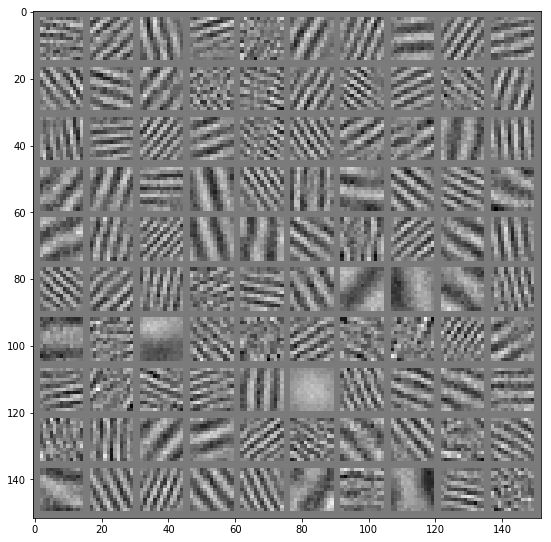

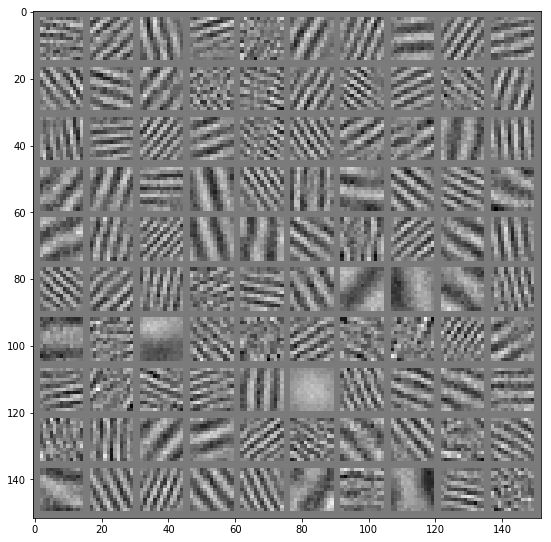

Epoch: 7500/20000 cost: 124.515375000
Epoch: 7501/20000 cost: 124.510462500
Epoch: 7502/20000 cost: 124.541325000
Epoch: 7503/20000 cost: 124.547300000
Epoch: 7504/20000 cost: 124.454600000
Epoch: 7505/20000 cost: 124.519925000
Epoch: 7506/20000 cost: 124.496175000
Epoch: 7507/20000 cost: 124.494300000
Epoch: 7508/20000 cost: 124.507300000
Epoch: 7509/20000 cost: 124.588237500
Epoch: 7510/20000 cost: 124.548762500
Epoch: 7511/20000 cost: 124.601162500
Epoch: 7512/20000 cost: 124.558075000
Epoch: 7513/20000 cost: 124.502575000
Epoch: 7514/20000 cost: 124.492425000
Epoch: 7515/20000 cost: 124.539700000
Epoch: 7516/20000 cost: 124.474862500
Epoch: 7517/20000 cost: 124.498050000
Epoch: 7518/20000 cost: 124.496050000
Epoch: 7519/20000 cost: 124.544475000
Epoch: 7520/20000 cost: 124.512100000
Epoch: 7521/20000 cost: 124.512187500
Epoch: 7522/20000 cost: 124.529175000
Epoch: 7523/20000 cost: 124.550500000
Epoch: 7524/20000 cost: 124.528575000
Epoch: 7525/20000 cost: 124.603800000
Epoch: 7526/

Epoch: 7717/20000 cost: 124.528975000
Epoch: 7718/20000 cost: 124.484350000
Epoch: 7719/20000 cost: 124.464250000
Epoch: 7720/20000 cost: 124.416075000
Epoch: 7721/20000 cost: 124.513275000
Epoch: 7722/20000 cost: 124.540150000
Epoch: 7723/20000 cost: 124.500712500
Epoch: 7724/20000 cost: 124.511550000
Epoch: 7725/20000 cost: 124.530200000
Epoch: 7726/20000 cost: 124.477562500
Epoch: 7727/20000 cost: 124.517250000
Epoch: 7728/20000 cost: 124.506075000
Epoch: 7729/20000 cost: 124.457037500
Epoch: 7730/20000 cost: 124.449262500
Epoch: 7731/20000 cost: 124.500625000
Epoch: 7732/20000 cost: 124.440550000
Epoch: 7733/20000 cost: 124.497475000
Epoch: 7734/20000 cost: 124.500300000
Epoch: 7735/20000 cost: 124.486262500
Epoch: 7736/20000 cost: 124.472300000
Epoch: 7737/20000 cost: 124.539662500
Epoch: 7738/20000 cost: 124.491162500
Epoch: 7739/20000 cost: 124.514150000
Epoch: 7740/20000 cost: 124.472412500
Epoch: 7741/20000 cost: 124.476100000
Epoch: 7742/20000 cost: 124.473825000
Epoch: 7743/

Epoch: 7935/20000 cost: 124.465400000
Epoch: 7936/20000 cost: 124.465425000
Epoch: 7937/20000 cost: 124.389425000
Epoch: 7938/20000 cost: 124.456587500
Epoch: 7939/20000 cost: 124.440325000
Epoch: 7940/20000 cost: 124.429325000
Epoch: 7941/20000 cost: 124.443600000
Epoch: 7942/20000 cost: 124.385150000
Epoch: 7943/20000 cost: 124.403750000
Epoch: 7944/20000 cost: 124.366912500
Epoch: 7945/20000 cost: 124.353962500
Epoch: 7946/20000 cost: 124.400875000
Epoch: 7947/20000 cost: 124.431775000
Epoch: 7948/20000 cost: 124.456162500
Epoch: 7949/20000 cost: 124.451575000
Epoch: 7950/20000 cost: 124.482975000
Epoch: 7951/20000 cost: 124.429300000
Epoch: 7952/20000 cost: 124.429900000
Epoch: 7953/20000 cost: 124.427225000
Epoch: 7954/20000 cost: 124.418337500
Epoch: 7955/20000 cost: 124.433450000
Epoch: 7956/20000 cost: 124.492875000
Epoch: 7957/20000 cost: 124.435737500
Epoch: 7958/20000 cost: 124.421837500
Epoch: 7959/20000 cost: 124.426312500
Epoch: 7960/20000 cost: 124.441925000
Epoch: 7961/

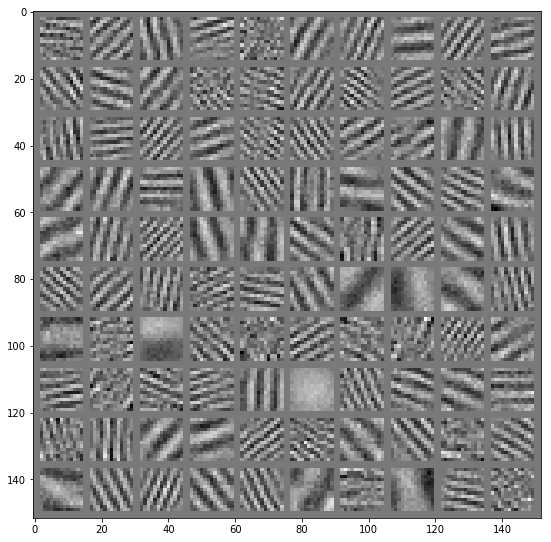

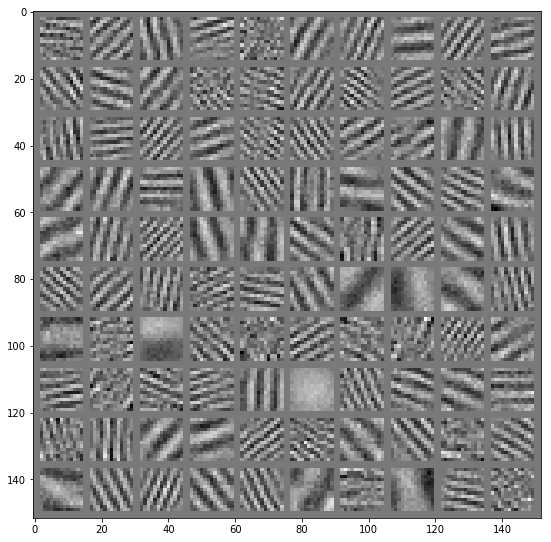

Epoch: 8000/20000 cost: 124.384900000
Epoch: 8001/20000 cost: 124.388587500
Epoch: 8002/20000 cost: 124.400550000
Epoch: 8003/20000 cost: 124.369775000
Epoch: 8004/20000 cost: 124.367237500
Epoch: 8005/20000 cost: 124.399137500
Epoch: 8006/20000 cost: 124.412825000
Epoch: 8007/20000 cost: 124.420100000
Epoch: 8008/20000 cost: 124.425837500
Epoch: 8009/20000 cost: 124.406350000
Epoch: 8010/20000 cost: 124.416512500
Epoch: 8011/20000 cost: 124.452987500
Epoch: 8012/20000 cost: 124.417212500
Epoch: 8013/20000 cost: 124.419950000
Epoch: 8014/20000 cost: 124.410962500
Epoch: 8015/20000 cost: 124.412712500
Epoch: 8016/20000 cost: 124.385200000
Epoch: 8017/20000 cost: 124.461650000
Epoch: 8018/20000 cost: 124.370975000
Epoch: 8019/20000 cost: 124.407150000
Epoch: 8020/20000 cost: 124.402275000
Epoch: 8021/20000 cost: 124.412725000
Epoch: 8022/20000 cost: 124.407100000
Epoch: 8023/20000 cost: 124.412137500
Epoch: 8024/20000 cost: 124.411362500
Epoch: 8025/20000 cost: 124.402300000
Epoch: 8026/

Epoch: 8217/20000 cost: 124.335725000
Epoch: 8218/20000 cost: 124.355975000
Epoch: 8219/20000 cost: 124.311500000
Epoch: 8220/20000 cost: 124.361700000
Epoch: 8221/20000 cost: 124.393025000
Epoch: 8222/20000 cost: 124.350575000
Epoch: 8223/20000 cost: 124.357975000
Epoch: 8224/20000 cost: 124.364800000
Epoch: 8225/20000 cost: 124.290900000
Epoch: 8226/20000 cost: 124.282575000
Epoch: 8227/20000 cost: 124.292425000
Epoch: 8228/20000 cost: 124.286850000
Epoch: 8229/20000 cost: 124.335700000
Epoch: 8230/20000 cost: 124.307300000
Epoch: 8231/20000 cost: 124.375325000
Epoch: 8232/20000 cost: 124.338287500
Epoch: 8233/20000 cost: 124.311825000
Epoch: 8234/20000 cost: 124.330600000
Epoch: 8235/20000 cost: 124.350512500
Epoch: 8236/20000 cost: 124.291275000
Epoch: 8237/20000 cost: 124.375512500
Epoch: 8238/20000 cost: 124.329262500
Epoch: 8239/20000 cost: 124.326450000
Epoch: 8240/20000 cost: 124.300987500
Epoch: 8241/20000 cost: 124.344175000
Epoch: 8242/20000 cost: 124.298050000
Epoch: 8243/

Epoch: 8435/20000 cost: 124.284512500
Epoch: 8436/20000 cost: 124.274925000
Epoch: 8437/20000 cost: 124.283575000
Epoch: 8438/20000 cost: 124.323062500
Epoch: 8439/20000 cost: 124.307087500
Epoch: 8440/20000 cost: 124.321450000
Epoch: 8441/20000 cost: 124.281012500
Epoch: 8442/20000 cost: 124.295975000
Epoch: 8443/20000 cost: 124.264962500
Epoch: 8444/20000 cost: 124.233650000
Epoch: 8445/20000 cost: 124.235675000
Epoch: 8446/20000 cost: 124.240412500
Epoch: 8447/20000 cost: 124.276112500
Epoch: 8448/20000 cost: 124.245875000
Epoch: 8449/20000 cost: 124.283862500
Epoch: 8450/20000 cost: 124.285400000
Epoch: 8451/20000 cost: 124.359475000
Epoch: 8452/20000 cost: 124.306862500
Epoch: 8453/20000 cost: 124.238737500
Epoch: 8454/20000 cost: 124.330475000
Epoch: 8455/20000 cost: 124.288037500
Epoch: 8456/20000 cost: 124.282237500
Epoch: 8457/20000 cost: 124.248262500
Epoch: 8458/20000 cost: 124.279700000
Epoch: 8459/20000 cost: 124.317775000
Epoch: 8460/20000 cost: 124.339600000
Epoch: 8461/

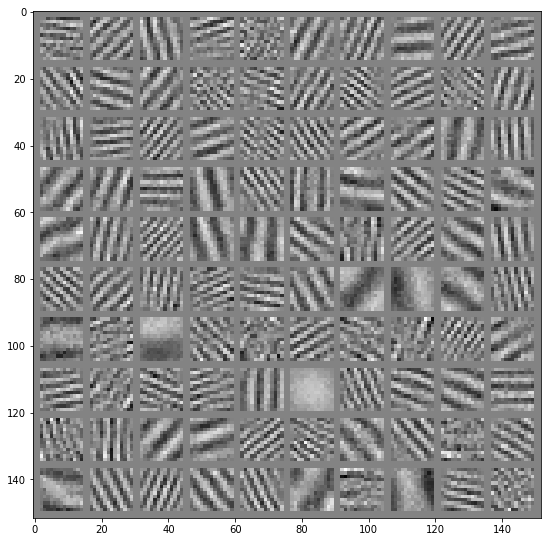

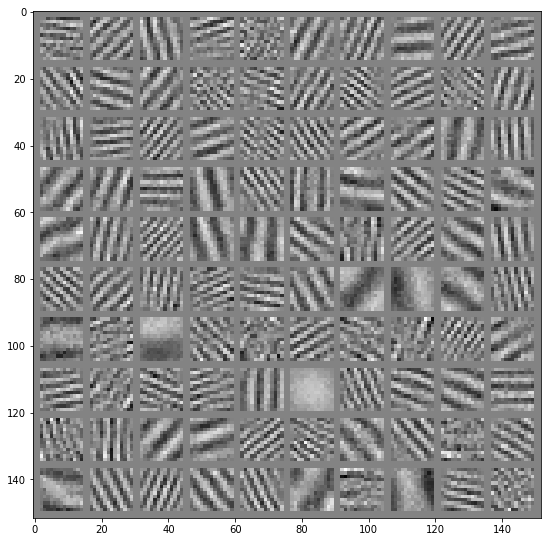

Epoch: 8500/20000 cost: 124.345900000
Epoch: 8501/20000 cost: 124.313675000
Epoch: 8502/20000 cost: 124.278800000
Epoch: 8503/20000 cost: 124.234600000
Epoch: 8504/20000 cost: 124.256325000
Epoch: 8505/20000 cost: 124.276450000
Epoch: 8506/20000 cost: 124.238325000
Epoch: 8507/20000 cost: 124.253850000
Epoch: 8508/20000 cost: 124.267325000
Epoch: 8509/20000 cost: 124.248650000
Epoch: 8510/20000 cost: 124.237900000
Epoch: 8511/20000 cost: 124.268662500
Epoch: 8512/20000 cost: 124.200100000
Epoch: 8513/20000 cost: 124.173750000
Epoch: 8514/20000 cost: 124.260375000
Epoch: 8515/20000 cost: 124.288425000
Epoch: 8516/20000 cost: 124.252450000
Epoch: 8517/20000 cost: 124.276350000
Epoch: 8518/20000 cost: 124.273700000
Epoch: 8519/20000 cost: 124.327925000
Epoch: 8520/20000 cost: 124.270550000
Epoch: 8521/20000 cost: 124.211825000
Epoch: 8522/20000 cost: 124.210275000
Epoch: 8523/20000 cost: 124.232175000
Epoch: 8524/20000 cost: 124.256300000
Epoch: 8525/20000 cost: 124.195275000
Epoch: 8526/

Epoch: 8717/20000 cost: 124.238787500
Epoch: 8718/20000 cost: 124.224600000
Epoch: 8719/20000 cost: 124.259375000
Epoch: 8720/20000 cost: 124.183700000
Epoch: 8721/20000 cost: 124.192600000
Epoch: 8722/20000 cost: 124.237600000
Epoch: 8723/20000 cost: 124.181337500
Epoch: 8724/20000 cost: 124.188950000
Epoch: 8725/20000 cost: 124.189687500
Epoch: 8726/20000 cost: 124.188275000
Epoch: 8727/20000 cost: 124.166550000
Epoch: 8728/20000 cost: 124.182875000
Epoch: 8729/20000 cost: 124.219237500
Epoch: 8730/20000 cost: 124.168525000
Epoch: 8731/20000 cost: 124.196225000
Epoch: 8732/20000 cost: 124.181462500
Epoch: 8733/20000 cost: 124.160787500
Epoch: 8734/20000 cost: 124.227100000
Epoch: 8735/20000 cost: 124.234900000
Epoch: 8736/20000 cost: 124.218650000
Epoch: 8737/20000 cost: 124.218137500
Epoch: 8738/20000 cost: 124.199800000
Epoch: 8739/20000 cost: 124.197162500
Epoch: 8740/20000 cost: 124.209062500
Epoch: 8741/20000 cost: 124.204650000
Epoch: 8742/20000 cost: 124.206125000
Epoch: 8743/

Epoch: 8935/20000 cost: 124.148462500
Epoch: 8936/20000 cost: 124.173737500
Epoch: 8937/20000 cost: 124.154962500
Epoch: 8938/20000 cost: 124.204687500
Epoch: 8939/20000 cost: 124.194712500
Epoch: 8940/20000 cost: 124.167862500
Epoch: 8941/20000 cost: 124.165675000
Epoch: 8942/20000 cost: 124.207000000
Epoch: 8943/20000 cost: 124.171875000
Epoch: 8944/20000 cost: 124.147475000
Epoch: 8945/20000 cost: 124.207812500
Epoch: 8946/20000 cost: 124.145675000
Epoch: 8947/20000 cost: 124.166825000
Epoch: 8948/20000 cost: 124.139425000
Epoch: 8949/20000 cost: 124.173700000
Epoch: 8950/20000 cost: 124.123562500
Epoch: 8951/20000 cost: 124.135675000
Epoch: 8952/20000 cost: 124.130687500
Epoch: 8953/20000 cost: 124.095225000
Epoch: 8954/20000 cost: 124.181187500
Epoch: 8955/20000 cost: 124.124512500
Epoch: 8956/20000 cost: 124.078700000
Epoch: 8957/20000 cost: 124.167025000
Epoch: 8958/20000 cost: 124.201425000
Epoch: 8959/20000 cost: 124.130725000
Epoch: 8960/20000 cost: 124.166137500
Epoch: 8961/

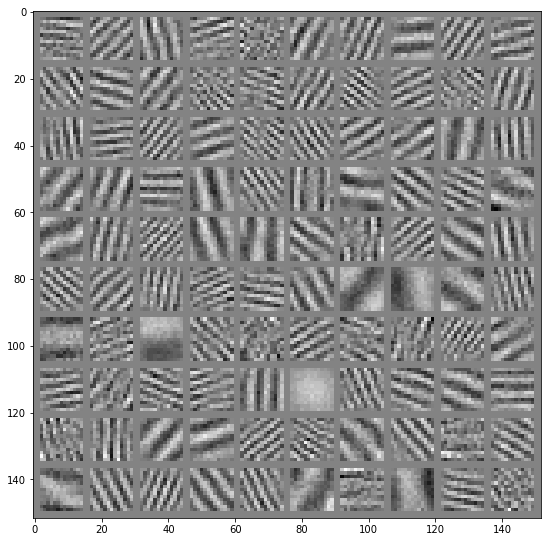

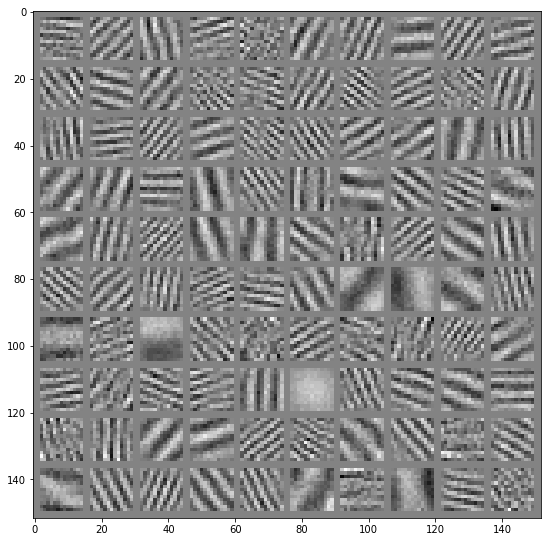

Epoch: 9000/20000 cost: 124.102650000
Epoch: 9001/20000 cost: 124.172300000
Epoch: 9002/20000 cost: 124.131237500
Epoch: 9003/20000 cost: 124.136550000
Epoch: 9004/20000 cost: 124.099800000
Epoch: 9005/20000 cost: 124.065650000
Epoch: 9006/20000 cost: 124.125975000
Epoch: 9007/20000 cost: 124.102375000
Epoch: 9008/20000 cost: 124.103537500
Epoch: 9009/20000 cost: 124.158900000
Epoch: 9010/20000 cost: 124.151625000
Epoch: 9011/20000 cost: 124.145450000
Epoch: 9012/20000 cost: 124.150550000
Epoch: 9013/20000 cost: 124.115900000
Epoch: 9014/20000 cost: 124.139050000
Epoch: 9015/20000 cost: 124.143725000
Epoch: 9016/20000 cost: 124.070000000
Epoch: 9017/20000 cost: 124.168775000
Epoch: 9018/20000 cost: 124.092662500
Epoch: 9019/20000 cost: 124.086975000
Epoch: 9020/20000 cost: 124.091162500
Epoch: 9021/20000 cost: 124.125300000
Epoch: 9022/20000 cost: 124.111200000
Epoch: 9023/20000 cost: 124.127550000
Epoch: 9024/20000 cost: 124.127900000
Epoch: 9025/20000 cost: 124.158012500
Epoch: 9026/

Epoch: 9217/20000 cost: 124.053575000
Epoch: 9218/20000 cost: 124.109175000
Epoch: 9219/20000 cost: 124.093575000
Epoch: 9220/20000 cost: 124.094937500
Epoch: 9221/20000 cost: 124.072687500
Epoch: 9222/20000 cost: 124.091087500
Epoch: 9223/20000 cost: 124.062425000
Epoch: 9224/20000 cost: 124.078000000
Epoch: 9225/20000 cost: 124.077162500
Epoch: 9226/20000 cost: 124.044275000
Epoch: 9227/20000 cost: 124.047825000
Epoch: 9228/20000 cost: 124.022775000
Epoch: 9229/20000 cost: 124.041450000
Epoch: 9230/20000 cost: 124.045375000
Epoch: 9231/20000 cost: 124.034800000
Epoch: 9232/20000 cost: 124.056350000
Epoch: 9233/20000 cost: 124.077150000
Epoch: 9234/20000 cost: 124.125362500
Epoch: 9235/20000 cost: 124.091525000
Epoch: 9236/20000 cost: 124.086350000
Epoch: 9237/20000 cost: 124.076475000
Epoch: 9238/20000 cost: 124.080812500
Epoch: 9239/20000 cost: 124.090325000
Epoch: 9240/20000 cost: 124.038837500
Epoch: 9241/20000 cost: 124.087812500
Epoch: 9242/20000 cost: 124.110775000
Epoch: 9243/

Epoch: 9433/20000 cost: 124.031162500
Epoch: 9434/20000 cost: 124.044412500
Epoch: 9435/20000 cost: 123.960400000
Epoch: 9436/20000 cost: 123.969250000
Epoch: 9437/20000 cost: 123.984900000
Epoch: 9438/20000 cost: 124.042100000
Epoch: 9439/20000 cost: 124.052675000
Epoch: 9440/20000 cost: 124.036375000
Epoch: 9441/20000 cost: 124.044650000
Epoch: 9442/20000 cost: 124.048625000
Epoch: 9443/20000 cost: 124.048450000
Epoch: 9444/20000 cost: 124.056600000
Epoch: 9445/20000 cost: 124.019025000
Epoch: 9446/20000 cost: 123.995875000
Epoch: 9447/20000 cost: 124.007600000
Epoch: 9448/20000 cost: 124.035675000
Epoch: 9449/20000 cost: 124.028187500
Epoch: 9450/20000 cost: 124.041375000
Epoch: 9451/20000 cost: 124.045650000
Epoch: 9452/20000 cost: 124.013600000
Epoch: 9453/20000 cost: 124.085562500
Epoch: 9454/20000 cost: 124.089162500
Epoch: 9455/20000 cost: 124.038475000
Epoch: 9456/20000 cost: 124.071950000
Epoch: 9457/20000 cost: 124.012425000
Epoch: 9458/20000 cost: 124.048312500
Epoch: 9459/

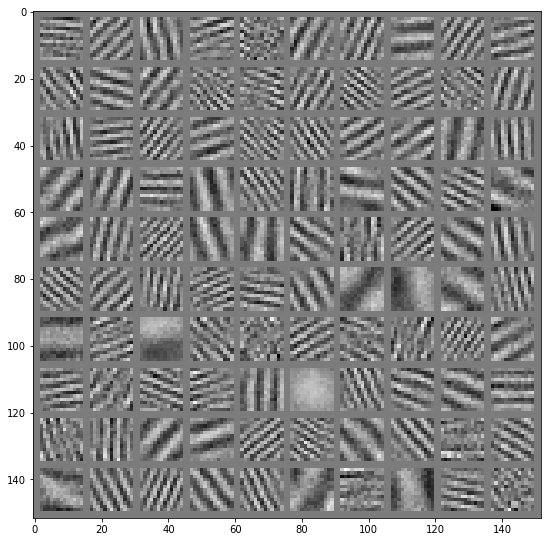

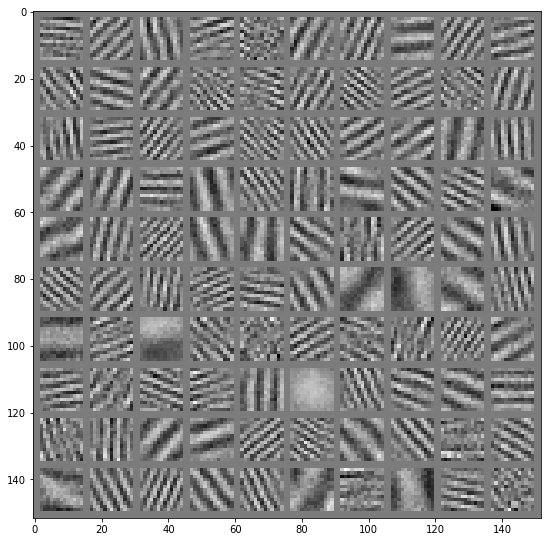

Epoch: 9500/20000 cost: 124.053100000
Epoch: 9501/20000 cost: 124.077537500
Epoch: 9502/20000 cost: 124.069075000
Epoch: 9503/20000 cost: 124.039350000
Epoch: 9504/20000 cost: 124.102300000
Epoch: 9505/20000 cost: 124.070637500
Epoch: 9506/20000 cost: 124.046737500
Epoch: 9507/20000 cost: 124.104700000
Epoch: 9508/20000 cost: 123.987925000
Epoch: 9509/20000 cost: 124.066300000
Epoch: 9510/20000 cost: 124.020625000
Epoch: 9511/20000 cost: 124.051812500
Epoch: 9512/20000 cost: 124.070250000
Epoch: 9513/20000 cost: 124.020125000
Epoch: 9514/20000 cost: 124.028275000
Epoch: 9515/20000 cost: 124.028112500
Epoch: 9516/20000 cost: 124.068725000
Epoch: 9517/20000 cost: 123.977900000
Epoch: 9518/20000 cost: 124.078887500
Epoch: 9519/20000 cost: 124.021475000
Epoch: 9520/20000 cost: 124.033975000
Epoch: 9521/20000 cost: 124.043300000
Epoch: 9522/20000 cost: 124.090375000
Epoch: 9523/20000 cost: 124.026762500
Epoch: 9524/20000 cost: 124.011237500
Epoch: 9525/20000 cost: 124.032450000
Epoch: 9526/

Epoch: 9718/20000 cost: 123.991737500
Epoch: 9719/20000 cost: 123.995325000
Epoch: 9720/20000 cost: 124.000600000
Epoch: 9721/20000 cost: 124.004950000
Epoch: 9722/20000 cost: 124.012900000
Epoch: 9723/20000 cost: 124.020862500
Epoch: 9724/20000 cost: 124.017737500
Epoch: 9725/20000 cost: 123.952850000
Epoch: 9726/20000 cost: 124.014950000
Epoch: 9727/20000 cost: 123.997025000
Epoch: 9728/20000 cost: 124.021587500
Epoch: 9729/20000 cost: 124.004650000
Epoch: 9730/20000 cost: 123.969200000
Epoch: 9731/20000 cost: 124.044450000
Epoch: 9732/20000 cost: 123.978962500
Epoch: 9733/20000 cost: 124.007400000
Epoch: 9734/20000 cost: 124.016025000
Epoch: 9735/20000 cost: 123.998375000
Epoch: 9736/20000 cost: 123.976475000
Epoch: 9737/20000 cost: 123.932612500
Epoch: 9738/20000 cost: 124.015525000
Epoch: 9739/20000 cost: 124.001125000
Epoch: 9740/20000 cost: 124.005712500
Epoch: 9741/20000 cost: 123.993500000
Epoch: 9742/20000 cost: 123.959812500
Epoch: 9743/20000 cost: 123.950725000
Epoch: 9744/

Epoch: 9935/20000 cost: 123.993025000
Epoch: 9936/20000 cost: 123.903725000
Epoch: 9937/20000 cost: 123.909725000
Epoch: 9938/20000 cost: 123.875400000
Epoch: 9939/20000 cost: 123.944562500
Epoch: 9940/20000 cost: 123.920250000
Epoch: 9941/20000 cost: 123.923900000
Epoch: 9942/20000 cost: 123.910575000
Epoch: 9943/20000 cost: 123.933250000
Epoch: 9944/20000 cost: 123.935450000
Epoch: 9945/20000 cost: 123.968012500
Epoch: 9946/20000 cost: 123.957600000
Epoch: 9947/20000 cost: 123.904812500
Epoch: 9948/20000 cost: 123.952800000
Epoch: 9949/20000 cost: 123.926350000
Epoch: 9950/20000 cost: 123.904875000
Epoch: 9951/20000 cost: 123.891475000
Epoch: 9952/20000 cost: 123.929725000
Epoch: 9953/20000 cost: 123.903500000
Epoch: 9954/20000 cost: 123.910400000
Epoch: 9955/20000 cost: 123.891925000
Epoch: 9956/20000 cost: 123.924387500
Epoch: 9957/20000 cost: 123.905400000
Epoch: 9958/20000 cost: 123.901625000
Epoch: 9959/20000 cost: 123.928200000
Epoch: 9960/20000 cost: 123.951600000
Epoch: 9961/

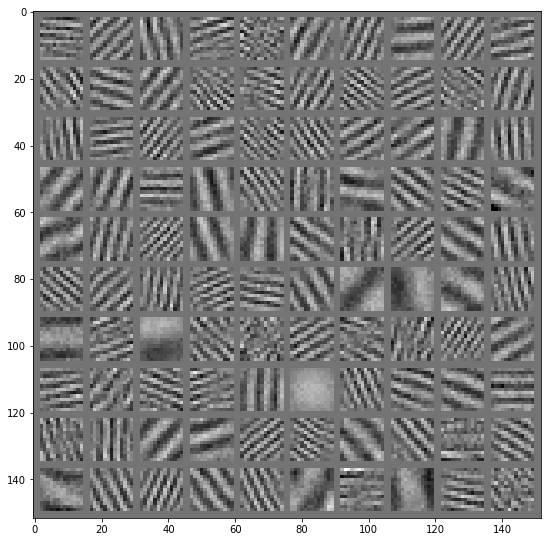

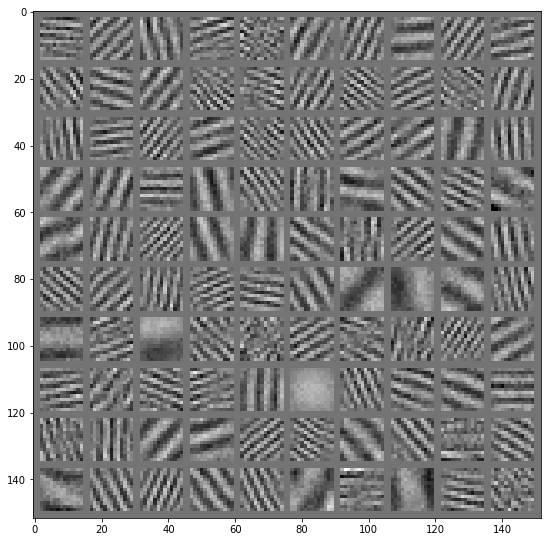

Epoch: 10000/20000 cost: 123.957425000
Epoch: 10001/20000 cost: 123.945187500
Epoch: 10002/20000 cost: 123.913375000
Epoch: 10003/20000 cost: 123.876800000
Epoch: 10004/20000 cost: 123.901650000
Epoch: 10005/20000 cost: 123.893625000
Epoch: 10006/20000 cost: 123.836150000
Epoch: 10007/20000 cost: 123.902950000
Epoch: 10008/20000 cost: 123.841800000
Epoch: 10009/20000 cost: 123.847800000
Epoch: 10010/20000 cost: 123.874237500
Epoch: 10011/20000 cost: 123.872075000
Epoch: 10012/20000 cost: 123.909500000
Epoch: 10013/20000 cost: 123.912600000
Epoch: 10014/20000 cost: 123.974812500
Epoch: 10015/20000 cost: 123.943850000
Epoch: 10016/20000 cost: 123.979875000
Epoch: 10017/20000 cost: 124.005125000
Epoch: 10018/20000 cost: 123.955625000
Epoch: 10019/20000 cost: 123.966012500
Epoch: 10020/20000 cost: 123.919300000
Epoch: 10021/20000 cost: 123.955087500
Epoch: 10022/20000 cost: 123.997787500
Epoch: 10023/20000 cost: 123.986525000
Epoch: 10024/20000 cost: 123.925875000
Epoch: 10025/20000 cost: 

Epoch: 10211/20000 cost: 123.869437500
Epoch: 10212/20000 cost: 123.932662500
Epoch: 10213/20000 cost: 123.942050000
Epoch: 10214/20000 cost: 123.958987500
Epoch: 10215/20000 cost: 123.911900000
Epoch: 10216/20000 cost: 123.898025000
Epoch: 10217/20000 cost: 123.896175000
Epoch: 10218/20000 cost: 123.912825000
Epoch: 10219/20000 cost: 123.865475000
Epoch: 10220/20000 cost: 123.860925000
Epoch: 10221/20000 cost: 123.861925000
Epoch: 10222/20000 cost: 123.907725000
Epoch: 10223/20000 cost: 123.897937500
Epoch: 10224/20000 cost: 123.927600000
Epoch: 10225/20000 cost: 123.917900000
Epoch: 10226/20000 cost: 123.880775000
Epoch: 10227/20000 cost: 123.826700000
Epoch: 10228/20000 cost: 123.893100000
Epoch: 10229/20000 cost: 123.849237500
Epoch: 10230/20000 cost: 123.850087500
Epoch: 10231/20000 cost: 123.870862500
Epoch: 10232/20000 cost: 123.909300000
Epoch: 10233/20000 cost: 123.864025000
Epoch: 10234/20000 cost: 123.919900000
Epoch: 10235/20000 cost: 123.836925000
Epoch: 10236/20000 cost: 

Epoch: 10424/20000 cost: 123.852900000
Epoch: 10425/20000 cost: 123.852800000
Epoch: 10426/20000 cost: 123.807525000
Epoch: 10427/20000 cost: 123.877125000
Epoch: 10428/20000 cost: 123.823000000
Epoch: 10429/20000 cost: 123.831350000
Epoch: 10430/20000 cost: 123.800050000
Epoch: 10431/20000 cost: 123.796412500
Epoch: 10432/20000 cost: 123.780975000
Epoch: 10433/20000 cost: 123.814525000
Epoch: 10434/20000 cost: 123.792650000
Epoch: 10435/20000 cost: 123.815050000
Epoch: 10436/20000 cost: 123.822412500
Epoch: 10437/20000 cost: 123.827600000
Epoch: 10438/20000 cost: 123.861950000
Epoch: 10439/20000 cost: 123.859800000
Epoch: 10440/20000 cost: 123.822500000
Epoch: 10441/20000 cost: 123.820950000
Epoch: 10442/20000 cost: 123.816425000
Epoch: 10443/20000 cost: 123.830262500
Epoch: 10444/20000 cost: 123.830462500
Epoch: 10445/20000 cost: 123.815025000
Epoch: 10446/20000 cost: 123.842850000
Epoch: 10447/20000 cost: 123.880750000
Epoch: 10448/20000 cost: 123.833650000
Epoch: 10449/20000 cost: 

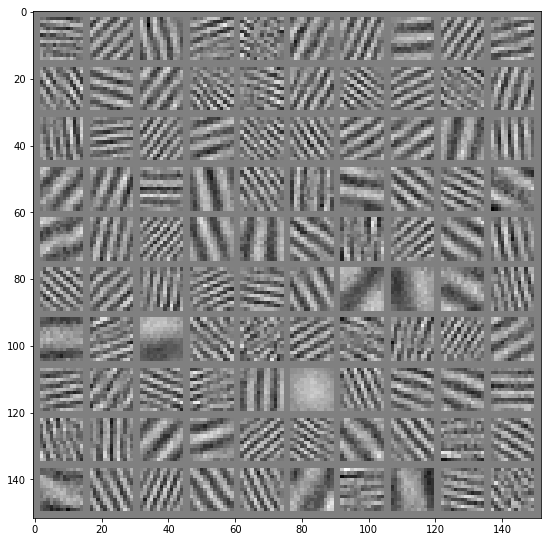

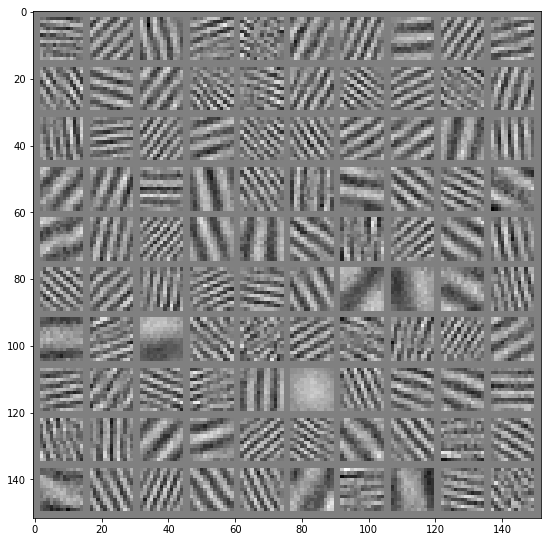

Epoch: 10500/20000 cost: 123.897825000
Epoch: 10501/20000 cost: 123.768200000
Epoch: 10502/20000 cost: 123.779900000
Epoch: 10503/20000 cost: 123.854025000
Epoch: 10504/20000 cost: 123.837850000
Epoch: 10505/20000 cost: 123.819650000
Epoch: 10506/20000 cost: 123.848862500
Epoch: 10507/20000 cost: 123.827375000
Epoch: 10508/20000 cost: 123.837200000
Epoch: 10509/20000 cost: 123.790237500
Epoch: 10510/20000 cost: 123.841937500
Epoch: 10511/20000 cost: 123.844375000
Epoch: 10512/20000 cost: 123.818250000
Epoch: 10513/20000 cost: 123.854300000
Epoch: 10514/20000 cost: 123.854050000
Epoch: 10515/20000 cost: 123.793325000
Epoch: 10516/20000 cost: 123.849725000
Epoch: 10517/20000 cost: 123.867900000
Epoch: 10518/20000 cost: 123.847662500
Epoch: 10519/20000 cost: 123.886700000
Epoch: 10520/20000 cost: 123.875250000
Epoch: 10521/20000 cost: 123.902375000
Epoch: 10522/20000 cost: 123.856350000
Epoch: 10523/20000 cost: 123.862925000
Epoch: 10524/20000 cost: 123.844737500
Epoch: 10525/20000 cost: 

Epoch: 10711/20000 cost: 123.818887500
Epoch: 10712/20000 cost: 123.783750000
Epoch: 10713/20000 cost: 123.822062500
Epoch: 10714/20000 cost: 123.839687500
Epoch: 10715/20000 cost: 123.845975000
Epoch: 10716/20000 cost: 123.791775000
Epoch: 10717/20000 cost: 123.841612500
Epoch: 10718/20000 cost: 123.825100000
Epoch: 10719/20000 cost: 123.871612500
Epoch: 10720/20000 cost: 123.850575000
Epoch: 10721/20000 cost: 123.839625000
Epoch: 10722/20000 cost: 123.786512500
Epoch: 10723/20000 cost: 123.799000000
Epoch: 10724/20000 cost: 123.847862500
Epoch: 10725/20000 cost: 123.764962500
Epoch: 10726/20000 cost: 123.778562500
Epoch: 10727/20000 cost: 123.843062500
Epoch: 10728/20000 cost: 123.843725000
Epoch: 10729/20000 cost: 123.838587500
Epoch: 10730/20000 cost: 123.803937500
Epoch: 10731/20000 cost: 123.805800000
Epoch: 10732/20000 cost: 123.805950000
Epoch: 10733/20000 cost: 123.897150000
Epoch: 10734/20000 cost: 123.793187500
Epoch: 10735/20000 cost: 123.814475000
Epoch: 10736/20000 cost: 

Epoch: 10922/20000 cost: 123.791000000
Epoch: 10923/20000 cost: 123.865050000
Epoch: 10924/20000 cost: 123.797412500
Epoch: 10925/20000 cost: 123.782225000
Epoch: 10926/20000 cost: 123.796912500
Epoch: 10927/20000 cost: 123.830325000
Epoch: 10928/20000 cost: 123.822350000
Epoch: 10929/20000 cost: 123.776975000
Epoch: 10930/20000 cost: 123.846962500
Epoch: 10931/20000 cost: 123.815200000
Epoch: 10932/20000 cost: 123.824925000
Epoch: 10933/20000 cost: 123.833237500
Epoch: 10934/20000 cost: 123.786175000
Epoch: 10935/20000 cost: 123.806575000
Epoch: 10936/20000 cost: 123.798725000
Epoch: 10937/20000 cost: 123.812275000
Epoch: 10938/20000 cost: 123.772337500
Epoch: 10939/20000 cost: 123.785412500
Epoch: 10940/20000 cost: 123.781475000
Epoch: 10941/20000 cost: 123.797687500
Epoch: 10942/20000 cost: 123.778600000
Epoch: 10943/20000 cost: 123.752500000
Epoch: 10944/20000 cost: 123.749362500
Epoch: 10945/20000 cost: 123.736950000
Epoch: 10946/20000 cost: 123.755750000
Epoch: 10947/20000 cost: 

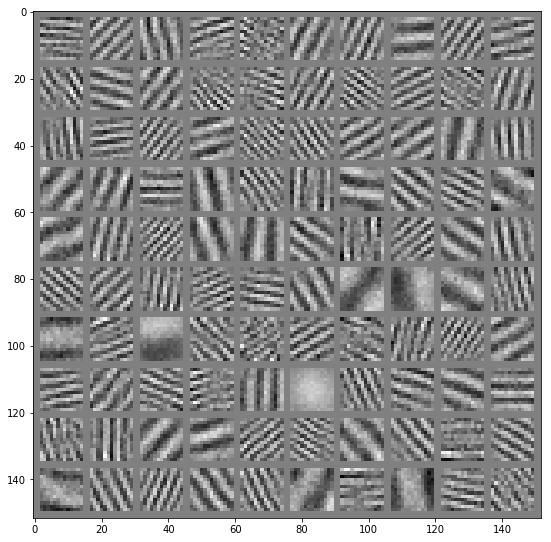

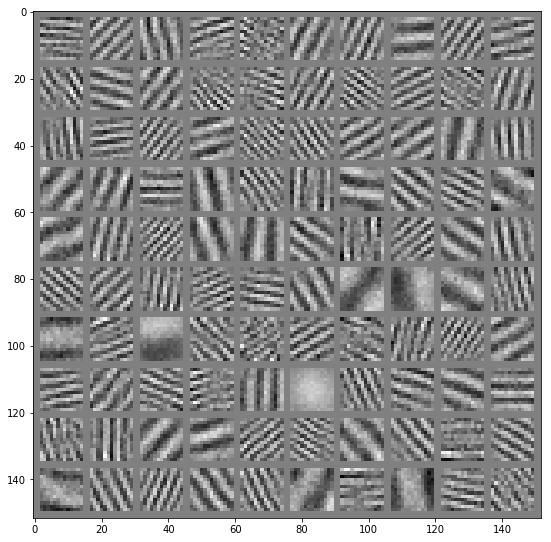

Epoch: 11000/20000 cost: 123.867387500
Epoch: 11001/20000 cost: 123.811525000
Epoch: 11002/20000 cost: 123.785075000
Epoch: 11003/20000 cost: 123.760200000
Epoch: 11004/20000 cost: 123.844025000
Epoch: 11005/20000 cost: 123.720550000
Epoch: 11006/20000 cost: 123.777100000
Epoch: 11007/20000 cost: 123.761762500
Epoch: 11008/20000 cost: 123.757150000
Epoch: 11009/20000 cost: 123.772275000
Epoch: 11010/20000 cost: 123.785875000
Epoch: 11011/20000 cost: 123.799212500
Epoch: 11012/20000 cost: 123.824625000
Epoch: 11013/20000 cost: 123.788350000
Epoch: 11014/20000 cost: 123.766475000
Epoch: 11015/20000 cost: 123.748562500
Epoch: 11016/20000 cost: 123.764900000
Epoch: 11017/20000 cost: 123.848000000
Epoch: 11018/20000 cost: 123.809000000
Epoch: 11019/20000 cost: 123.808925000
Epoch: 11020/20000 cost: 123.814412500
Epoch: 11021/20000 cost: 123.804687500
Epoch: 11022/20000 cost: 123.756900000
Epoch: 11023/20000 cost: 123.758437500
Epoch: 11024/20000 cost: 123.816950000
Epoch: 11025/20000 cost: 

Epoch: 11212/20000 cost: 123.721725000
Epoch: 11213/20000 cost: 123.686375000
Epoch: 11214/20000 cost: 123.745525000
Epoch: 11215/20000 cost: 123.706650000
Epoch: 11216/20000 cost: 123.699562500
Epoch: 11217/20000 cost: 123.765175000
Epoch: 11218/20000 cost: 123.777300000
Epoch: 11219/20000 cost: 123.766475000
Epoch: 11220/20000 cost: 123.764725000
Epoch: 11221/20000 cost: 123.767400000
Epoch: 11222/20000 cost: 123.795250000
Epoch: 11223/20000 cost: 123.747900000
Epoch: 11224/20000 cost: 123.726300000
Epoch: 11225/20000 cost: 123.794200000
Epoch: 11226/20000 cost: 123.745062500
Epoch: 11227/20000 cost: 123.752562500
Epoch: 11228/20000 cost: 123.720500000
Epoch: 11229/20000 cost: 123.765200000
Epoch: 11230/20000 cost: 123.716750000
Epoch: 11231/20000 cost: 123.766225000
Epoch: 11232/20000 cost: 123.744375000
Epoch: 11233/20000 cost: 123.747225000
Epoch: 11234/20000 cost: 123.767275000
Epoch: 11235/20000 cost: 123.788100000
Epoch: 11236/20000 cost: 123.781100000
Epoch: 11237/20000 cost: 

Epoch: 11423/20000 cost: 123.697400000
Epoch: 11424/20000 cost: 123.675000000
Epoch: 11425/20000 cost: 123.668025000
Epoch: 11426/20000 cost: 123.699037500
Epoch: 11427/20000 cost: 123.684325000
Epoch: 11428/20000 cost: 123.704250000
Epoch: 11429/20000 cost: 123.708912500
Epoch: 11430/20000 cost: 123.712300000
Epoch: 11431/20000 cost: 123.711337500
Epoch: 11432/20000 cost: 123.747950000
Epoch: 11433/20000 cost: 123.750250000
Epoch: 11434/20000 cost: 123.724975000
Epoch: 11435/20000 cost: 123.711350000
Epoch: 11436/20000 cost: 123.675425000
Epoch: 11437/20000 cost: 123.714237500
Epoch: 11438/20000 cost: 123.721437500
Epoch: 11439/20000 cost: 123.733000000
Epoch: 11440/20000 cost: 123.698325000
Epoch: 11441/20000 cost: 123.734337500
Epoch: 11442/20000 cost: 123.745950000
Epoch: 11443/20000 cost: 123.745925000
Epoch: 11444/20000 cost: 123.721400000
Epoch: 11445/20000 cost: 123.691950000
Epoch: 11446/20000 cost: 123.703275000
Epoch: 11447/20000 cost: 123.777762500
Epoch: 11448/20000 cost: 

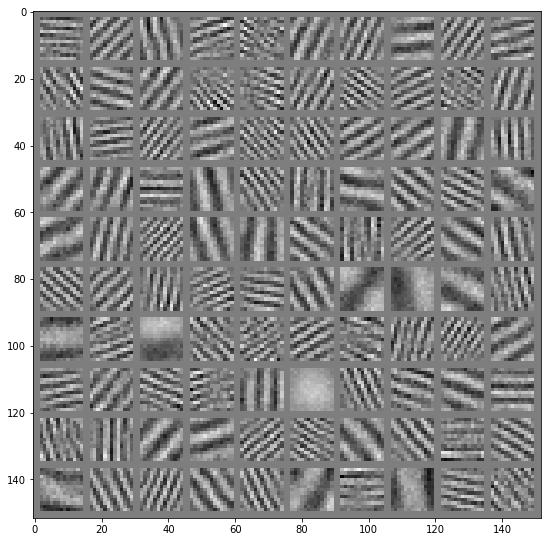

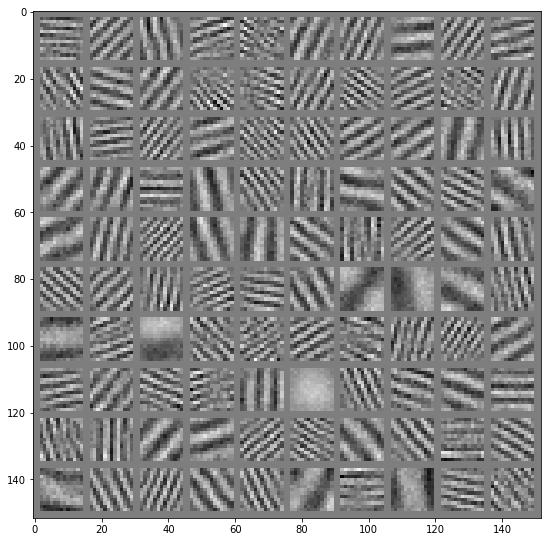

Epoch: 11500/20000 cost: 123.715137500
Epoch: 11501/20000 cost: 123.693400000
Epoch: 11502/20000 cost: 123.764162500
Epoch: 11503/20000 cost: 123.767400000
Epoch: 11504/20000 cost: 123.731100000
Epoch: 11505/20000 cost: 123.752062500
Epoch: 11506/20000 cost: 123.755450000
Epoch: 11507/20000 cost: 123.715050000
Epoch: 11508/20000 cost: 123.712125000
Epoch: 11509/20000 cost: 123.714525000
Epoch: 11510/20000 cost: 123.737225000
Epoch: 11511/20000 cost: 123.792425000
Epoch: 11512/20000 cost: 123.749925000
Epoch: 11513/20000 cost: 123.798200000
Epoch: 11514/20000 cost: 123.791012500
Epoch: 11515/20000 cost: 123.785287500
Epoch: 11516/20000 cost: 123.767250000
Epoch: 11517/20000 cost: 123.727775000
Epoch: 11518/20000 cost: 123.728850000
Epoch: 11519/20000 cost: 123.691512500
Epoch: 11520/20000 cost: 123.725100000
Epoch: 11521/20000 cost: 123.668700000
Epoch: 11522/20000 cost: 123.767425000
Epoch: 11523/20000 cost: 123.718275000
Epoch: 11524/20000 cost: 123.741825000
Epoch: 11525/20000 cost: 

Epoch: 11711/20000 cost: 123.697375000
Epoch: 11712/20000 cost: 123.703787500
Epoch: 11713/20000 cost: 123.685900000
Epoch: 11714/20000 cost: 123.754787500
Epoch: 11715/20000 cost: 123.713925000
Epoch: 11716/20000 cost: 123.718325000
Epoch: 11717/20000 cost: 123.767475000
Epoch: 11718/20000 cost: 123.733475000
Epoch: 11719/20000 cost: 123.776325000
Epoch: 11720/20000 cost: 123.784600000
Epoch: 11721/20000 cost: 123.782837500
Epoch: 11722/20000 cost: 123.730850000
Epoch: 11723/20000 cost: 123.709975000
Epoch: 11724/20000 cost: 123.696575000
Epoch: 11725/20000 cost: 123.740900000
Epoch: 11726/20000 cost: 123.751175000
Epoch: 11727/20000 cost: 123.710025000
Epoch: 11728/20000 cost: 123.748500000
Epoch: 11729/20000 cost: 123.698050000
Epoch: 11730/20000 cost: 123.716562500
Epoch: 11731/20000 cost: 123.732000000
Epoch: 11732/20000 cost: 123.667887500
Epoch: 11733/20000 cost: 123.668200000
Epoch: 11734/20000 cost: 123.677187500
Epoch: 11735/20000 cost: 123.702450000
Epoch: 11736/20000 cost: 

Epoch: 11923/20000 cost: 123.697562500
Epoch: 11924/20000 cost: 123.679200000
Epoch: 11925/20000 cost: 123.685025000
Epoch: 11926/20000 cost: 123.669600000
Epoch: 11927/20000 cost: 123.627125000
Epoch: 11928/20000 cost: 123.714200000
Epoch: 11929/20000 cost: 123.666725000
Epoch: 11930/20000 cost: 123.655087500
Epoch: 11931/20000 cost: 123.655575000
Epoch: 11932/20000 cost: 123.672200000
Epoch: 11933/20000 cost: 123.616125000
Epoch: 11934/20000 cost: 123.672125000
Epoch: 11935/20000 cost: 123.692600000
Epoch: 11936/20000 cost: 123.624725000
Epoch: 11937/20000 cost: 123.667962500
Epoch: 11938/20000 cost: 123.681325000
Epoch: 11939/20000 cost: 123.640850000
Epoch: 11940/20000 cost: 123.651700000
Epoch: 11941/20000 cost: 123.659800000
Epoch: 11942/20000 cost: 123.671825000
Epoch: 11943/20000 cost: 123.600850000
Epoch: 11944/20000 cost: 123.636350000
Epoch: 11945/20000 cost: 123.603725000
Epoch: 11946/20000 cost: 123.590300000
Epoch: 11947/20000 cost: 123.631875000
Epoch: 11948/20000 cost: 

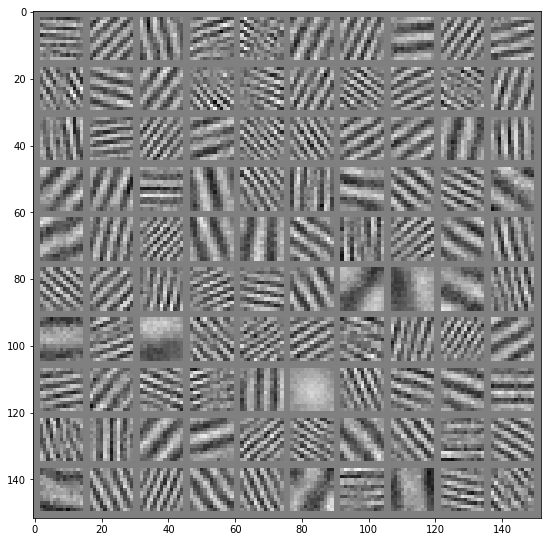

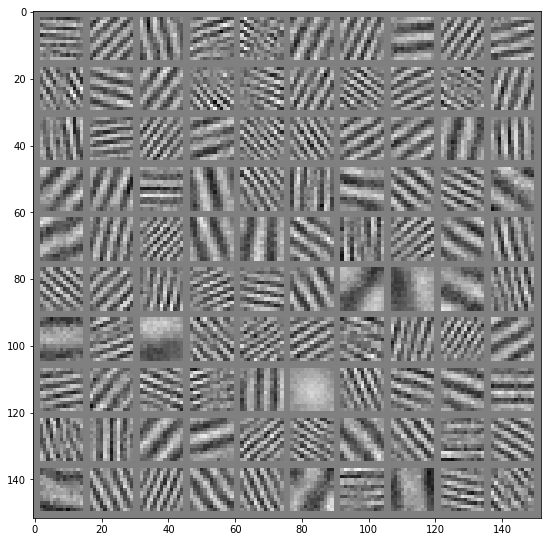

Epoch: 12000/20000 cost: 123.626500000
Epoch: 12001/20000 cost: 123.629587500
Epoch: 12002/20000 cost: 123.612500000
Epoch: 12003/20000 cost: 123.680575000
Epoch: 12004/20000 cost: 123.685700000
Epoch: 12005/20000 cost: 123.609012500
Epoch: 12006/20000 cost: 123.703650000
Epoch: 12007/20000 cost: 123.727450000
Epoch: 12008/20000 cost: 123.657600000
Epoch: 12009/20000 cost: 123.724187500
Epoch: 12010/20000 cost: 123.693775000
Epoch: 12011/20000 cost: 123.702612500
Epoch: 12012/20000 cost: 123.712950000
Epoch: 12013/20000 cost: 123.717612500
Epoch: 12014/20000 cost: 123.799475000
Epoch: 12015/20000 cost: 123.778637500
Epoch: 12016/20000 cost: 123.744187500
Epoch: 12017/20000 cost: 123.680425000
Epoch: 12018/20000 cost: 123.696325000
Epoch: 12019/20000 cost: 123.663937500
Epoch: 12020/20000 cost: 123.649750000
Epoch: 12021/20000 cost: 123.668337500
Epoch: 12022/20000 cost: 123.702700000
Epoch: 12023/20000 cost: 123.708400000
Epoch: 12024/20000 cost: 123.669950000
Epoch: 12025/20000 cost: 

Epoch: 12213/20000 cost: 123.614675000
Epoch: 12214/20000 cost: 123.574800000
Epoch: 12215/20000 cost: 123.585150000
Epoch: 12216/20000 cost: 123.609700000
Epoch: 12217/20000 cost: 123.655425000
Epoch: 12218/20000 cost: 123.635500000
Epoch: 12219/20000 cost: 123.684100000
Epoch: 12220/20000 cost: 123.706837500
Epoch: 12221/20000 cost: 123.686075000
Epoch: 12222/20000 cost: 123.712100000
Epoch: 12223/20000 cost: 123.717837500
Epoch: 12224/20000 cost: 123.697375000
Epoch: 12225/20000 cost: 123.652487500
Epoch: 12226/20000 cost: 123.688375000
Epoch: 12227/20000 cost: 123.681062500
Epoch: 12228/20000 cost: 123.646462500
Epoch: 12229/20000 cost: 123.674075000
Epoch: 12230/20000 cost: 123.650825000
Epoch: 12231/20000 cost: 123.634475000
Epoch: 12232/20000 cost: 123.725250000
Epoch: 12233/20000 cost: 123.667500000
Epoch: 12234/20000 cost: 123.666050000
Epoch: 12235/20000 cost: 123.692925000
Epoch: 12236/20000 cost: 123.597350000
Epoch: 12237/20000 cost: 123.580875000
Epoch: 12238/20000 cost: 

Epoch: 12424/20000 cost: 123.619162500
Epoch: 12425/20000 cost: 123.622800000
Epoch: 12426/20000 cost: 123.667800000
Epoch: 12427/20000 cost: 123.651125000
Epoch: 12428/20000 cost: 123.660575000
Epoch: 12429/20000 cost: 123.615000000
Epoch: 12430/20000 cost: 123.643950000
Epoch: 12431/20000 cost: 123.611250000
Epoch: 12432/20000 cost: 123.590675000
Epoch: 12433/20000 cost: 123.563200000
Epoch: 12434/20000 cost: 123.535800000
Epoch: 12435/20000 cost: 123.573237500
Epoch: 12436/20000 cost: 123.549325000
Epoch: 12437/20000 cost: 123.548412500
Epoch: 12438/20000 cost: 123.628387500
Epoch: 12439/20000 cost: 123.554350000
Epoch: 12440/20000 cost: 123.547075000
Epoch: 12441/20000 cost: 123.566987500
Epoch: 12442/20000 cost: 123.567875000
Epoch: 12443/20000 cost: 123.576700000
Epoch: 12444/20000 cost: 123.615150000
Epoch: 12445/20000 cost: 123.566025000
Epoch: 12446/20000 cost: 123.639162500
Epoch: 12447/20000 cost: 123.508875000
Epoch: 12448/20000 cost: 123.567250000
Epoch: 12449/20000 cost: 

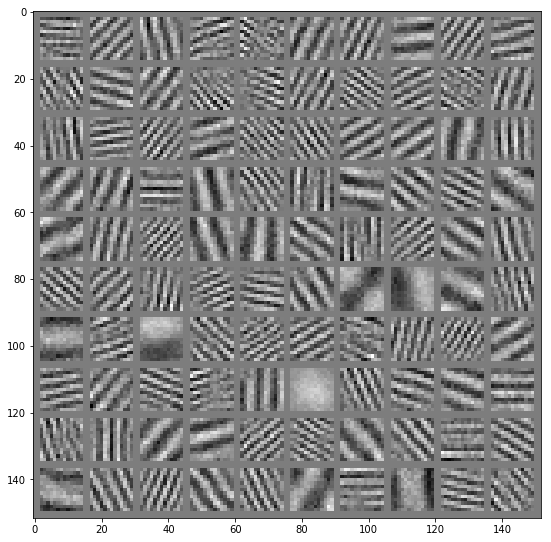

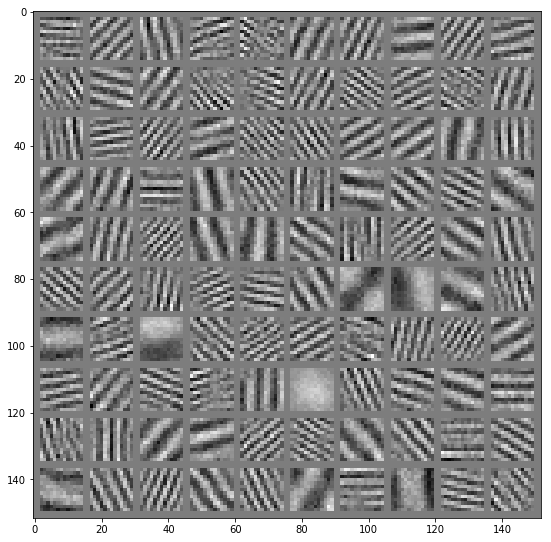

Epoch: 12500/20000 cost: 123.535912500
Epoch: 12501/20000 cost: 123.593400000
Epoch: 12502/20000 cost: 123.534050000
Epoch: 12503/20000 cost: 123.577525000
Epoch: 12504/20000 cost: 123.629062500
Epoch: 12505/20000 cost: 123.584450000
Epoch: 12506/20000 cost: 123.619925000
Epoch: 12507/20000 cost: 123.679300000
Epoch: 12508/20000 cost: 123.598325000
Epoch: 12509/20000 cost: 123.652975000
Epoch: 12510/20000 cost: 123.597600000
Epoch: 12511/20000 cost: 123.614825000
Epoch: 12512/20000 cost: 123.561475000
Epoch: 12513/20000 cost: 123.653650000
Epoch: 12514/20000 cost: 123.619500000
Epoch: 12515/20000 cost: 123.559312500
Epoch: 12516/20000 cost: 123.563975000
Epoch: 12517/20000 cost: 123.547700000
Epoch: 12518/20000 cost: 123.550887500
Epoch: 12519/20000 cost: 123.571350000
Epoch: 12520/20000 cost: 123.632525000
Epoch: 12521/20000 cost: 123.638800000
Epoch: 12522/20000 cost: 123.676125000
Epoch: 12523/20000 cost: 123.656775000
Epoch: 12524/20000 cost: 123.633087500
Epoch: 12525/20000 cost: 

Epoch: 12713/20000 cost: 123.539062500
Epoch: 12714/20000 cost: 123.570050000
Epoch: 12715/20000 cost: 123.547450000
Epoch: 12716/20000 cost: 123.559900000
Epoch: 12717/20000 cost: 123.583187500
Epoch: 12718/20000 cost: 123.510700000
Epoch: 12719/20000 cost: 123.552925000
Epoch: 12720/20000 cost: 123.548212500
Epoch: 12721/20000 cost: 123.521150000
Epoch: 12722/20000 cost: 123.536250000
Epoch: 12723/20000 cost: 123.558150000
Epoch: 12724/20000 cost: 123.590800000
Epoch: 12725/20000 cost: 123.579100000
Epoch: 12726/20000 cost: 123.619800000
Epoch: 12727/20000 cost: 123.608187500
Epoch: 12728/20000 cost: 123.603350000
Epoch: 12729/20000 cost: 123.637500000
Epoch: 12730/20000 cost: 123.601050000
Epoch: 12731/20000 cost: 123.554600000
Epoch: 12732/20000 cost: 123.559475000
Epoch: 12733/20000 cost: 123.525125000
Epoch: 12734/20000 cost: 123.569900000
Epoch: 12735/20000 cost: 123.545875000
Epoch: 12736/20000 cost: 123.598225000
Epoch: 12737/20000 cost: 123.535375000
Epoch: 12738/20000 cost: 

Epoch: 12925/20000 cost: 123.599275000
Epoch: 12926/20000 cost: 123.596225000
Epoch: 12927/20000 cost: 123.532050000
Epoch: 12928/20000 cost: 123.524387500
Epoch: 12929/20000 cost: 123.489025000
Epoch: 12930/20000 cost: 123.515625000
Epoch: 12931/20000 cost: 123.530625000
Epoch: 12932/20000 cost: 123.540450000
Epoch: 12933/20000 cost: 123.614225000
Epoch: 12934/20000 cost: 123.645462500
Epoch: 12935/20000 cost: 123.603725000
Epoch: 12936/20000 cost: 123.587825000
Epoch: 12937/20000 cost: 123.582225000
Epoch: 12938/20000 cost: 123.547525000
Epoch: 12939/20000 cost: 123.546950000
Epoch: 12940/20000 cost: 123.604737500
Epoch: 12941/20000 cost: 123.532025000
Epoch: 12942/20000 cost: 123.490062500
Epoch: 12943/20000 cost: 123.541687500
Epoch: 12944/20000 cost: 123.518725000
Epoch: 12945/20000 cost: 123.507475000
Epoch: 12946/20000 cost: 123.560300000
Epoch: 12947/20000 cost: 123.613625000
Epoch: 12948/20000 cost: 123.599425000
Epoch: 12949/20000 cost: 123.594400000
Epoch: 12950/20000 cost: 

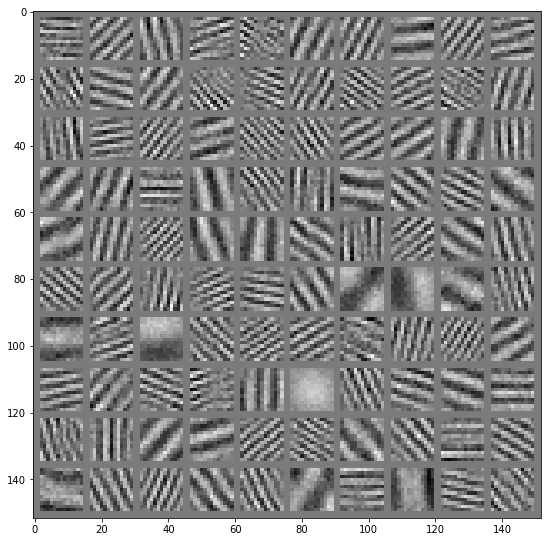

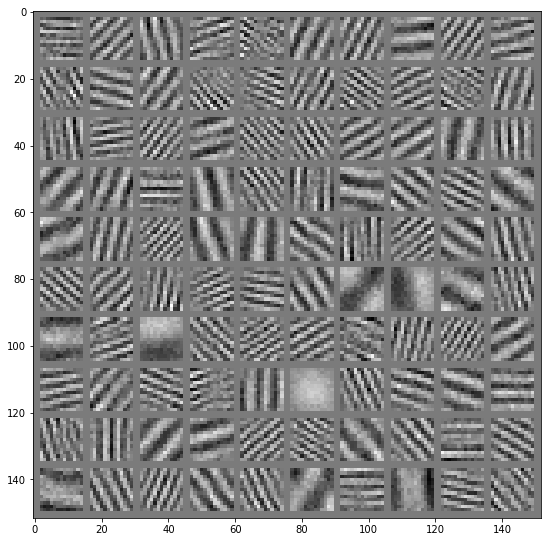

Epoch: 13000/20000 cost: 123.570050000
Epoch: 13001/20000 cost: 123.567987500
Epoch: 13002/20000 cost: 123.590275000
Epoch: 13003/20000 cost: 123.501475000
Epoch: 13004/20000 cost: 123.604050000
Epoch: 13005/20000 cost: 123.564550000
Epoch: 13006/20000 cost: 123.564600000
Epoch: 13007/20000 cost: 123.572400000
Epoch: 13008/20000 cost: 123.530150000
Epoch: 13009/20000 cost: 123.550000000
Epoch: 13010/20000 cost: 123.532175000
Epoch: 13011/20000 cost: 123.530200000
Epoch: 13012/20000 cost: 123.543325000
Epoch: 13013/20000 cost: 123.531275000
Epoch: 13014/20000 cost: 123.519437500
Epoch: 13015/20000 cost: 123.480850000
Epoch: 13016/20000 cost: 123.509800000
Epoch: 13017/20000 cost: 123.520375000
Epoch: 13018/20000 cost: 123.519425000
Epoch: 13019/20000 cost: 123.516650000
Epoch: 13020/20000 cost: 123.555000000
Epoch: 13021/20000 cost: 123.558500000
Epoch: 13022/20000 cost: 123.554137500
Epoch: 13023/20000 cost: 123.597300000
Epoch: 13024/20000 cost: 123.548162500
Epoch: 13025/20000 cost: 

Epoch: 13212/20000 cost: 123.503125000
Epoch: 13213/20000 cost: 123.523525000
Epoch: 13214/20000 cost: 123.594462500
Epoch: 13215/20000 cost: 123.604787500
Epoch: 13216/20000 cost: 123.584237500
Epoch: 13217/20000 cost: 123.611562500
Epoch: 13218/20000 cost: 123.647350000
Epoch: 13219/20000 cost: 123.611737500
Epoch: 13220/20000 cost: 123.592875000
Epoch: 13221/20000 cost: 123.556175000
Epoch: 13222/20000 cost: 123.549512500
Epoch: 13223/20000 cost: 123.483900000
Epoch: 13224/20000 cost: 123.507787500
Epoch: 13225/20000 cost: 123.536487500
Epoch: 13226/20000 cost: 123.502037500
Epoch: 13227/20000 cost: 123.488975000
Epoch: 13228/20000 cost: 123.545625000
Epoch: 13229/20000 cost: 123.497700000
Epoch: 13230/20000 cost: 123.531800000
Epoch: 13231/20000 cost: 123.472362500
Epoch: 13232/20000 cost: 123.456525000
Epoch: 13233/20000 cost: 123.488812500
Epoch: 13234/20000 cost: 123.506575000
Epoch: 13235/20000 cost: 123.571787500
Epoch: 13236/20000 cost: 123.475150000
Epoch: 13237/20000 cost: 

Epoch: 13425/20000 cost: 123.515425000
Epoch: 13426/20000 cost: 123.521150000
Epoch: 13427/20000 cost: 123.513862500
Epoch: 13428/20000 cost: 123.550175000
Epoch: 13429/20000 cost: 123.549700000
Epoch: 13430/20000 cost: 123.569775000
Epoch: 13431/20000 cost: 123.568400000
Epoch: 13432/20000 cost: 123.592437500
Epoch: 13433/20000 cost: 123.557600000
Epoch: 13434/20000 cost: 123.560787500
Epoch: 13435/20000 cost: 123.566437500
Epoch: 13436/20000 cost: 123.541600000
Epoch: 13437/20000 cost: 123.572000000
Epoch: 13438/20000 cost: 123.561712500
Epoch: 13439/20000 cost: 123.548350000
Epoch: 13440/20000 cost: 123.531387500
Epoch: 13441/20000 cost: 123.489150000
Epoch: 13442/20000 cost: 123.515487500
Epoch: 13443/20000 cost: 123.587825000
Epoch: 13444/20000 cost: 123.577125000
Epoch: 13445/20000 cost: 123.580600000
Epoch: 13446/20000 cost: 123.520425000
Epoch: 13447/20000 cost: 123.585750000
Epoch: 13448/20000 cost: 123.586925000
Epoch: 13449/20000 cost: 123.525500000
Epoch: 13450/20000 cost: 

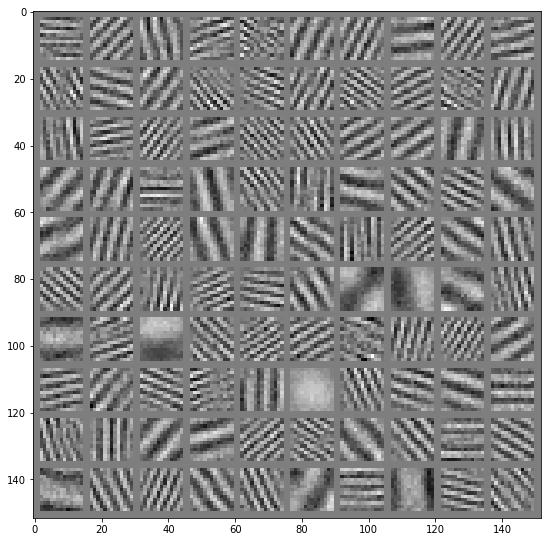

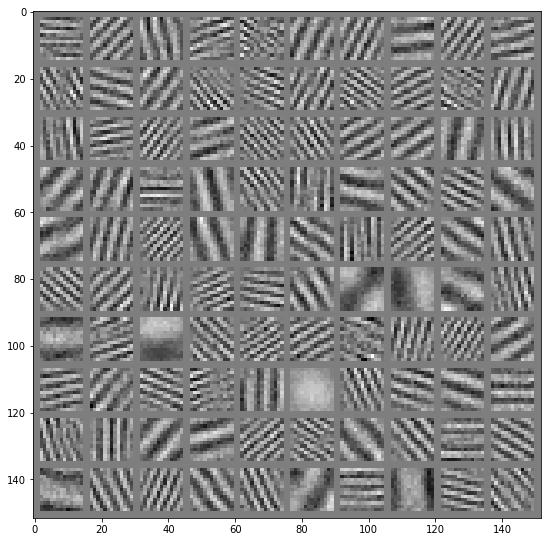

Epoch: 13500/20000 cost: 123.494662500
Epoch: 13501/20000 cost: 123.549600000
Epoch: 13502/20000 cost: 123.526400000
Epoch: 13503/20000 cost: 123.547287500
Epoch: 13504/20000 cost: 123.547312500
Epoch: 13505/20000 cost: 123.510450000
Epoch: 13506/20000 cost: 123.500650000
Epoch: 13507/20000 cost: 123.507875000
Epoch: 13508/20000 cost: 123.476275000
Epoch: 13509/20000 cost: 123.500475000
Epoch: 13510/20000 cost: 123.498950000
Epoch: 13511/20000 cost: 123.486462500
Epoch: 13512/20000 cost: 123.465325000
Epoch: 13513/20000 cost: 123.460600000
Epoch: 13514/20000 cost: 123.461600000
Epoch: 13515/20000 cost: 123.427625000
Epoch: 13516/20000 cost: 123.476475000
Epoch: 13517/20000 cost: 123.501762500
Epoch: 13518/20000 cost: 123.506087500
Epoch: 13519/20000 cost: 123.510500000
Epoch: 13520/20000 cost: 123.576975000
Epoch: 13521/20000 cost: 123.523437500
Epoch: 13522/20000 cost: 123.573825000
Epoch: 13523/20000 cost: 123.521975000
Epoch: 13524/20000 cost: 123.555475000
Epoch: 13525/20000 cost: 

Epoch: 13712/20000 cost: 123.471525000
Epoch: 13713/20000 cost: 123.543337500
Epoch: 13714/20000 cost: 123.500125000
Epoch: 13715/20000 cost: 123.482775000
Epoch: 13716/20000 cost: 123.498250000
Epoch: 13717/20000 cost: 123.507900000
Epoch: 13718/20000 cost: 123.511850000
Epoch: 13719/20000 cost: 123.474100000
Epoch: 13720/20000 cost: 123.457662500
Epoch: 13721/20000 cost: 123.479462500
Epoch: 13722/20000 cost: 123.461450000
Epoch: 13723/20000 cost: 123.530462500
Epoch: 13724/20000 cost: 123.497225000
Epoch: 13725/20000 cost: 123.495887500
Epoch: 13726/20000 cost: 123.485812500
Epoch: 13727/20000 cost: 123.478850000
Epoch: 13728/20000 cost: 123.511850000
Epoch: 13729/20000 cost: 123.581000000
Epoch: 13730/20000 cost: 123.569100000
Epoch: 13731/20000 cost: 123.494675000
Epoch: 13732/20000 cost: 123.515862500
Epoch: 13733/20000 cost: 123.470575000
Epoch: 13734/20000 cost: 123.517200000
Epoch: 13735/20000 cost: 123.459437500
Epoch: 13736/20000 cost: 123.491775000
Epoch: 13737/20000 cost: 

Epoch: 13924/20000 cost: 123.509337500
Epoch: 13925/20000 cost: 123.495475000
Epoch: 13926/20000 cost: 123.465625000
Epoch: 13927/20000 cost: 123.450425000
Epoch: 13928/20000 cost: 123.484850000
Epoch: 13929/20000 cost: 123.460537500
Epoch: 13930/20000 cost: 123.496925000
Epoch: 13931/20000 cost: 123.503850000
Epoch: 13932/20000 cost: 123.473425000
Epoch: 13933/20000 cost: 123.480350000
Epoch: 13934/20000 cost: 123.502800000
Epoch: 13935/20000 cost: 123.486987500
Epoch: 13936/20000 cost: 123.525100000
Epoch: 13937/20000 cost: 123.467837500
Epoch: 13938/20000 cost: 123.544437500
Epoch: 13939/20000 cost: 123.475675000
Epoch: 13940/20000 cost: 123.451512500
Epoch: 13941/20000 cost: 123.490275000
Epoch: 13942/20000 cost: 123.517775000
Epoch: 13943/20000 cost: 123.509800000
Epoch: 13944/20000 cost: 123.473575000
Epoch: 13945/20000 cost: 123.475650000
Epoch: 13946/20000 cost: 123.550012500
Epoch: 13947/20000 cost: 123.471112500
Epoch: 13948/20000 cost: 123.409575000
Epoch: 13949/20000 cost: 

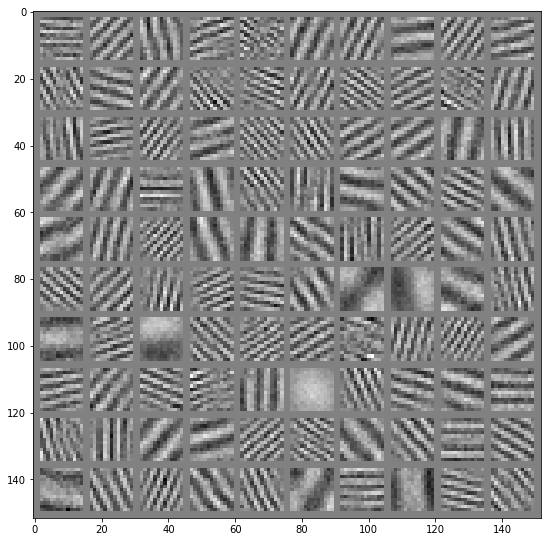

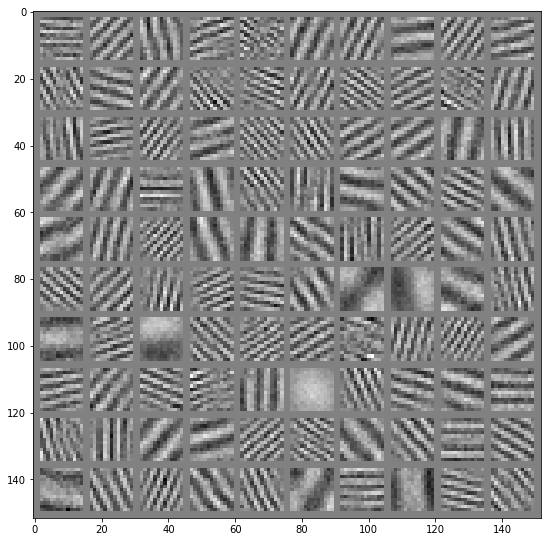

Epoch: 14000/20000 cost: 123.544162500
Epoch: 14001/20000 cost: 123.467150000
Epoch: 14002/20000 cost: 123.462612500
Epoch: 14003/20000 cost: 123.482475000
Epoch: 14004/20000 cost: 123.442437500
Epoch: 14005/20000 cost: 123.486750000
Epoch: 14006/20000 cost: 123.495425000
Epoch: 14007/20000 cost: 123.460600000
Epoch: 14008/20000 cost: 123.480600000
Epoch: 14009/20000 cost: 123.490562500
Epoch: 14010/20000 cost: 123.474700000
Epoch: 14011/20000 cost: 123.542975000
Epoch: 14012/20000 cost: 123.533500000
Epoch: 14013/20000 cost: 123.476000000
Epoch: 14014/20000 cost: 123.468700000
Epoch: 14015/20000 cost: 123.497300000
Epoch: 14016/20000 cost: 123.488500000
Epoch: 14017/20000 cost: 123.447400000
Epoch: 14018/20000 cost: 123.512637500
Epoch: 14019/20000 cost: 123.504787500
Epoch: 14020/20000 cost: 123.476050000
Epoch: 14021/20000 cost: 123.511725000
Epoch: 14022/20000 cost: 123.491700000
Epoch: 14023/20000 cost: 123.515500000
Epoch: 14024/20000 cost: 123.569062500
Epoch: 14025/20000 cost: 

Epoch: 14213/20000 cost: 123.453825000
Epoch: 14214/20000 cost: 123.486837500
Epoch: 14215/20000 cost: 123.487950000
Epoch: 14216/20000 cost: 123.499950000
Epoch: 14217/20000 cost: 123.467325000
Epoch: 14218/20000 cost: 123.501500000
Epoch: 14219/20000 cost: 123.555312500
Epoch: 14220/20000 cost: 123.492250000
Epoch: 14221/20000 cost: 123.571625000
Epoch: 14222/20000 cost: 123.566150000
Epoch: 14223/20000 cost: 123.583762500
Epoch: 14224/20000 cost: 123.525937500
Epoch: 14225/20000 cost: 123.571787500
Epoch: 14226/20000 cost: 123.545700000
Epoch: 14227/20000 cost: 123.597700000
Epoch: 14228/20000 cost: 123.564800000
Epoch: 14229/20000 cost: 123.574125000
Epoch: 14230/20000 cost: 123.600775000
Epoch: 14231/20000 cost: 123.623400000
Epoch: 14232/20000 cost: 123.534775000
Epoch: 14233/20000 cost: 123.488675000
Epoch: 14234/20000 cost: 123.517337500
Epoch: 14235/20000 cost: 123.491825000
Epoch: 14236/20000 cost: 123.489062500
Epoch: 14237/20000 cost: 123.529275000
Epoch: 14238/20000 cost: 

Epoch: 14424/20000 cost: 123.478400000
Epoch: 14425/20000 cost: 123.485750000
Epoch: 14426/20000 cost: 123.446775000
Epoch: 14427/20000 cost: 123.513325000
Epoch: 14428/20000 cost: 123.482700000
Epoch: 14429/20000 cost: 123.496700000
Epoch: 14430/20000 cost: 123.487200000
Epoch: 14431/20000 cost: 123.505300000
Epoch: 14432/20000 cost: 123.530625000
Epoch: 14433/20000 cost: 123.502625000
Epoch: 14434/20000 cost: 123.485887500
Epoch: 14435/20000 cost: 123.438387500
Epoch: 14436/20000 cost: 123.486800000
Epoch: 14437/20000 cost: 123.421825000
Epoch: 14438/20000 cost: 123.444550000
Epoch: 14439/20000 cost: 123.414462500
Epoch: 14440/20000 cost: 123.452237500
Epoch: 14441/20000 cost: 123.498550000
Epoch: 14442/20000 cost: 123.478062500
Epoch: 14443/20000 cost: 123.481025000
Epoch: 14444/20000 cost: 123.513325000
Epoch: 14445/20000 cost: 123.522850000
Epoch: 14446/20000 cost: 123.540925000
Epoch: 14447/20000 cost: 123.473725000
Epoch: 14448/20000 cost: 123.466800000
Epoch: 14449/20000 cost: 

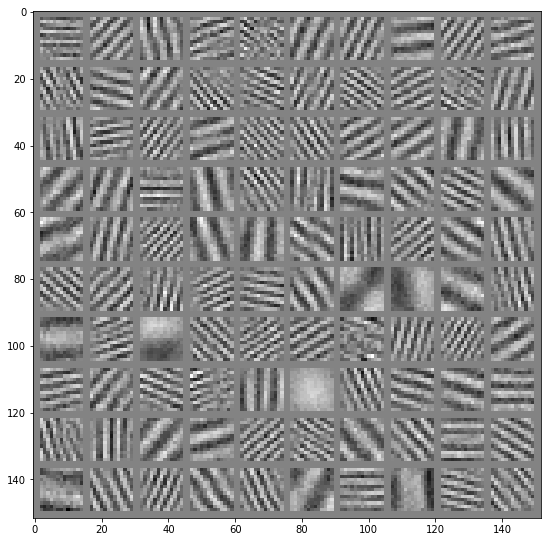

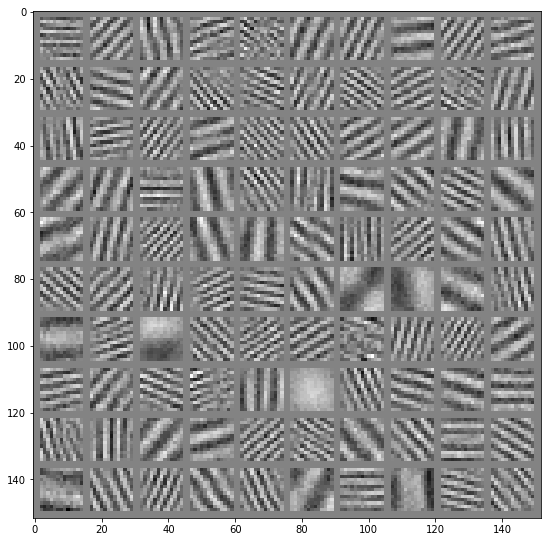

Epoch: 14500/20000 cost: 123.501387500
Epoch: 14501/20000 cost: 123.510150000
Epoch: 14502/20000 cost: 123.496900000
Epoch: 14503/20000 cost: 123.468700000
Epoch: 14504/20000 cost: 123.470450000
Epoch: 14505/20000 cost: 123.485950000
Epoch: 14506/20000 cost: 123.508750000
Epoch: 14507/20000 cost: 123.531450000
Epoch: 14508/20000 cost: 123.486987500
Epoch: 14509/20000 cost: 123.483275000
Epoch: 14510/20000 cost: 123.499350000
Epoch: 14511/20000 cost: 123.504225000
Epoch: 14512/20000 cost: 123.488750000
Epoch: 14513/20000 cost: 123.455525000
Epoch: 14514/20000 cost: 123.411262500
Epoch: 14515/20000 cost: 123.466575000
Epoch: 14516/20000 cost: 123.538975000
Epoch: 14517/20000 cost: 123.442150000
Epoch: 14518/20000 cost: 123.438275000
Epoch: 14519/20000 cost: 123.460675000
Epoch: 14520/20000 cost: 123.520125000
Epoch: 14521/20000 cost: 123.485775000
Epoch: 14522/20000 cost: 123.461025000
Epoch: 14523/20000 cost: 123.502325000
Epoch: 14524/20000 cost: 123.470225000
Epoch: 14525/20000 cost: 

Epoch: 14711/20000 cost: 123.486625000
Epoch: 14712/20000 cost: 123.504100000
Epoch: 14713/20000 cost: 123.500400000
Epoch: 14714/20000 cost: 123.447850000
Epoch: 14715/20000 cost: 123.482262500
Epoch: 14716/20000 cost: 123.468825000
Epoch: 14717/20000 cost: 123.468125000
Epoch: 14718/20000 cost: 123.497775000
Epoch: 14719/20000 cost: 123.522437500
Epoch: 14720/20000 cost: 123.479500000
Epoch: 14721/20000 cost: 123.447925000
Epoch: 14722/20000 cost: 123.390475000
Epoch: 14723/20000 cost: 123.460900000
Epoch: 14724/20000 cost: 123.447375000
Epoch: 14725/20000 cost: 123.493325000
Epoch: 14726/20000 cost: 123.541575000
Epoch: 14727/20000 cost: 123.526737500
Epoch: 14728/20000 cost: 123.564825000
Epoch: 14729/20000 cost: 123.552125000
Epoch: 14730/20000 cost: 123.516037500
Epoch: 14731/20000 cost: 123.462437500
Epoch: 14732/20000 cost: 123.459375000
Epoch: 14733/20000 cost: 123.467275000
Epoch: 14734/20000 cost: 123.450762500
Epoch: 14735/20000 cost: 123.451112500
Epoch: 14736/20000 cost: 

Epoch: 14924/20000 cost: 123.462887500
Epoch: 14925/20000 cost: 123.544800000
Epoch: 14926/20000 cost: 123.532575000
Epoch: 14927/20000 cost: 123.492025000
Epoch: 14928/20000 cost: 123.435862500
Epoch: 14929/20000 cost: 123.512925000
Epoch: 14930/20000 cost: 123.484300000
Epoch: 14931/20000 cost: 123.503800000
Epoch: 14932/20000 cost: 123.471937500
Epoch: 14933/20000 cost: 123.486312500
Epoch: 14934/20000 cost: 123.503675000
Epoch: 14935/20000 cost: 123.477637500
Epoch: 14936/20000 cost: 123.437987500
Epoch: 14937/20000 cost: 123.495075000
Epoch: 14938/20000 cost: 123.489550000
Epoch: 14939/20000 cost: 123.486812500
Epoch: 14940/20000 cost: 123.475937500
Epoch: 14941/20000 cost: 123.433550000
Epoch: 14942/20000 cost: 123.440375000
Epoch: 14943/20000 cost: 123.443650000
Epoch: 14944/20000 cost: 123.499700000
Epoch: 14945/20000 cost: 123.509100000
Epoch: 14946/20000 cost: 123.497700000
Epoch: 14947/20000 cost: 123.521012500
Epoch: 14948/20000 cost: 123.509850000
Epoch: 14949/20000 cost: 

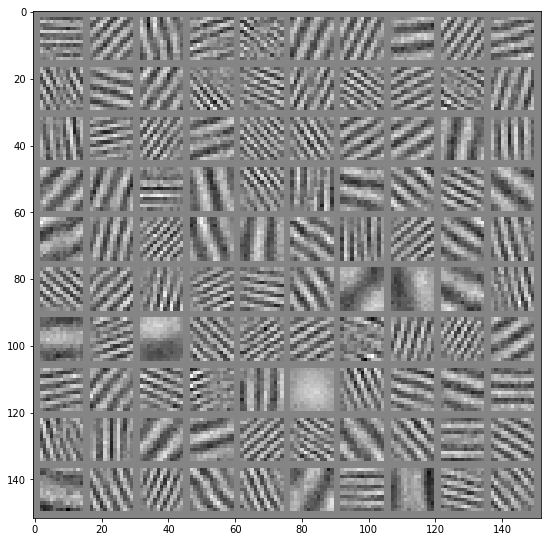

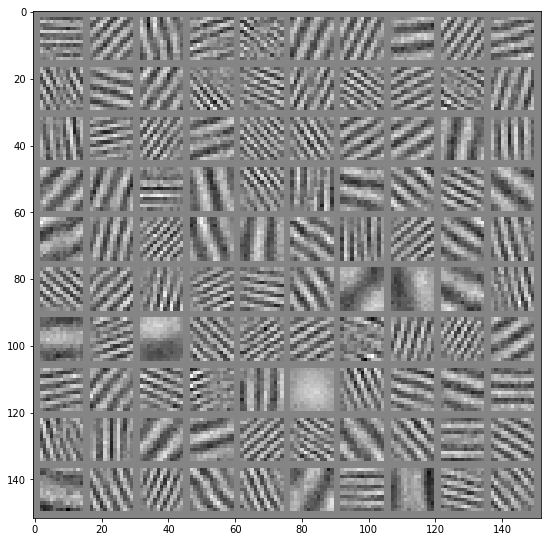

Epoch: 15000/20000 cost: 123.513137500
Epoch: 15001/20000 cost: 123.495875000
Epoch: 15002/20000 cost: 123.519275000
Epoch: 15003/20000 cost: 123.479450000
Epoch: 15004/20000 cost: 123.484387500
Epoch: 15005/20000 cost: 123.491850000
Epoch: 15006/20000 cost: 123.460525000
Epoch: 15007/20000 cost: 123.486700000
Epoch: 15008/20000 cost: 123.489700000
Epoch: 15009/20000 cost: 123.447462500
Epoch: 15010/20000 cost: 123.457350000
Epoch: 15011/20000 cost: 123.476637500
Epoch: 15012/20000 cost: 123.497450000
Epoch: 15013/20000 cost: 123.475175000
Epoch: 15014/20000 cost: 123.510500000
Epoch: 15015/20000 cost: 123.512950000
Epoch: 15016/20000 cost: 123.517625000
Epoch: 15017/20000 cost: 123.503250000
Epoch: 15018/20000 cost: 123.485962500
Epoch: 15019/20000 cost: 123.519825000
Epoch: 15020/20000 cost: 123.519462500
Epoch: 15021/20000 cost: 123.526500000
Epoch: 15022/20000 cost: 123.508687500
Epoch: 15023/20000 cost: 123.538200000
Epoch: 15024/20000 cost: 123.538225000
Epoch: 15025/20000 cost: 

Epoch: 15211/20000 cost: 123.481400000
Epoch: 15212/20000 cost: 123.505850000
Epoch: 15213/20000 cost: 123.501987500
Epoch: 15214/20000 cost: 123.450037500
Epoch: 15215/20000 cost: 123.432125000
Epoch: 15216/20000 cost: 123.439075000
Epoch: 15217/20000 cost: 123.423150000
Epoch: 15218/20000 cost: 123.407475000
Epoch: 15219/20000 cost: 123.417400000
Epoch: 15220/20000 cost: 123.417575000
Epoch: 15221/20000 cost: 123.426662500
Epoch: 15222/20000 cost: 123.460112500
Epoch: 15223/20000 cost: 123.428000000
Epoch: 15224/20000 cost: 123.387662500
Epoch: 15225/20000 cost: 123.436337500
Epoch: 15226/20000 cost: 123.468750000
Epoch: 15227/20000 cost: 123.488987500
Epoch: 15228/20000 cost: 123.437925000
Epoch: 15229/20000 cost: 123.435075000
Epoch: 15230/20000 cost: 123.427362500
Epoch: 15231/20000 cost: 123.430037500
Epoch: 15232/20000 cost: 123.503400000
Epoch: 15233/20000 cost: 123.493975000
Epoch: 15234/20000 cost: 123.467725000
Epoch: 15235/20000 cost: 123.458150000
Epoch: 15236/20000 cost: 

Epoch: 15424/20000 cost: 123.448962500
Epoch: 15425/20000 cost: 123.352450000
Epoch: 15426/20000 cost: 123.429225000
Epoch: 15427/20000 cost: 123.397200000
Epoch: 15428/20000 cost: 123.380100000
Epoch: 15429/20000 cost: 123.451550000
Epoch: 15430/20000 cost: 123.425875000
Epoch: 15431/20000 cost: 123.441000000
Epoch: 15432/20000 cost: 123.441275000
Epoch: 15433/20000 cost: 123.446550000
Epoch: 15434/20000 cost: 123.451700000
Epoch: 15435/20000 cost: 123.432850000
Epoch: 15436/20000 cost: 123.422050000
Epoch: 15437/20000 cost: 123.443375000
Epoch: 15438/20000 cost: 123.499300000
Epoch: 15439/20000 cost: 123.444950000
Epoch: 15440/20000 cost: 123.413100000
Epoch: 15441/20000 cost: 123.441475000
Epoch: 15442/20000 cost: 123.437237500
Epoch: 15443/20000 cost: 123.481100000
Epoch: 15444/20000 cost: 123.435337500
Epoch: 15445/20000 cost: 123.408100000
Epoch: 15446/20000 cost: 123.404600000
Epoch: 15447/20000 cost: 123.391000000
Epoch: 15448/20000 cost: 123.363937500
Epoch: 15449/20000 cost: 

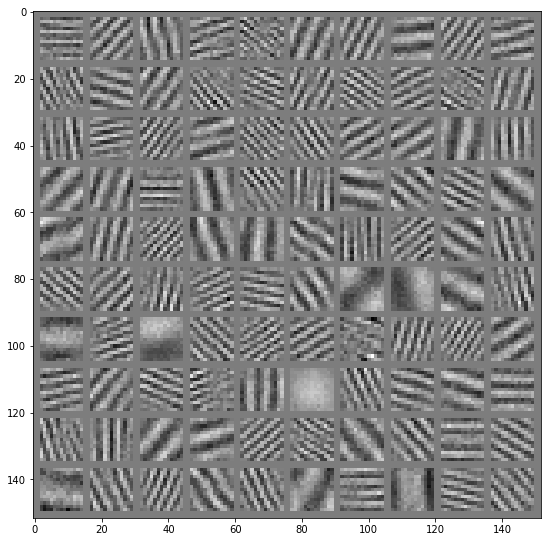

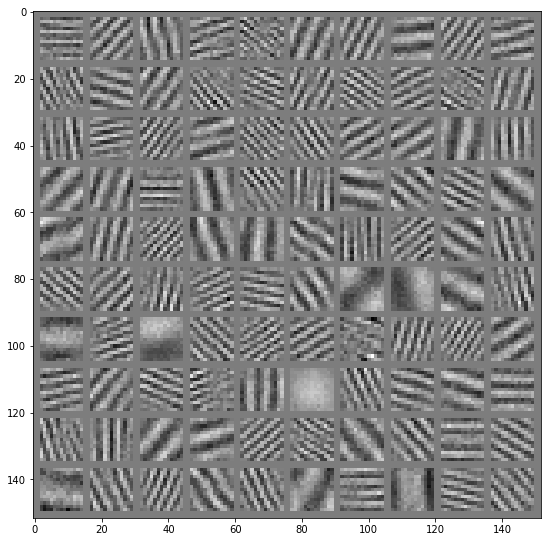

Epoch: 15500/20000 cost: 123.445362500
Epoch: 15501/20000 cost: 123.436625000
Epoch: 15502/20000 cost: 123.418050000
Epoch: 15503/20000 cost: 123.456862500
Epoch: 15504/20000 cost: 123.456325000
Epoch: 15505/20000 cost: 123.407150000
Epoch: 15506/20000 cost: 123.495875000
Epoch: 15507/20000 cost: 123.464425000
Epoch: 15508/20000 cost: 123.369887500
Epoch: 15509/20000 cost: 123.390762500
Epoch: 15510/20000 cost: 123.427450000
Epoch: 15511/20000 cost: 123.367850000
Epoch: 15512/20000 cost: 123.420000000
Epoch: 15513/20000 cost: 123.359300000
Epoch: 15514/20000 cost: 123.431387500
Epoch: 15515/20000 cost: 123.450525000
Epoch: 15516/20000 cost: 123.403475000
Epoch: 15517/20000 cost: 123.375000000
Epoch: 15518/20000 cost: 123.430925000
Epoch: 15519/20000 cost: 123.397800000
Epoch: 15520/20000 cost: 123.488350000
Epoch: 15521/20000 cost: 123.421675000
Epoch: 15522/20000 cost: 123.351550000
Epoch: 15523/20000 cost: 123.407125000
Epoch: 15524/20000 cost: 123.384325000
Epoch: 15525/20000 cost: 

Epoch: 15712/20000 cost: 123.497450000
Epoch: 15713/20000 cost: 123.481437500
Epoch: 15714/20000 cost: 123.585587500
Epoch: 15715/20000 cost: 123.485675000
Epoch: 15716/20000 cost: 123.522900000
Epoch: 15717/20000 cost: 123.474650000
Epoch: 15718/20000 cost: 123.475962500
Epoch: 15719/20000 cost: 123.487450000
Epoch: 15720/20000 cost: 123.451050000
Epoch: 15721/20000 cost: 123.503150000
Epoch: 15722/20000 cost: 123.468525000
Epoch: 15723/20000 cost: 123.474775000
Epoch: 15724/20000 cost: 123.487200000
Epoch: 15725/20000 cost: 123.520175000
Epoch: 15726/20000 cost: 123.525250000
Epoch: 15727/20000 cost: 123.423025000
Epoch: 15728/20000 cost: 123.513175000
Epoch: 15729/20000 cost: 123.503775000
Epoch: 15730/20000 cost: 123.412687500
Epoch: 15731/20000 cost: 123.443900000
Epoch: 15732/20000 cost: 123.488600000
Epoch: 15733/20000 cost: 123.495575000
Epoch: 15734/20000 cost: 123.481400000
Epoch: 15735/20000 cost: 123.491825000
Epoch: 15736/20000 cost: 123.504425000
Epoch: 15737/20000 cost: 

Epoch: 15923/20000 cost: 123.484025000
Epoch: 15924/20000 cost: 123.470450000
Epoch: 15925/20000 cost: 123.432300000
Epoch: 15926/20000 cost: 123.454787500
Epoch: 15927/20000 cost: 123.424875000
Epoch: 15928/20000 cost: 123.473125000
Epoch: 15929/20000 cost: 123.491100000
Epoch: 15930/20000 cost: 123.466050000
Epoch: 15931/20000 cost: 123.491225000
Epoch: 15932/20000 cost: 123.392500000
Epoch: 15933/20000 cost: 123.417475000
Epoch: 15934/20000 cost: 123.450675000
Epoch: 15935/20000 cost: 123.464037500
Epoch: 15936/20000 cost: 123.411875000
Epoch: 15937/20000 cost: 123.409375000
Epoch: 15938/20000 cost: 123.408962500
Epoch: 15939/20000 cost: 123.483075000
Epoch: 15940/20000 cost: 123.440350000
Epoch: 15941/20000 cost: 123.418087500
Epoch: 15942/20000 cost: 123.452262500
Epoch: 15943/20000 cost: 123.468700000
Epoch: 15944/20000 cost: 123.407862500
Epoch: 15945/20000 cost: 123.453300000
Epoch: 15946/20000 cost: 123.494400000
Epoch: 15947/20000 cost: 123.440400000
Epoch: 15948/20000 cost: 

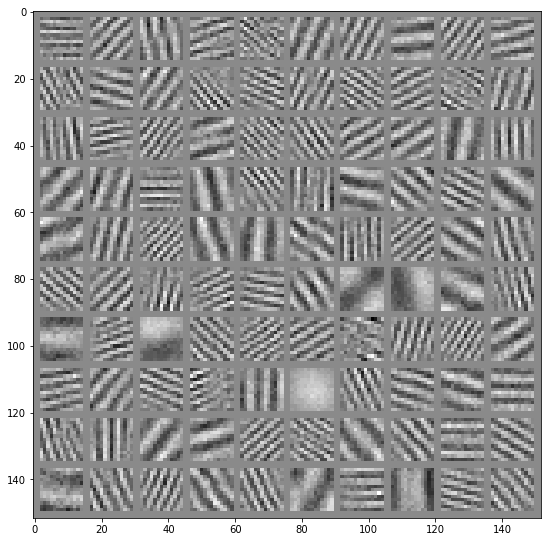

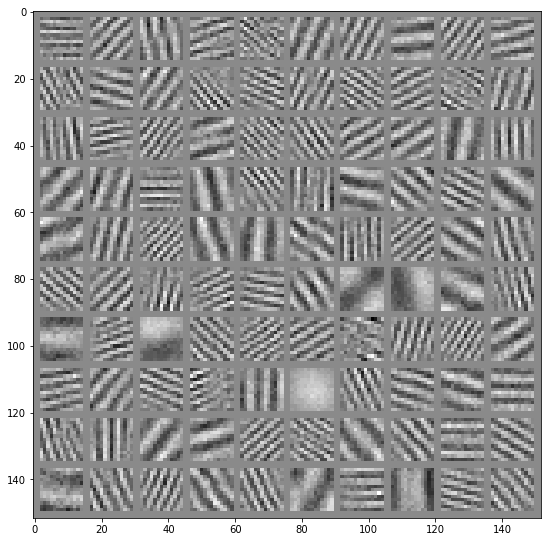

Epoch: 16000/20000 cost: 123.405387500
Epoch: 16001/20000 cost: 123.450950000
Epoch: 16002/20000 cost: 123.396375000
Epoch: 16003/20000 cost: 123.423837500
Epoch: 16004/20000 cost: 123.409950000
Epoch: 16005/20000 cost: 123.419375000
Epoch: 16006/20000 cost: 123.370562500
Epoch: 16007/20000 cost: 123.438575000
Epoch: 16008/20000 cost: 123.436712500
Epoch: 16009/20000 cost: 123.468275000
Epoch: 16010/20000 cost: 123.433900000
Epoch: 16011/20000 cost: 123.420825000
Epoch: 16012/20000 cost: 123.418800000
Epoch: 16013/20000 cost: 123.408875000
Epoch: 16014/20000 cost: 123.392925000
Epoch: 16015/20000 cost: 123.406562500
Epoch: 16016/20000 cost: 123.438425000
Epoch: 16017/20000 cost: 123.423150000
Epoch: 16018/20000 cost: 123.474750000
Epoch: 16019/20000 cost: 123.481312500
Epoch: 16020/20000 cost: 123.467612500
Epoch: 16021/20000 cost: 123.481100000
Epoch: 16022/20000 cost: 123.422112500
Epoch: 16023/20000 cost: 123.417737500
Epoch: 16024/20000 cost: 123.464000000
Epoch: 16025/20000 cost: 

Epoch: 16212/20000 cost: 123.407975000
Epoch: 16213/20000 cost: 123.465900000
Epoch: 16214/20000 cost: 123.352500000
Epoch: 16215/20000 cost: 123.415725000
Epoch: 16216/20000 cost: 123.391575000
Epoch: 16217/20000 cost: 123.449737500
Epoch: 16218/20000 cost: 123.409225000
Epoch: 16219/20000 cost: 123.379975000
Epoch: 16220/20000 cost: 123.455312500
Epoch: 16221/20000 cost: 123.473375000
Epoch: 16222/20000 cost: 123.429950000
Epoch: 16223/20000 cost: 123.481900000
Epoch: 16224/20000 cost: 123.446500000
Epoch: 16225/20000 cost: 123.463150000
Epoch: 16226/20000 cost: 123.474362500
Epoch: 16227/20000 cost: 123.478375000
Epoch: 16228/20000 cost: 123.462425000
Epoch: 16229/20000 cost: 123.498675000
Epoch: 16230/20000 cost: 123.469112500
Epoch: 16231/20000 cost: 123.397725000
Epoch: 16232/20000 cost: 123.465275000
Epoch: 16233/20000 cost: 123.431750000
Epoch: 16234/20000 cost: 123.535087500
Epoch: 16235/20000 cost: 123.485362500
Epoch: 16236/20000 cost: 123.459275000
Epoch: 16237/20000 cost: 

Epoch: 16425/20000 cost: 123.395000000
Epoch: 16426/20000 cost: 123.399775000
Epoch: 16427/20000 cost: 123.442025000
Epoch: 16428/20000 cost: 123.394725000
Epoch: 16429/20000 cost: 123.449600000
Epoch: 16430/20000 cost: 123.462325000
Epoch: 16431/20000 cost: 123.418300000
Epoch: 16432/20000 cost: 123.460725000
Epoch: 16433/20000 cost: 123.440925000
Epoch: 16434/20000 cost: 123.449525000
Epoch: 16435/20000 cost: 123.441450000
Epoch: 16436/20000 cost: 123.432950000
Epoch: 16437/20000 cost: 123.398075000
Epoch: 16438/20000 cost: 123.464625000
Epoch: 16439/20000 cost: 123.416300000
Epoch: 16440/20000 cost: 123.427525000
Epoch: 16441/20000 cost: 123.436775000
Epoch: 16442/20000 cost: 123.459825000
Epoch: 16443/20000 cost: 123.471025000
Epoch: 16444/20000 cost: 123.444225000
Epoch: 16445/20000 cost: 123.362262500
Epoch: 16446/20000 cost: 123.443000000
Epoch: 16447/20000 cost: 123.402737500
Epoch: 16448/20000 cost: 123.452225000
Epoch: 16449/20000 cost: 123.469912500
Epoch: 16450/20000 cost: 

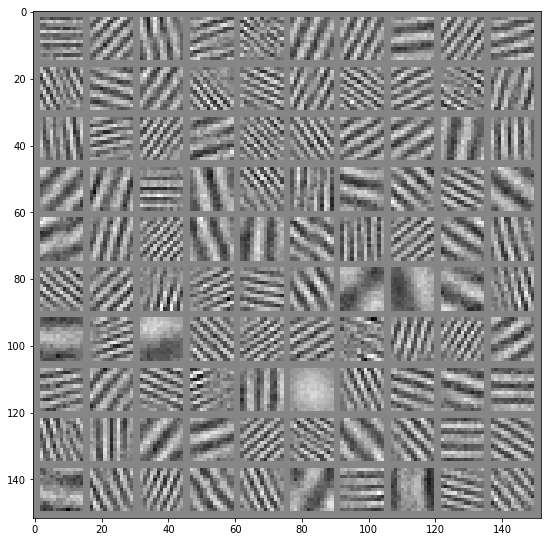

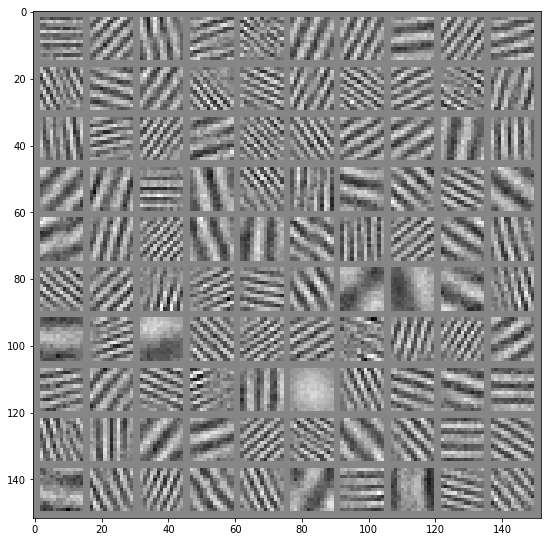

Epoch: 16500/20000 cost: 123.383600000
Epoch: 16501/20000 cost: 123.358912500
Epoch: 16502/20000 cost: 123.382550000
Epoch: 16503/20000 cost: 123.358537500
Epoch: 16504/20000 cost: 123.350500000
Epoch: 16505/20000 cost: 123.378275000
Epoch: 16506/20000 cost: 123.401700000
Epoch: 16507/20000 cost: 123.413600000
Epoch: 16508/20000 cost: 123.406625000
Epoch: 16509/20000 cost: 123.323050000
Epoch: 16510/20000 cost: 123.387250000
Epoch: 16511/20000 cost: 123.388075000
Epoch: 16512/20000 cost: 123.363150000
Epoch: 16513/20000 cost: 123.393637500
Epoch: 16514/20000 cost: 123.423900000
Epoch: 16515/20000 cost: 123.397150000
Epoch: 16516/20000 cost: 123.468275000
Epoch: 16517/20000 cost: 123.430137500
Epoch: 16518/20000 cost: 123.465337500
Epoch: 16519/20000 cost: 123.399150000
Epoch: 16520/20000 cost: 123.459175000
Epoch: 16521/20000 cost: 123.401950000
Epoch: 16522/20000 cost: 123.373000000
Epoch: 16523/20000 cost: 123.412225000
Epoch: 16524/20000 cost: 123.360112500
Epoch: 16525/20000 cost: 

Epoch: 16713/20000 cost: 123.391725000
Epoch: 16714/20000 cost: 123.308625000
Epoch: 16715/20000 cost: 123.335962500
Epoch: 16716/20000 cost: 123.400575000
Epoch: 16717/20000 cost: 123.360875000
Epoch: 16718/20000 cost: 123.362300000
Epoch: 16719/20000 cost: 123.375087500
Epoch: 16720/20000 cost: 123.463475000
Epoch: 16721/20000 cost: 123.406000000
Epoch: 16722/20000 cost: 123.427750000
Epoch: 16723/20000 cost: 123.433475000
Epoch: 16724/20000 cost: 123.387925000
Epoch: 16725/20000 cost: 123.356725000
Epoch: 16726/20000 cost: 123.368212500
Epoch: 16727/20000 cost: 123.372825000
Epoch: 16728/20000 cost: 123.432987500
Epoch: 16729/20000 cost: 123.369600000
Epoch: 16730/20000 cost: 123.382975000
Epoch: 16731/20000 cost: 123.429562500
Epoch: 16732/20000 cost: 123.459675000
Epoch: 16733/20000 cost: 123.448100000
Epoch: 16734/20000 cost: 123.493950000
Epoch: 16735/20000 cost: 123.536975000
Epoch: 16736/20000 cost: 123.465800000
Epoch: 16737/20000 cost: 123.411087500
Epoch: 16738/20000 cost: 

Epoch: 16925/20000 cost: 123.429450000
Epoch: 16926/20000 cost: 123.407187500
Epoch: 16927/20000 cost: 123.383275000
Epoch: 16928/20000 cost: 123.384650000
Epoch: 16929/20000 cost: 123.412250000
Epoch: 16930/20000 cost: 123.400000000
Epoch: 16931/20000 cost: 123.404950000
Epoch: 16932/20000 cost: 123.369375000
Epoch: 16933/20000 cost: 123.377987500
Epoch: 16934/20000 cost: 123.456675000
Epoch: 16935/20000 cost: 123.376425000
Epoch: 16936/20000 cost: 123.355625000
Epoch: 16937/20000 cost: 123.387000000
Epoch: 16938/20000 cost: 123.358550000
Epoch: 16939/20000 cost: 123.458562500
Epoch: 16940/20000 cost: 123.454700000
Epoch: 16941/20000 cost: 123.389250000
Epoch: 16942/20000 cost: 123.415375000
Epoch: 16943/20000 cost: 123.418837500
Epoch: 16944/20000 cost: 123.370262500
Epoch: 16945/20000 cost: 123.377425000
Epoch: 16946/20000 cost: 123.357125000
Epoch: 16947/20000 cost: 123.386775000
Epoch: 16948/20000 cost: 123.408925000
Epoch: 16949/20000 cost: 123.372587500
Epoch: 16950/20000 cost: 

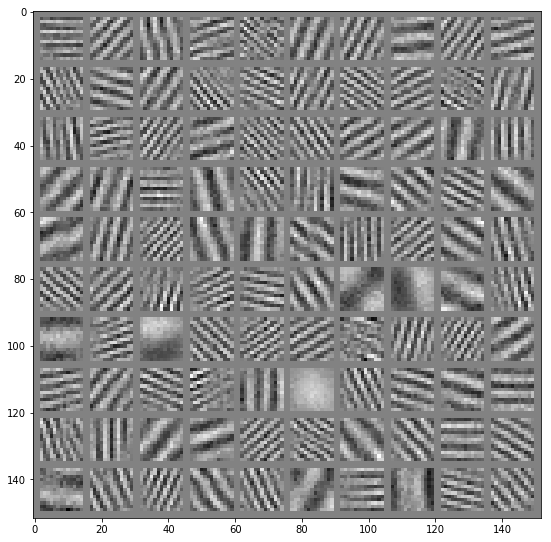

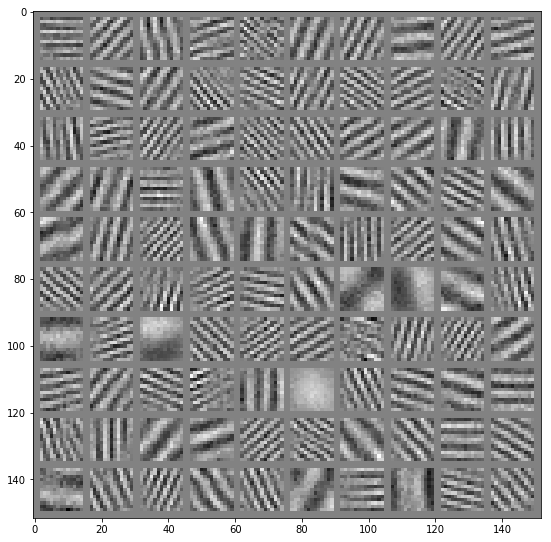

Epoch: 17000/20000 cost: 123.455125000
Epoch: 17001/20000 cost: 123.421400000
Epoch: 17002/20000 cost: 123.378825000
Epoch: 17003/20000 cost: 123.377925000
Epoch: 17004/20000 cost: 123.450637500
Epoch: 17005/20000 cost: 123.416450000
Epoch: 17006/20000 cost: 123.362625000
Epoch: 17007/20000 cost: 123.346275000
Epoch: 17008/20000 cost: 123.393475000
Epoch: 17009/20000 cost: 123.367587500
Epoch: 17010/20000 cost: 123.383425000
Epoch: 17011/20000 cost: 123.361150000
Epoch: 17012/20000 cost: 123.408612500
Epoch: 17013/20000 cost: 123.373550000
Epoch: 17014/20000 cost: 123.424587500
Epoch: 17015/20000 cost: 123.427837500
Epoch: 17016/20000 cost: 123.405150000
Epoch: 17017/20000 cost: 123.436212500
Epoch: 17018/20000 cost: 123.494825000
Epoch: 17019/20000 cost: 123.385275000
Epoch: 17020/20000 cost: 123.366875000
Epoch: 17021/20000 cost: 123.340175000
Epoch: 17022/20000 cost: 123.377875000
Epoch: 17023/20000 cost: 123.410350000
Epoch: 17024/20000 cost: 123.455175000
Epoch: 17025/20000 cost: 

Epoch: 17212/20000 cost: 123.324850000
Epoch: 17213/20000 cost: 123.294962500
Epoch: 17214/20000 cost: 123.319400000
Epoch: 17215/20000 cost: 123.341675000
Epoch: 17216/20000 cost: 123.310000000
Epoch: 17217/20000 cost: 123.329762500
Epoch: 17218/20000 cost: 123.354100000
Epoch: 17219/20000 cost: 123.402612500
Epoch: 17220/20000 cost: 123.408537500
Epoch: 17221/20000 cost: 123.357362500
Epoch: 17222/20000 cost: 123.388175000
Epoch: 17223/20000 cost: 123.283600000
Epoch: 17224/20000 cost: 123.338537500
Epoch: 17225/20000 cost: 123.285325000
Epoch: 17226/20000 cost: 123.269912500
Epoch: 17227/20000 cost: 123.270337500
Epoch: 17228/20000 cost: 123.323850000
Epoch: 17229/20000 cost: 123.282775000
Epoch: 17230/20000 cost: 123.321475000
Epoch: 17231/20000 cost: 123.325962500
Epoch: 17232/20000 cost: 123.389400000
Epoch: 17233/20000 cost: 123.347037500
Epoch: 17234/20000 cost: 123.399275000
Epoch: 17235/20000 cost: 123.387162500
Epoch: 17236/20000 cost: 123.426450000
Epoch: 17237/20000 cost: 

Epoch: 17425/20000 cost: 123.450900000
Epoch: 17426/20000 cost: 123.470012500
Epoch: 17427/20000 cost: 123.402537500
Epoch: 17428/20000 cost: 123.402550000
Epoch: 17429/20000 cost: 123.381425000
Epoch: 17430/20000 cost: 123.412125000
Epoch: 17431/20000 cost: 123.377262500
Epoch: 17432/20000 cost: 123.375000000
Epoch: 17433/20000 cost: 123.407350000
Epoch: 17434/20000 cost: 123.383125000
Epoch: 17435/20000 cost: 123.359912500
Epoch: 17436/20000 cost: 123.380575000
Epoch: 17437/20000 cost: 123.378650000
Epoch: 17438/20000 cost: 123.354937500
Epoch: 17439/20000 cost: 123.373975000
Epoch: 17440/20000 cost: 123.363550000
Epoch: 17441/20000 cost: 123.399100000
Epoch: 17442/20000 cost: 123.387675000
Epoch: 17443/20000 cost: 123.444275000
Epoch: 17444/20000 cost: 123.428000000
Epoch: 17445/20000 cost: 123.418975000
Epoch: 17446/20000 cost: 123.366000000
Epoch: 17447/20000 cost: 123.385150000
Epoch: 17448/20000 cost: 123.338312500
Epoch: 17449/20000 cost: 123.350137500
Epoch: 17450/20000 cost: 

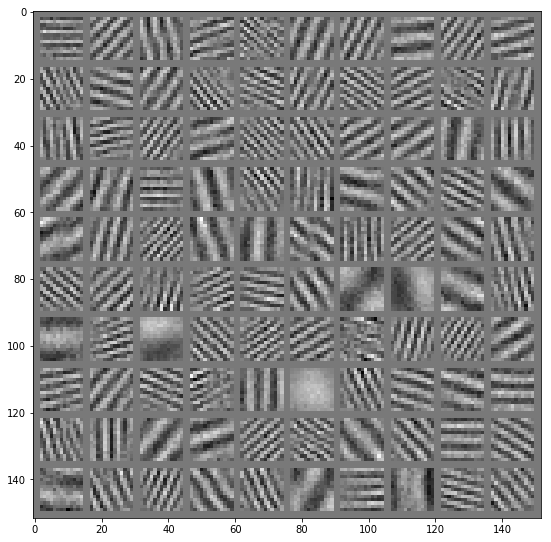

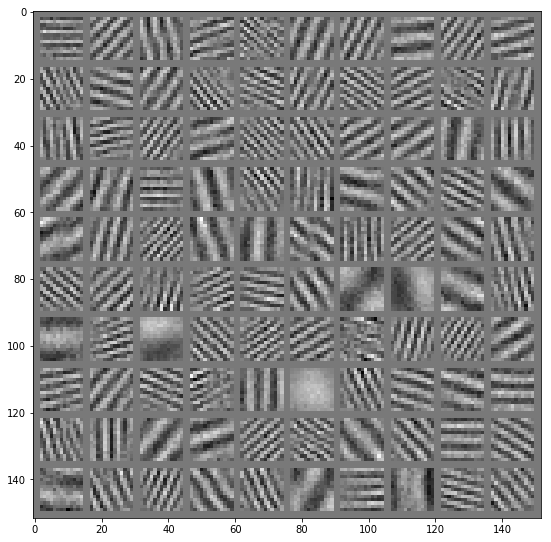

Epoch: 17500/20000 cost: 123.395025000
Epoch: 17501/20000 cost: 123.333550000
Epoch: 17502/20000 cost: 123.335700000
Epoch: 17503/20000 cost: 123.357625000
Epoch: 17504/20000 cost: 123.358875000
Epoch: 17505/20000 cost: 123.416575000
Epoch: 17506/20000 cost: 123.447487500
Epoch: 17507/20000 cost: 123.435912500
Epoch: 17508/20000 cost: 123.428275000
Epoch: 17509/20000 cost: 123.404450000
Epoch: 17510/20000 cost: 123.390075000
Epoch: 17511/20000 cost: 123.371675000
Epoch: 17512/20000 cost: 123.342500000
Epoch: 17513/20000 cost: 123.354962500
Epoch: 17514/20000 cost: 123.370700000
Epoch: 17515/20000 cost: 123.352100000
Epoch: 17516/20000 cost: 123.377900000
Epoch: 17517/20000 cost: 123.387212500
Epoch: 17518/20000 cost: 123.363925000
Epoch: 17519/20000 cost: 123.335525000
Epoch: 17520/20000 cost: 123.380175000
Epoch: 17521/20000 cost: 123.372425000
Epoch: 17522/20000 cost: 123.425425000
Epoch: 17523/20000 cost: 123.393812500
Epoch: 17524/20000 cost: 123.365075000
Epoch: 17525/20000 cost: 

Epoch: 17713/20000 cost: 123.393775000
Epoch: 17714/20000 cost: 123.376450000
Epoch: 17715/20000 cost: 123.343850000
Epoch: 17716/20000 cost: 123.364750000
Epoch: 17717/20000 cost: 123.366362500
Epoch: 17718/20000 cost: 123.328000000
Epoch: 17719/20000 cost: 123.394325000
Epoch: 17720/20000 cost: 123.325950000
Epoch: 17721/20000 cost: 123.433300000
Epoch: 17722/20000 cost: 123.388162500
Epoch: 17723/20000 cost: 123.377450000
Epoch: 17724/20000 cost: 123.458237500
Epoch: 17725/20000 cost: 123.417325000
Epoch: 17726/20000 cost: 123.436950000
Epoch: 17727/20000 cost: 123.438675000
Epoch: 17728/20000 cost: 123.398200000
Epoch: 17729/20000 cost: 123.375350000
Epoch: 17730/20000 cost: 123.374462500
Epoch: 17731/20000 cost: 123.392700000
Epoch: 17732/20000 cost: 123.418962500
Epoch: 17733/20000 cost: 123.375925000
Epoch: 17734/20000 cost: 123.358675000
Epoch: 17735/20000 cost: 123.381387500
Epoch: 17736/20000 cost: 123.375075000
Epoch: 17737/20000 cost: 123.383450000
Epoch: 17738/20000 cost: 

Epoch: 17925/20000 cost: 123.359125000
Epoch: 17926/20000 cost: 123.422200000
Epoch: 17927/20000 cost: 123.352800000
Epoch: 17928/20000 cost: 123.385412500
Epoch: 17929/20000 cost: 123.367825000
Epoch: 17930/20000 cost: 123.361525000
Epoch: 17931/20000 cost: 123.371650000
Epoch: 17932/20000 cost: 123.341375000
Epoch: 17933/20000 cost: 123.405162500
Epoch: 17934/20000 cost: 123.356250000
Epoch: 17935/20000 cost: 123.281350000
Epoch: 17936/20000 cost: 123.346112500
Epoch: 17937/20000 cost: 123.361137500
Epoch: 17938/20000 cost: 123.342925000
Epoch: 17939/20000 cost: 123.363037500
Epoch: 17940/20000 cost: 123.349837500
Epoch: 17941/20000 cost: 123.342200000
Epoch: 17942/20000 cost: 123.343712500
Epoch: 17943/20000 cost: 123.358650000
Epoch: 17944/20000 cost: 123.326325000
Epoch: 17945/20000 cost: 123.345825000
Epoch: 17946/20000 cost: 123.308512500
Epoch: 17947/20000 cost: 123.367100000
Epoch: 17948/20000 cost: 123.339900000
Epoch: 17949/20000 cost: 123.310025000
Epoch: 17950/20000 cost: 

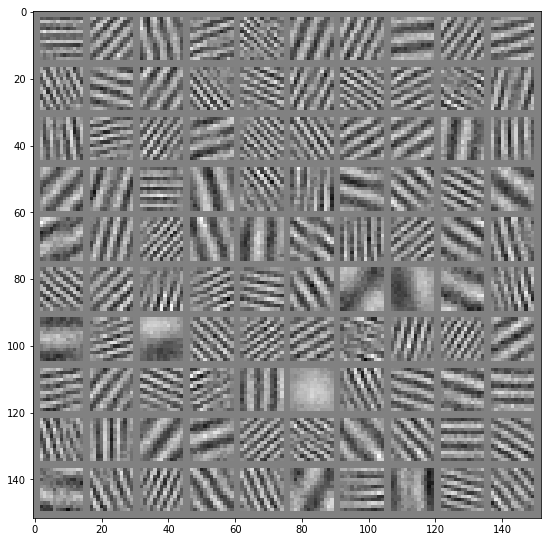

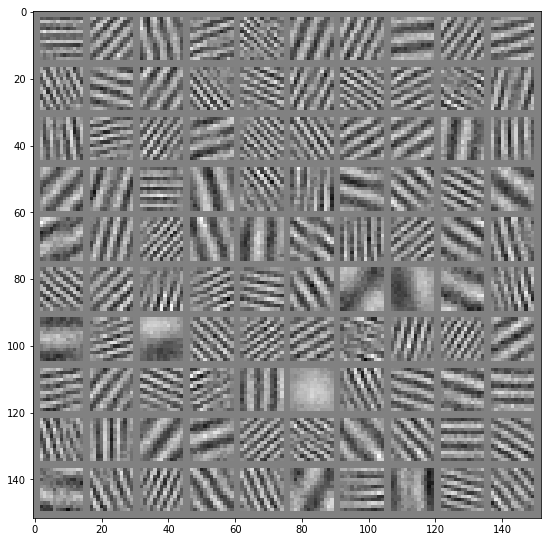

Epoch: 18000/20000 cost: 123.358862500
Epoch: 18001/20000 cost: 123.366050000
Epoch: 18002/20000 cost: 123.367300000
Epoch: 18003/20000 cost: 123.371775000
Epoch: 18004/20000 cost: 123.332350000
Epoch: 18005/20000 cost: 123.355550000
Epoch: 18006/20000 cost: 123.317262500
Epoch: 18007/20000 cost: 123.338850000
Epoch: 18008/20000 cost: 123.347725000
Epoch: 18009/20000 cost: 123.344800000
Epoch: 18010/20000 cost: 123.360350000
Epoch: 18011/20000 cost: 123.366962500
Epoch: 18012/20000 cost: 123.352175000
Epoch: 18013/20000 cost: 123.392450000
Epoch: 18014/20000 cost: 123.388687500
Epoch: 18015/20000 cost: 123.338237500
Epoch: 18016/20000 cost: 123.370425000
Epoch: 18017/20000 cost: 123.284475000
Epoch: 18018/20000 cost: 123.384600000
Epoch: 18019/20000 cost: 123.344500000
Epoch: 18020/20000 cost: 123.396950000
Epoch: 18021/20000 cost: 123.406612500
Epoch: 18022/20000 cost: 123.382950000
Epoch: 18023/20000 cost: 123.412937500
Epoch: 18024/20000 cost: 123.393675000
Epoch: 18025/20000 cost: 

Epoch: 18213/20000 cost: 123.271350000
Epoch: 18214/20000 cost: 123.344200000
Epoch: 18215/20000 cost: 123.356650000
Epoch: 18216/20000 cost: 123.382050000
Epoch: 18217/20000 cost: 123.335525000
Epoch: 18218/20000 cost: 123.356287500
Epoch: 18219/20000 cost: 123.331850000
Epoch: 18220/20000 cost: 123.365637500
Epoch: 18221/20000 cost: 123.390975000
Epoch: 18222/20000 cost: 123.356287500
Epoch: 18223/20000 cost: 123.379287500
Epoch: 18224/20000 cost: 123.376837500
Epoch: 18225/20000 cost: 123.338550000
Epoch: 18226/20000 cost: 123.334325000
Epoch: 18227/20000 cost: 123.369250000
Epoch: 18228/20000 cost: 123.430800000
Epoch: 18229/20000 cost: 123.351225000
Epoch: 18230/20000 cost: 123.373725000
Epoch: 18231/20000 cost: 123.366075000
Epoch: 18232/20000 cost: 123.309787500
Epoch: 18233/20000 cost: 123.356650000
Epoch: 18234/20000 cost: 123.367775000
Epoch: 18235/20000 cost: 123.401262500
Epoch: 18236/20000 cost: 123.425475000
Epoch: 18237/20000 cost: 123.429925000
Epoch: 18238/20000 cost: 

Epoch: 18425/20000 cost: 123.325050000
Epoch: 18426/20000 cost: 123.364225000
Epoch: 18427/20000 cost: 123.341275000
Epoch: 18428/20000 cost: 123.302187500
Epoch: 18429/20000 cost: 123.331150000
Epoch: 18430/20000 cost: 123.368100000
Epoch: 18431/20000 cost: 123.364200000
Epoch: 18432/20000 cost: 123.388162500
Epoch: 18433/20000 cost: 123.368025000
Epoch: 18434/20000 cost: 123.374075000
Epoch: 18435/20000 cost: 123.396200000
Epoch: 18436/20000 cost: 123.398075000
Epoch: 18437/20000 cost: 123.365175000
Epoch: 18438/20000 cost: 123.377100000
Epoch: 18439/20000 cost: 123.357475000
Epoch: 18440/20000 cost: 123.353112500
Epoch: 18441/20000 cost: 123.353637500
Epoch: 18442/20000 cost: 123.379025000
Epoch: 18443/20000 cost: 123.321725000
Epoch: 18444/20000 cost: 123.348162500
Epoch: 18445/20000 cost: 123.339525000
Epoch: 18446/20000 cost: 123.369775000
Epoch: 18447/20000 cost: 123.345800000
Epoch: 18448/20000 cost: 123.437200000
Epoch: 18449/20000 cost: 123.354300000
Epoch: 18450/20000 cost: 

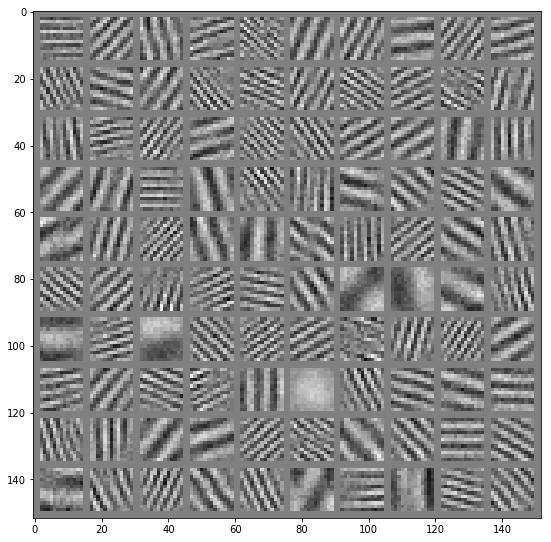

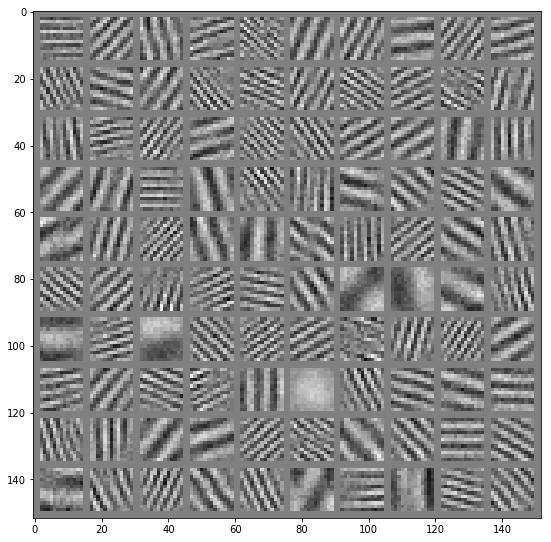

Epoch: 18500/20000 cost: 123.308675000
Epoch: 18501/20000 cost: 123.336275000
Epoch: 18502/20000 cost: 123.347250000
Epoch: 18503/20000 cost: 123.380062500
Epoch: 18504/20000 cost: 123.353550000
Epoch: 18505/20000 cost: 123.354787500
Epoch: 18506/20000 cost: 123.390700000
Epoch: 18507/20000 cost: 123.343825000
Epoch: 18508/20000 cost: 123.382125000
Epoch: 18509/20000 cost: 123.406662500
Epoch: 18510/20000 cost: 123.342475000
Epoch: 18511/20000 cost: 123.352000000
Epoch: 18512/20000 cost: 123.337925000
Epoch: 18513/20000 cost: 123.370412500
Epoch: 18514/20000 cost: 123.359800000
Epoch: 18515/20000 cost: 123.394300000
Epoch: 18516/20000 cost: 123.430025000
Epoch: 18517/20000 cost: 123.406025000
Epoch: 18518/20000 cost: 123.474787500
Epoch: 18519/20000 cost: 123.416650000
Epoch: 18520/20000 cost: 123.406650000
Epoch: 18521/20000 cost: 123.297037500
Epoch: 18522/20000 cost: 123.315762500
Epoch: 18523/20000 cost: 123.340500000
Epoch: 18524/20000 cost: 123.339550000
Epoch: 18525/20000 cost: 

Epoch: 18712/20000 cost: 123.382550000
Epoch: 18713/20000 cost: 123.340000000
Epoch: 18714/20000 cost: 123.256050000
Epoch: 18715/20000 cost: 123.300475000
Epoch: 18716/20000 cost: 123.275725000
Epoch: 18717/20000 cost: 123.330500000
Epoch: 18718/20000 cost: 123.344825000
Epoch: 18719/20000 cost: 123.374362500
Epoch: 18720/20000 cost: 123.396875000
Epoch: 18721/20000 cost: 123.383087500
Epoch: 18722/20000 cost: 123.373450000
Epoch: 18723/20000 cost: 123.362437500
Epoch: 18724/20000 cost: 123.345000000
Epoch: 18725/20000 cost: 123.333050000
Epoch: 18726/20000 cost: 123.365750000
Epoch: 18727/20000 cost: 123.386725000
Epoch: 18728/20000 cost: 123.348575000
Epoch: 18729/20000 cost: 123.328900000
Epoch: 18730/20000 cost: 123.341450000
Epoch: 18731/20000 cost: 123.309287500
Epoch: 18732/20000 cost: 123.384037500
Epoch: 18733/20000 cost: 123.316725000
Epoch: 18734/20000 cost: 123.349237500
Epoch: 18735/20000 cost: 123.357412500
Epoch: 18736/20000 cost: 123.374725000
Epoch: 18737/20000 cost: 

Epoch: 18923/20000 cost: 123.393975000
Epoch: 18924/20000 cost: 123.314700000
Epoch: 18925/20000 cost: 123.328625000
Epoch: 18926/20000 cost: 123.397225000
Epoch: 18927/20000 cost: 123.356875000
Epoch: 18928/20000 cost: 123.369162500
Epoch: 18929/20000 cost: 123.403875000
Epoch: 18930/20000 cost: 123.342025000
Epoch: 18931/20000 cost: 123.341200000
Epoch: 18932/20000 cost: 123.367400000
Epoch: 18933/20000 cost: 123.288325000
Epoch: 18934/20000 cost: 123.368875000
Epoch: 18935/20000 cost: 123.378675000
Epoch: 18936/20000 cost: 123.397000000
Epoch: 18937/20000 cost: 123.327000000
Epoch: 18938/20000 cost: 123.375100000
Epoch: 18939/20000 cost: 123.336675000
Epoch: 18940/20000 cost: 123.366800000
Epoch: 18941/20000 cost: 123.412262500
Epoch: 18942/20000 cost: 123.361050000
Epoch: 18943/20000 cost: 123.323300000
Epoch: 18944/20000 cost: 123.371275000
Epoch: 18945/20000 cost: 123.340375000
Epoch: 18946/20000 cost: 123.380775000
Epoch: 18947/20000 cost: 123.422200000
Epoch: 18948/20000 cost: 

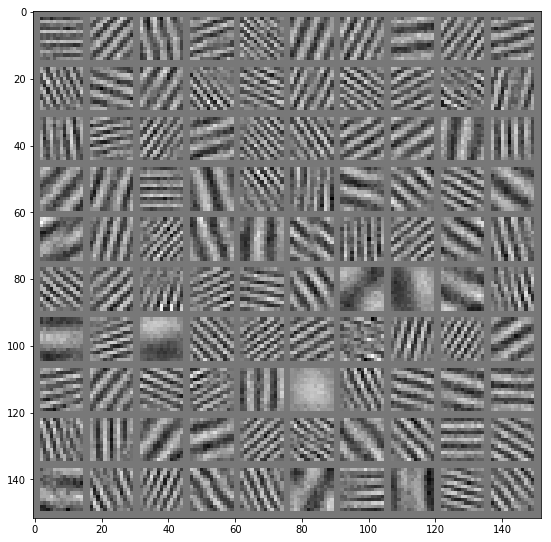

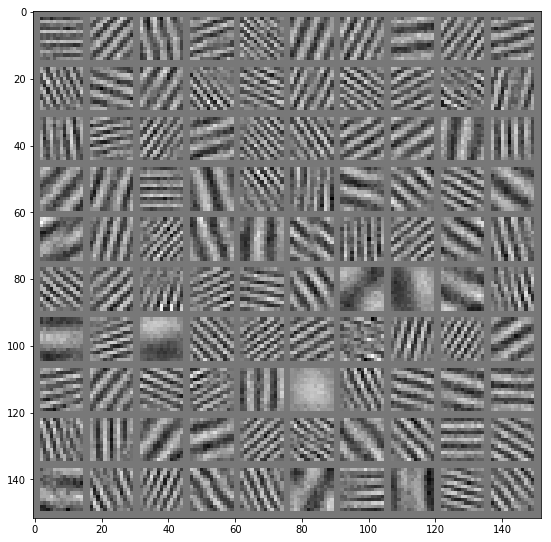

Epoch: 19000/20000 cost: 123.320550000
Epoch: 19001/20000 cost: 123.313875000
Epoch: 19002/20000 cost: 123.370800000
Epoch: 19003/20000 cost: 123.293850000
Epoch: 19004/20000 cost: 123.382575000
Epoch: 19005/20000 cost: 123.327425000
Epoch: 19006/20000 cost: 123.336137500
Epoch: 19007/20000 cost: 123.371000000
Epoch: 19008/20000 cost: 123.331200000
Epoch: 19009/20000 cost: 123.347850000
Epoch: 19010/20000 cost: 123.348925000
Epoch: 19011/20000 cost: 123.384725000
Epoch: 19012/20000 cost: 123.385500000
Epoch: 19013/20000 cost: 123.365100000
Epoch: 19014/20000 cost: 123.349600000
Epoch: 19015/20000 cost: 123.303175000
Epoch: 19016/20000 cost: 123.312350000
Epoch: 19017/20000 cost: 123.302150000
Epoch: 19018/20000 cost: 123.305425000
Epoch: 19019/20000 cost: 123.344125000
Epoch: 19020/20000 cost: 123.404412500
Epoch: 19021/20000 cost: 123.337125000
Epoch: 19022/20000 cost: 123.348700000
Epoch: 19023/20000 cost: 123.339775000
Epoch: 19024/20000 cost: 123.327925000
Epoch: 19025/20000 cost: 

Epoch: 19211/20000 cost: 123.384937500
Epoch: 19212/20000 cost: 123.365400000
Epoch: 19213/20000 cost: 123.442425000
Epoch: 19214/20000 cost: 123.371875000
Epoch: 19215/20000 cost: 123.349800000
Epoch: 19216/20000 cost: 123.372787500
Epoch: 19217/20000 cost: 123.366225000
Epoch: 19218/20000 cost: 123.359462500
Epoch: 19219/20000 cost: 123.375000000
Epoch: 19220/20000 cost: 123.394612500
Epoch: 19221/20000 cost: 123.361175000
Epoch: 19222/20000 cost: 123.395212500
Epoch: 19223/20000 cost: 123.402150000
Epoch: 19224/20000 cost: 123.348750000
Epoch: 19225/20000 cost: 123.369050000
Epoch: 19226/20000 cost: 123.460012500
Epoch: 19227/20000 cost: 123.399712500
Epoch: 19228/20000 cost: 123.429275000
Epoch: 19229/20000 cost: 123.397000000
Epoch: 19230/20000 cost: 123.414700000
Epoch: 19231/20000 cost: 123.439900000
Epoch: 19232/20000 cost: 123.378875000
Epoch: 19233/20000 cost: 123.389275000
Epoch: 19234/20000 cost: 123.400025000
Epoch: 19235/20000 cost: 123.377175000
Epoch: 19236/20000 cost: 

Epoch: 19424/20000 cost: 123.382925000
Epoch: 19425/20000 cost: 123.324825000
Epoch: 19426/20000 cost: 123.322712500
Epoch: 19427/20000 cost: 123.363637500
Epoch: 19428/20000 cost: 123.296350000
Epoch: 19429/20000 cost: 123.371300000
Epoch: 19430/20000 cost: 123.341612500
Epoch: 19431/20000 cost: 123.363525000
Epoch: 19432/20000 cost: 123.357137500
Epoch: 19433/20000 cost: 123.377700000
Epoch: 19434/20000 cost: 123.351550000
Epoch: 19435/20000 cost: 123.336575000
Epoch: 19436/20000 cost: 123.343425000
Epoch: 19437/20000 cost: 123.339475000
Epoch: 19438/20000 cost: 123.366600000
Epoch: 19439/20000 cost: 123.363287500
Epoch: 19440/20000 cost: 123.401437500
Epoch: 19441/20000 cost: 123.389875000
Epoch: 19442/20000 cost: 123.371162500
Epoch: 19443/20000 cost: 123.387700000
Epoch: 19444/20000 cost: 123.323800000
Epoch: 19445/20000 cost: 123.318850000
Epoch: 19446/20000 cost: 123.382625000
Epoch: 19447/20000 cost: 123.346650000
Epoch: 19448/20000 cost: 123.363400000
Epoch: 19449/20000 cost: 

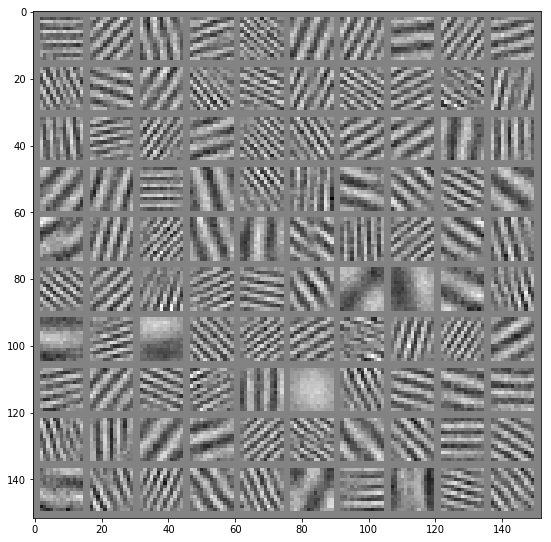

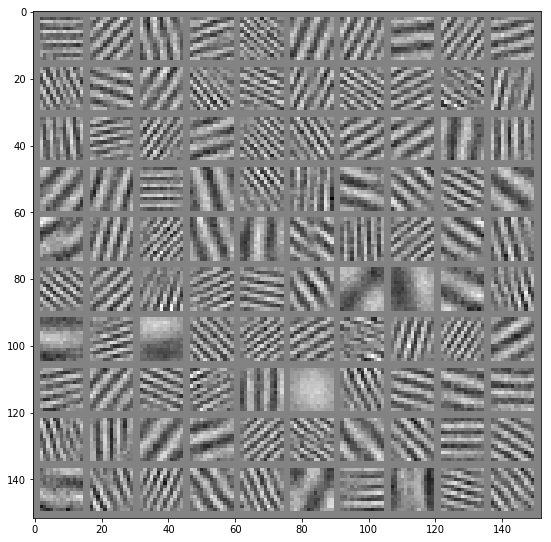

Epoch: 19500/20000 cost: 123.344137500
Epoch: 19501/20000 cost: 123.401850000
Epoch: 19502/20000 cost: 123.409700000
Epoch: 19503/20000 cost: 123.321125000
Epoch: 19504/20000 cost: 123.379212500
Epoch: 19505/20000 cost: 123.391075000
Epoch: 19506/20000 cost: 123.370225000
Epoch: 19507/20000 cost: 123.339275000
Epoch: 19508/20000 cost: 123.339875000
Epoch: 19509/20000 cost: 123.328437500
Epoch: 19510/20000 cost: 123.330712500
Epoch: 19511/20000 cost: 123.362300000
Epoch: 19512/20000 cost: 123.380537500
Epoch: 19513/20000 cost: 123.389600000
Epoch: 19514/20000 cost: 123.446300000
Epoch: 19515/20000 cost: 123.379500000
Epoch: 19516/20000 cost: 123.432512500
Epoch: 19517/20000 cost: 123.383700000
Epoch: 19518/20000 cost: 123.389387500
Epoch: 19519/20000 cost: 123.360250000
Epoch: 19520/20000 cost: 123.324500000
Epoch: 19521/20000 cost: 123.407675000
Epoch: 19522/20000 cost: 123.378050000
Epoch: 19523/20000 cost: 123.366575000
Epoch: 19524/20000 cost: 123.372025000
Epoch: 19525/20000 cost: 

Epoch: 19711/20000 cost: 123.300462500
Epoch: 19712/20000 cost: 123.295050000
Epoch: 19713/20000 cost: 123.348875000
Epoch: 19714/20000 cost: 123.320175000
Epoch: 19715/20000 cost: 123.340025000
Epoch: 19716/20000 cost: 123.387275000
Epoch: 19717/20000 cost: 123.337025000
Epoch: 19718/20000 cost: 123.336962500
Epoch: 19719/20000 cost: 123.333775000
Epoch: 19720/20000 cost: 123.299050000
Epoch: 19721/20000 cost: 123.319750000
Epoch: 19722/20000 cost: 123.353300000
Epoch: 19723/20000 cost: 123.318875000
Epoch: 19724/20000 cost: 123.361875000
Epoch: 19725/20000 cost: 123.370750000
Epoch: 19726/20000 cost: 123.436400000
Epoch: 19727/20000 cost: 123.398400000
Epoch: 19728/20000 cost: 123.458837500
Epoch: 19729/20000 cost: 123.416400000
Epoch: 19730/20000 cost: 123.444800000
Epoch: 19731/20000 cost: 123.417125000
Epoch: 19732/20000 cost: 123.395462500
Epoch: 19733/20000 cost: 123.308875000
Epoch: 19734/20000 cost: 123.355325000
Epoch: 19735/20000 cost: 123.331350000
Epoch: 19736/20000 cost: 

Epoch: 19923/20000 cost: 123.358450000
Epoch: 19924/20000 cost: 123.309425000
Epoch: 19925/20000 cost: 123.351500000
Epoch: 19926/20000 cost: 123.312925000
Epoch: 19927/20000 cost: 123.308175000
Epoch: 19928/20000 cost: 123.341625000
Epoch: 19929/20000 cost: 123.331312500
Epoch: 19930/20000 cost: 123.288800000
Epoch: 19931/20000 cost: 123.332375000
Epoch: 19932/20000 cost: 123.408325000
Epoch: 19933/20000 cost: 123.329050000
Epoch: 19934/20000 cost: 123.356362500
Epoch: 19935/20000 cost: 123.356650000
Epoch: 19936/20000 cost: 123.363425000
Epoch: 19937/20000 cost: 123.380625000
Epoch: 19938/20000 cost: 123.312275000
Epoch: 19939/20000 cost: 123.294850000
Epoch: 19940/20000 cost: 123.243312500
Epoch: 19941/20000 cost: 123.312075000
Epoch: 19942/20000 cost: 123.291425000
Epoch: 19943/20000 cost: 123.319800000
Epoch: 19944/20000 cost: 123.327625000
Epoch: 19945/20000 cost: 123.275387500
Epoch: 19946/20000 cost: 123.354962500
Epoch: 19947/20000 cost: 123.319200000
Epoch: 19948/20000 cost: 

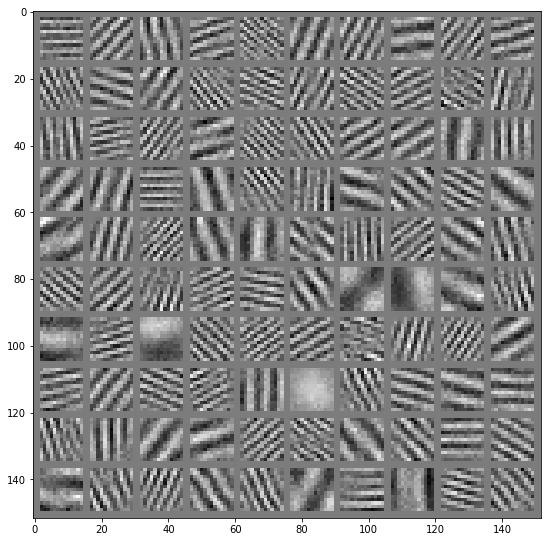

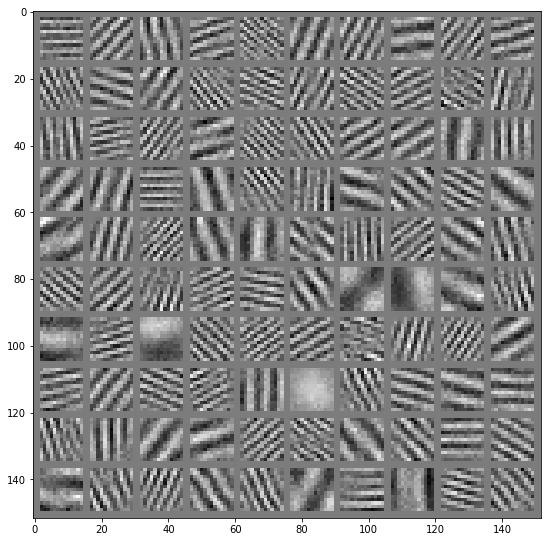

In [4]:


training_epochs = 20000
batch_size = 100
SMALL = 0.000001


with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        randidx  = np.random.randint(ntrain, size=batch_size).astype('int32')
        batch_xs = X[randidx]
        batch_ys = Y[randidx]  
        sess.run(optimizer, feed_dict={inputsX: batch_xs, inputsY: batch_ys})
        sess.run(normalize_wxf)
        sess.run(normalize_wyf)
#         normalizefilters(sess,wxf,wyf)
        
        cost_ = sess.run(cost, feed_dict={inputsX: X, inputsY: Y}) / ntrain
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,cost_) ) 
        if ((epoch+1) % 500) == 0 :
            import pylab
            pylab.figure(figsize=(20, 20)) 
            pylab.subplot(1, 2, 1)
            dispims(wxf.eval(sess), 13, 13, 2)
            pylab.figure(figsize=(20, 20))
            pylab.subplot(1, 2, 2)
            dispims(wyf.eval(sess), 13, 13, 2)